In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom

import gc
import warnings

warnings.simplefilter(action = 'ignore')
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.model_selection import KFold

In [2]:
detailed_class_info = pd.read_csv('../data/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('../data/stage_2_train_labels.csv')

df = pd.merge(left = detailed_class_info, right = train_labels, how = 'left', on = 'patientId')

del detailed_class_info, train_labels
gc.collect()

df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 7 columns):
patientId    37629 non-null object
class        37629 non-null object
x            16957 non-null float64
y            16957 non-null float64
width        16957 non-null float64
height       16957 non-null float64
Target       37629 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB


In [3]:
df.head()

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


In [4]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
patientId    30227 non-null object
class        30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [5]:
df['patientId'].value_counts().head(10)

0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
3239951b-6211-4290-b237-3d9ad17176db    4
32408669-c137-4e8d-bd62-fe8345b40e73    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
0d5bc737-03de-4bb8-98a1-45b7180c3e0f    4
7d674c82-5501-4730-92c5-d241fd6911e7    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
Name: patientId, dtype: int64

In [6]:
df[df['patientId'] == '32408669-c137-4e8d-bd62-fe8345b40e73']

,patientId,class,x,y,width,height,Target
3433,32408669-c137-4e8d-bd62-fe8345b40e73,Lung Opacity,273.0,856.0,234.0,101.0,1
3434,32408669-c137-4e8d-bd62-fe8345b40e73,Lung Opacity,702.0,801.0,249.0,144.0,1
3435,32408669-c137-4e8d-bd62-fe8345b40e73,Lung Opacity,300.0,367.0,226.0,423.0,1
3436,32408669-c137-4e8d-bd62-fe8345b40e73,Lung Opacity,706.0,360.0,232.0,238.0,1


In [7]:
df['patientId'].value_counts().value_counts()

1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64

In [8]:
df[df['Target'] == 0]['patientId'].value_counts().value_counts()

1    20672
Name: patientId, dtype: int64

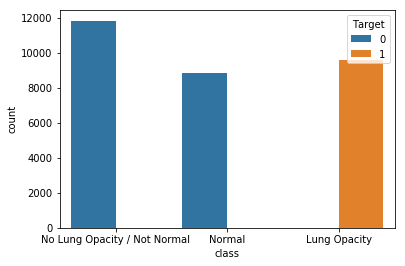

In [9]:
sns.countplot(x = 'class', hue = 'Target', data = df);

In [10]:
df[df['class'] == 'Lung Opacity']['Target'].value_counts(dropna = False)

1    9555
Name: Target, dtype: int64

In [11]:

df[df['class'] == 'No Lung Opacity / Not Normal']['Target'].value_counts(dropna = False)

0    11821
Name: Target, dtype: int64

In [12]:
df[df['class'] == 'Normal']['Target'].value_counts(dropna = False)

0    8851
Name: Target, dtype: int64

In [13]:
print('Patients can have {} different classes'.format(df.groupby('patientId')['class'].nunique().nunique()))

Patients can have 1 different classes


In [14]:
df_areas = df.dropna()[['x', 'y', 'width', 'height']].copy()
df_areas['x_2'] = df_areas['x'] + df_areas['width']
df_areas['y_2'] = df_areas['y'] + df_areas['height']
df_areas['x_center'] = df_areas['x'] + df_areas['width'] / 2
df_areas['y_center'] = df_areas['y'] + df_areas['height'] / 2
df_areas['area'] = df_areas['width'] * df_areas['height']

df_areas.head()

,x,y,width,height,x_2,y_2,x_center,y_center,area
4,264.0,152.0,213.0,379.0,477.0,531.0,370.5,341.5,80727.0
5,562.0,152.0,256.0,453.0,818.0,605.0,690.0,378.5,115968.0
10,323.0,577.0,160.0,104.0,483.0,681.0,403.0,629.0,16640.0
11,695.0,575.0,162.0,137.0,857.0,712.0,776.0,643.5,22194.0
18,288.0,322.0,94.0,135.0,382.0,457.0,335.0,389.5,12690.0


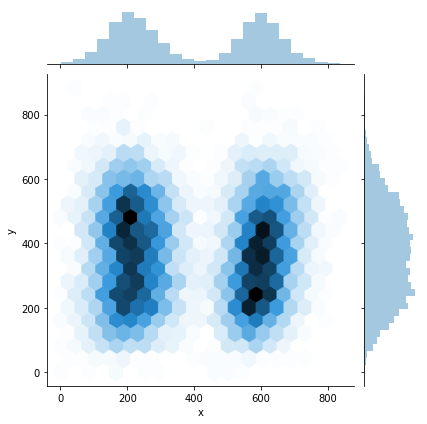

In [15]:
sns.jointplot(x = 'x', y = 'y', data = df_areas, kind = 'hex', gridsize = 20);

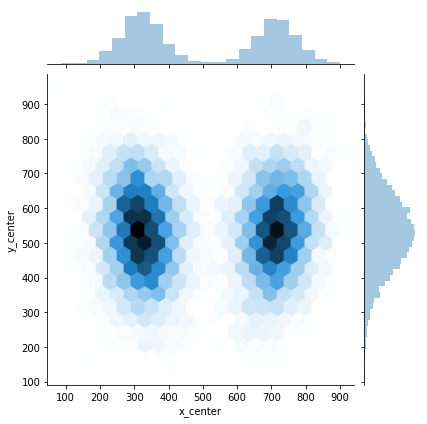

In [16]:
sns.jointplot(x = 'x_center', y = 'y_center', data = df_areas, kind = 'hex', gridsize = 20);

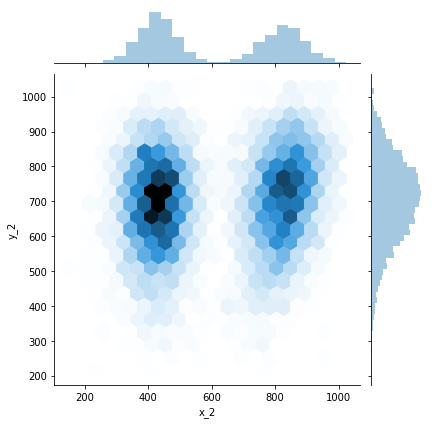

In [17]:
sns.jointplot(x = 'x_2', y = 'y_2', data = df_areas, kind = 'hex', gridsize = 20);

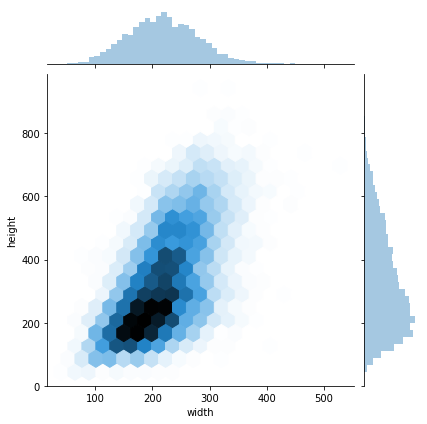

In [18]:
sns.jointplot(x = 'width', y = 'height', data = df_areas, kind = 'hex', gridsize = 20);

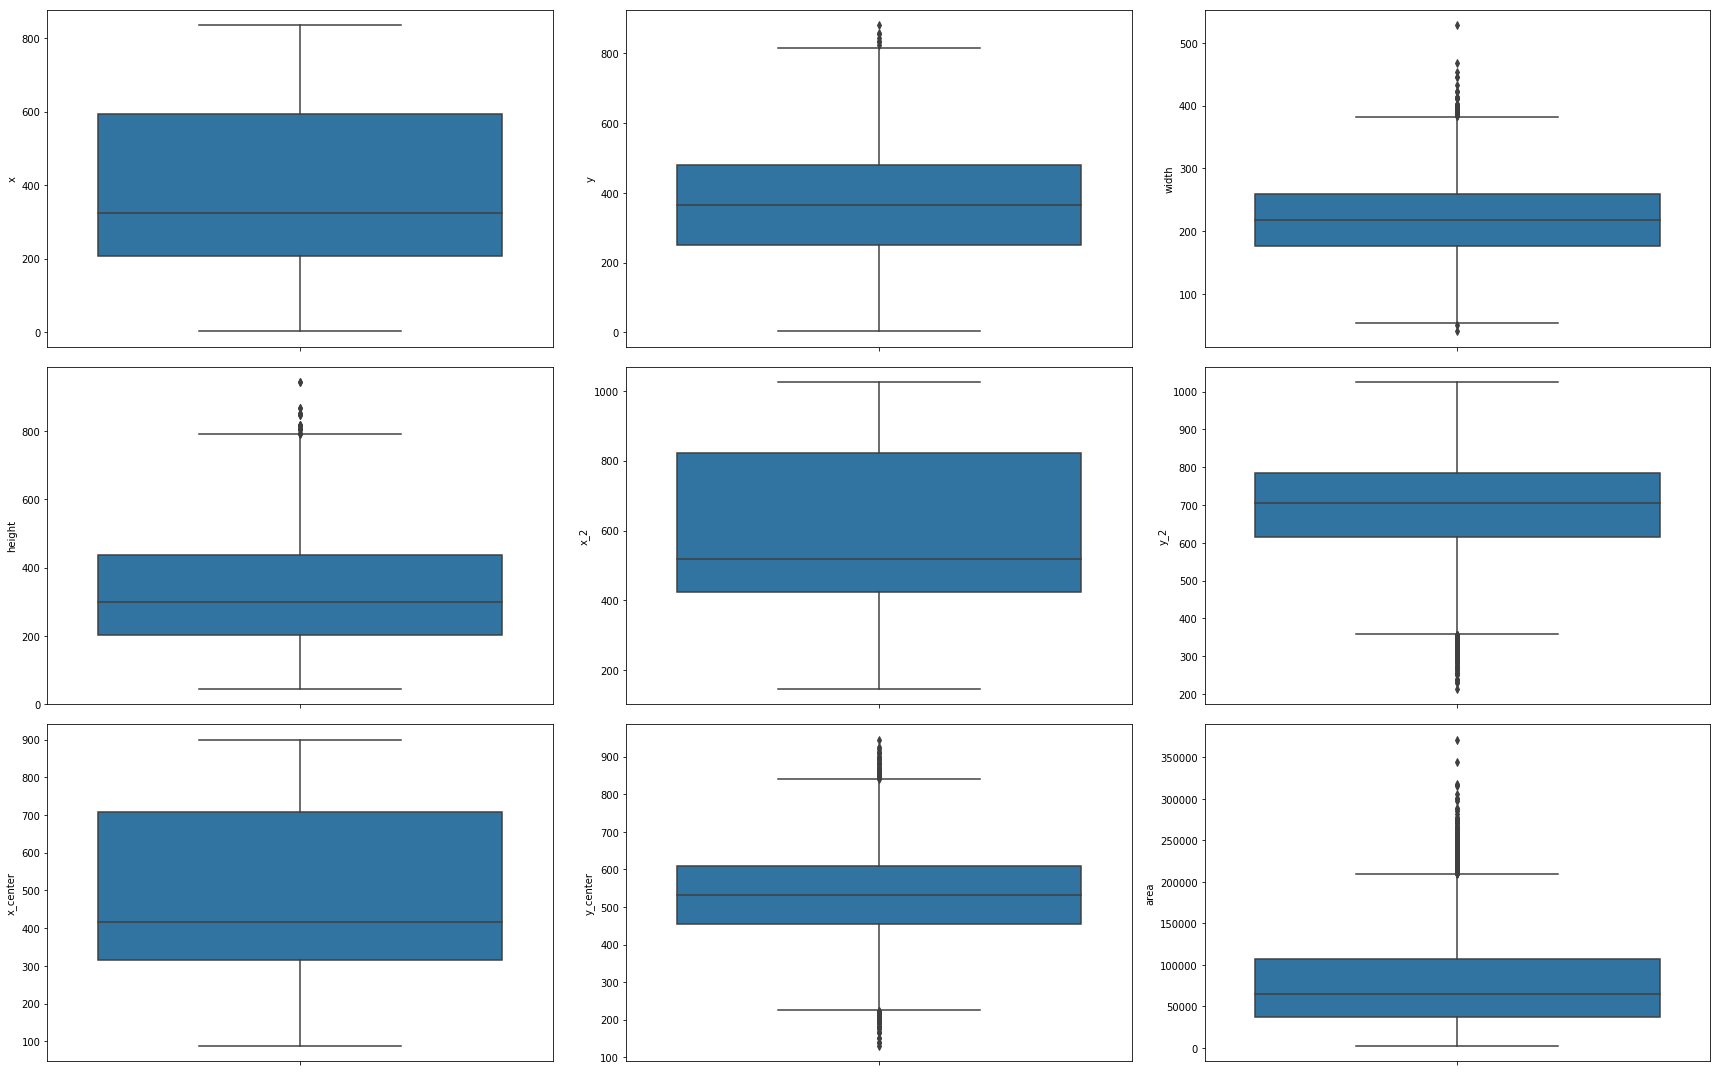

In [19]:
n_columns = 3
n_rows = 3
_, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 5 * n_rows))
for i, c in enumerate(df_areas.columns):
    sns.boxplot(y = c, data = df_areas, ax = axes[i // n_columns, i % n_columns])
plt.tight_layout()
plt.show()

In [20]:
df_areas[df_areas['width'] > 500]


,x,y,width,height,x_2,y_2,x_center,y_center,area
928,226.0,189.0,528.0,703.0,754.0,892.0,490.0,540.5,371184.0


In [21]:
pid_width = list(df[df['width'] > 500]['patientId'].values)
df[df['patientId'].isin(pid_width)]

,patientId,class,x,y,width,height,Target
928,097788d4-cb88-4457-8e71-0ca7a3da2216,Lung Opacity,226.0,189.0,528.0,703.0,1


In [22]:
df_areas[df_areas['height'] > 900].shape[0]


2

In [23]:
pid_height = list(df[df['height'] > 900]['patientId'].values)
df[df['patientId'].isin(pid_height)]

,patientId,class,x,y,width,height,Target
5791,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,Lung Opacity,87.0,104.0,310.0,793.0,1
5792,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,Lung Opacity,549.0,82.0,280.0,942.0,1
6185,3e62e51c-befb-4a66-b28e-fc469b19e4a8,Lung Opacity,148.0,87.0,366.0,867.0,1
6186,3e62e51c-befb-4a66-b28e-fc469b19e4a8,Lung Opacity,620.0,82.0,335.0,942.0,1


In [24]:
df = df[~df['patientId'].isin(pid_width + pid_height)]
df.shape

(30222, 7)

## Analisys of meta information


In [25]:
df_meta = df.drop('class', axis = 1).copy()


In [28]:
dcm_columns = None
l_patients = len(df_meta['patientId'].unique())
for n, pid in enumerate(df_meta['patientId'].unique()):
    dcm_file = '../data/%s.dcm' % pid
    dcm_data = pydicom.read_file(dcm_file)
    print (f"pid:{pid} {n}/{l_patients}")
    if not dcm_columns:
        dcm_columns = dcm_data.dir()
        dcm_columns.remove('PixelSpacing')
        dcm_columns.remove('PixelData')
    
    for col in dcm_columns:
        if not (col in df_meta.columns):
            df_meta[col] = np.nan
        index = df_meta[df_meta['patientId'] == pid].index
        df_meta.loc[index, col] = dcm_data.data_element(col).value
        
    del dcm_data
    
gc.collect()

df_meta.head()

pid:0004cfab-14fd-4e49-80ba-63a80b6bddd6 0/26681
pid:00313ee0-9eaa-42f4-b0ab-c148ed3241cd 1/26681
pid:00322d4d-1c29-4943-afc9-b6754be640eb 2/26681
pid:003d8fa0-6bf1-40ed-b54c-ac657f8495c5 3/26681
pid:00436515-870c-4b36-a041-de91049b9ab4 4/26681
pid:00569f44-917d-4c86-a842-81832af98c30 5/26681
pid:006cec2e-6ce2-4549-bffa-eadfcd1e9970 6/26681
pid:00704310-78a8-4b38-8475-49f4573b2dbb 7/26681
pid:008c19e8-a820-403a-930a-bc74a4053664 8/26681
pid:009482dc-3db5-48d4-8580-5c89c4f01334 9/26681
pid:009eb222-eabc-4150-8121-d5a6d06b8ebf 10/26681
pid:00a85be6-6eb0-421d-8acf-ff2dc0007e8a 11/26681
pid:00aecb01-a116-45a2-956c-08d2fa55433f 12/26681
pid:00c0b293-48e7-4e16-ac76-9269ba535a62 13/26681
pid:00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b 14/26681
pid:00f08de1-517e-4652-a04f-d1dc9ee48593 15/26681
pid:00f87de5-5fe0-4921-93ea-914d7e683266 16/26681
pid:0100515c-5204-4f31-98e0-f35e4b00004a 17/26681
pid:01027bc3-dc40-4165-a6c3-d6be2cb7ca34 18/26681
pid:010ccb9f-6d46-4380-af11-84f87397a1b8 19/26681
pid:011d6f

pid:05f88159-8c6e-4d9a-92a8-a20c6fb2930d 164/26681
pid:05f9a259-1b07-4e83-8e30-6b01f3ae1cf1 165/26681
pid:05fa458a-9e6a-4e02-b85c-c8d67c3161cf 166/26681
pid:05fb0374-ab2d-4cf4-bb36-ce56fb2c28a5 167/26681
pid:05fdba93-7205-4bff-ab67-649684bff036 168/26681
pid:05fe70c1-4cc1-42fb-9303-083fd29dac0f 169/26681
pid:05fe7d73-5c8c-4349-88c4-2071a00d6d81 170/26681
pid:05ff7ddc-3fb7-4378-ac14-a10a08c64aaf 171/26681
pid:06089341-a69b-4777-817b-041be894b436 172/26681
pid:0609cacd-b9a6-485f-a6f1-5bb7b88db8dd 173/26681
pid:0609fbd5-ef5c-4fdc-a51d-9fa0f05ea481 174/26681
pid:060c4f8a-f04f-4f46-88fc-3d0b90f3608c 175/26681
pid:06155af4-88f1-48b3-8860-27578f1b2e04 176/26681
pid:061628a9-8a6d-4e01-8f26-b7a6cca2b13d 177/26681
pid:061664a4-6a23-4cb2-a0da-0c5712b6e0a6 178/26681
pid:0618a5bc-196d-4afc-9ac4-d0aa940c6e03 179/26681
pid:0618f099-05dd-41d8-bf4d-b5ef8400c2e0 180/26681
pid:06199c4d-5f6f-4736-81b1-07bf5b76bd78 181/26681
pid:061b44ff-fd22-473d-853f-81da70e14a63 182/26681
pid:061bb9bf-13c6-4ea0-bd82-576

pid:0755dd30-bcc6-4f75-9cf9-914962477fca 326/26681
pid:075686e1-bfe5-4901-b326-1a082ed6b937 327/26681
pid:07586610-21e3-45ff-ad4d-d7e2d19c9a33 328/26681
pid:0759abcb-6e42-4837-956f-d4e8a4cd3537 329/26681
pid:075ba3ee-9545-4f5b-8d97-e6d0ffd57e3b 330/26681
pid:075d258f-013e-488f-9bd5-ab473413a1b4 331/26681
pid:075f24e4-0d8e-4606-8e68-ee5ea0b953b5 332/26681
pid:075f7167-e5ac-4c3d-954a-33576cb50600 333/26681
pid:076149ed-e1a7-4424-b283-18161c95e0e2 334/26681
pid:07624954-ac9b-42d4-9de3-9d35a18df062 335/26681
pid:076ad555-8eff-4022-9c08-7205c59a75d2 336/26681
pid:076c5f9e-787b-417c-8639-07639b581102 337/26681
pid:076eab63-d75d-4272-a5d3-13eae02f2c8f 338/26681
pid:07701659-5766-4828-bb65-27d208a42daf 339/26681
pid:07705011-0d7a-46b9-ab51-b4d5f2bd495f 340/26681
pid:07752357-2f21-4e42-9015-27886b3d5857 341/26681
pid:07755c77-1391-49f1-8fdb-832082887aec 342/26681
pid:077780cb-eb05-478f-a7d7-f0576e4c34df 343/26681
pid:077783a3-b299-441f-aa87-d903d5f042d2 344/26681
pid:0777be71-3ed5-4d03-a073-d34

pid:08e237d8-7d4d-410f-b48e-1e2817df9aac 487/26681
pid:08e31c62-d3bb-4f18-8e78-78e276494ba3 488/26681
pid:08e483d6-4e5d-4685-9dfb-d1befb56a31f 489/26681
pid:08e84251-b9cc-47e7-9486-be7becdd1d84 490/26681
pid:08ec2d3b-bc62-47c6-b0ce-632f8dbbdb21 491/26681
pid:08ee8fda-45f1-4f46-a5ac-315a8d4dd196 492/26681
pid:08f095ca-158b-4c84-81c1-8f2cd7e20184 493/26681
pid:08f17660-dc61-4a5d-b6fb-10dacc1e20a2 494/26681
pid:08f1b734-cd93-42c0-b978-9e1e1021bb55 495/26681
pid:08f580ca-6c0e-47ca-9759-851b3c0bb397 496/26681
pid:08f9a388-c195-4b33-8acd-e05d4da14585 497/26681
pid:08fa5211-04ae-4150-b006-9683187f67d3 498/26681
pid:08fda39f-ba68-45cc-9bbb-d416b19c6dc2 499/26681
pid:09009286-a589-4fb9-8c2c-540e16c75481 500/26681
pid:0902e0fc-fcf3-40b5-ac04-c3ecc14c2355 501/26681
pid:0906b366-f454-4c62-88fc-caf7ffb5d36b 502/26681
pid:0906c2ce-d3a7-43ad-af1b-1dadf70d8cc4 503/26681
pid:0909a8b0-09e7-4a78-9bfb-417a61c6723c 504/26681
pid:090abf67-66f4-413b-ac4a-bfad36e07e1a 505/26681
pid:090f0fcb-98c9-4324-9857-3bc

pid:0a628951-4482-4d01-a09a-9e590b886cf2 648/26681
pid:0a62df77-7459-4acc-9cca-a62c2cec4b0f 649/26681
pid:0a63a331-3e17-4e23-8a9f-f7a4ec850a1b 650/26681
pid:0a66f58c-f98d-41d1-89af-4e0136888e13 651/26681
pid:0a6a5956-58cf-4f17-9e39-7e0d17310f67 652/26681
pid:0a7162ad-b2bc-4132-b15a-7fdc80957618 653/26681
pid:0a72a6fe-0dde-49f0-bb65-d3d73366b83f 654/26681
pid:0a74badc-f221-4017-96a6-055ee057b57d 655/26681
pid:0a74f788-cd7e-47a5-a437-cb9a7dd00a06 656/26681
pid:0a796f83-f908-4b83-9252-e513d107be2e 657/26681
pid:0a7b0cc8-af04-4d2c-9267-6fdfb05f48f2 658/26681
pid:0a7b13a9-bcfe-4a99-b699-4c8cf6882f04 659/26681
pid:0a80033c-8a64-4810-9ecb-6013f7b0dde9 660/26681
pid:0a825a59-c034-481c-b596-9c7f0bc42c2c 661/26681
pid:0a828af6-b7c6-4757-88e4-dea54fe6cdc9 662/26681
pid:0a842feb-40ac-44aa-bcf6-d37109e59006 663/26681
pid:0a897002-2add-44df-90b3-5a17c51a6da4 664/26681
pid:0a8b9570-2684-48e1-b016-e14a6a79cd3e 665/26681
pid:0a8ccb49-debc-4e9a-b5dc-eefc3fe909ca 666/26681
pid:0a8d486f-1aa6-4fcf-b7be-4bf

pid:0bcfe7ee-ada5-48de-990b-2a2fd6c6ed15 810/26681
pid:0bd68d89-6a56-4b5e-b2f5-1be2d3665f97 811/26681
pid:0bda6a44-f304-4ca3-874a-b9f29f73da05 812/26681
pid:0bdc1ef9-6431-4164-9110-c26fe26ab2a9 813/26681
pid:0bdcfa14-a0e9-444d-bb9e-48c6aa10f393 814/26681
pid:0bddcc31-a167-48cd-bb25-d8de39719579 815/26681
pid:0bdf0a38-17a9-42e0-935f-f9240e1fab77 816/26681
pid:0bdf0bcb-7323-4aa4-ac61-dad3b1787acf 817/26681
pid:0be1f228-74f9-49f2-836e-e3caa49c9fcb 818/26681
pid:0be9dc1f-eff8-4813-bd77-b076fbfc537e 819/26681
pid:0beab473-5df5-41b5-b737-85749bf77a44 820/26681
pid:0beac0c9-331a-4aad-9cec-099aff98c399 821/26681
pid:0bed2d9d-8a11-41d9-b312-41f8c93791f7 822/26681
pid:0befe74c-5802-4fd4-aa1a-e5487d685558 823/26681
pid:0bf10e67-5532-4177-bc48-c0cb545248b4 824/26681
pid:0bf1767e-263b-443d-935f-489fe858922b 825/26681
pid:0bf374b1-dd39-4549-b573-6e69af4dd0e9 826/26681
pid:0bf44996-58da-4a12-8be1-da5c9b009975 827/26681
pid:0bf4c667-6fb1-4943-8e6a-f80914cca147 828/26681
pid:0bf4e2be-e95c-4e59-8cd4-db3

pid:0e6c2821-9ab8-46a0-8128-d8fe66b39375 971/26681
pid:0e724a83-c104-4d33-94a5-c7df6174f40f 972/26681
pid:0e7b5886-8737-4d62-a466-95a6608d59ea 973/26681
pid:0e7d0fc9-9a11-4325-91b2-bb13e40d1f1a 974/26681
pid:0e91afec-c246-450b-9f10-e07a75ae0086 975/26681
pid:0ea2d36a-4ab7-4b82-b446-8be5c4089df6 976/26681
pid:0eb6bffd-a30d-466a-84eb-d8daf93570ce 977/26681
pid:0ebc8268-df3d-45d8-8ee7-b34880c62830 978/26681
pid:0ec6b85a-de25-4870-a100-0d7ca6c798bf 979/26681
pid:0ecd1c28-bf25-4d32-979c-448356e0edb4 980/26681
pid:0ecd37a6-c1bb-40cf-8e48-1020140ae173 981/26681
pid:0ed69049-8906-4b90-8841-727a7716c42b 982/26681
pid:0edfe5b2-0ff9-42dc-9412-ac0c7ec5d87f 983/26681
pid:0ee29524-a273-4e20-a1fd-9df974be263e 984/26681
pid:0efbd9ef-d4c3-4420-924d-db1ff63200f9 985/26681
pid:0f0a1877-3f44-42f0-8905-2856078ff2ac 986/26681
pid:0f15c248-4f8c-4d9e-b39b-6e7d59b973c5 987/26681
pid:0f1644c9-4f2e-4681-a36d-af69c7ae0e6d 988/26681
pid:0f19df40-34dc-49c5-8a24-2879431284b2 989/26681
pid:0f1fced1-4c33-44b2-9009-137

pid:159b6cd1-8a7f-419a-a299-db96e99d8ab4 1130/26681
pid:159ca18a-4b95-45f5-b489-acde49608baa 1131/26681
pid:159eced6-02dd-4c88-ba1e-e34c4c9a00b5 1132/26681
pid:159ed892-8494-47c9-a375-3e5a65f0a013 1133/26681
pid:15a90af8-67cc-4e9f-84ed-547be162c04b 1134/26681
pid:15abeeb8-82e8-45fd-a334-adeba39f7903 1135/26681
pid:15aea21f-d48e-465b-a48d-fb7e4072dcaa 1136/26681
pid:15aff6d6-7bde-4876-bc89-7745b48c1b80 1137/26681
pid:15b28846-3e6f-40d1-b497-cea5abed3766 1138/26681
pid:15b66169-1cbc-40a5-bbd6-3acbad9f6445 1139/26681
pid:15b7d431-5807-468b-a561-42f63e56b845 1140/26681
pid:15b84543-6888-481e-bdb1-f177de3d1f14 1141/26681
pid:15b8b5c3-58fb-425a-99f1-1287b83bea36 1142/26681
pid:15bba9aa-1a49-4633-ac86-e8000f676d78 1143/26681
pid:15bbe0ce-b4f7-4000-9959-e2442e522954 1144/26681
pid:15bd1033-0a76-4f21-a6e2-ce3dc0ec41e0 1145/26681
pid:15bed4e1-1b6d-4224-bfe8-b044725ccd77 1146/26681
pid:15c0c631-f3dd-43e8-935c-a360155eb669 1147/26681
pid:15c181df-7b7c-47d3-ac5a-130b6047c1a0 1148/26681
pid:15c2558a

pid:16fbf1ae-c5fb-45f4-ba27-8880b5bdb1be 1289/26681
pid:16fecf77-f64c-4a80-94e9-4eaa27b78aec 1290/26681
pid:16ff6076-49e4-4e35-9ecc-2fd80c9d0508 1291/26681
pid:16fff742-c937-4b49-b7bd-b6d9f7b75847 1292/26681
pid:17007534-3a53-4933-8e85-70a439e2880c 1293/26681
pid:17029a43-0aec-4db0-9ff6-de544ff2e7fd 1294/26681
pid:1703014f-cb4e-43c2-893d-288d087aafbd 1295/26681
pid:1703df50-8138-4f31-bf88-737846994074 1296/26681
pid:17042665-a8a3-4538-a665-39126634f3dc 1297/26681
pid:1705a701-d5b2-486b-b9a3-3d5e8f580d1a 1298/26681
pid:170632ff-5466-42a1-95f3-30ea4ef63e3b 1299/26681
pid:1707921a-8b1d-419e-b5de-6e069bc9e4eb 1300/26681
pid:1709e1fe-b49b-4120-b00a-e814a8bf7417 1301/26681
pid:170a883f-c2ec-489e-8718-729060379eef 1302/26681
pid:170beb46-9dff-4fa3-9a94-d4777fe1ad49 1303/26681
pid:170f536e-0ccb-47fa-beea-1accce009fe7 1304/26681
pid:17121b03-a742-4fe8-846f-c1dfeaebcad0 1305/26681
pid:171648d9-c749-4146-8e2e-2a9aa775eaf9 1306/26681
pid:171a5174-87f8-4e0e-9313-41713f1588f2 1307/26681
pid:172062d8

pid:18494f9c-d897-4af4-aa20-e0517395ac49 1447/26681
pid:184e51c6-f33b-4b55-8c9b-b4809ad88af8 1448/26681
pid:184ef9f7-6954-4834-817b-9dc9ee976847 1449/26681
pid:184f1560-cb67-4361-88e5-17a3d8744b2d 1450/26681
pid:1851dff6-31ec-4453-9ddc-95c0aedace5b 1451/26681
pid:1852588b-b539-4f23-810d-0d4563ae9743 1452/26681
pid:18536f77-096d-4d43-8bd2-3fdf65c9969a 1453/26681
pid:1854a99c-bfc7-4f4e-8396-c97eebb20106 1454/26681
pid:18550c7a-2538-4f78-9437-a573903be31d 1455/26681
pid:1858bafe-3d3f-4fc6-84bf-e0f85ea1e264 1456/26681
pid:185968b1-eeb0-450a-8862-8cce9e6ed3ff 1457/26681
pid:185a1ee8-48d4-4387-b419-f01b76256d5b 1458/26681
pid:185d494c-3ec2-4317-bb8a-bcd0f9ce7615 1459/26681
pid:18630633-df6f-4b2c-b3df-23704d84f5be 1460/26681
pid:1863f91d-3b5e-413d-a0ac-f97a7c006334 1461/26681
pid:186b30df-a0e3-4b33-a49a-8b77f4240116 1462/26681
pid:1871337b-8e0b-4329-93a4-b0d9afc5c814 1463/26681
pid:1872758e-a516-468b-9498-632699a6c729 1464/26681
pid:1874dc77-19f2-4694-aa8c-0e1beb958f4e 1465/26681
pid:1875e3ae

pid:1b569787-f2f1-44eb-b5dd-04f9cc28cd83 1605/26681
pid:1b5c50df-36c2-4b74-85f0-84925fa63ac1 1606/26681
pid:1b66fe54-ba32-43ff-bb92-b97e3721faeb 1607/26681
pid:1b6ac013-a672-4eda-9e69-75b0628ff944 1608/26681
pid:1b8888ce-5f68-4e0a-b05f-fabe9b4da1e4 1609/26681
pid:1b8a2b4f-11e8-4d96-aa82-9493128a88f1 1610/26681
pid:1b8e0632-87bc-48fe-9c9d-8523396767aa 1611/26681
pid:1ba253cb-105f-4250-80bf-be5565bd359c 1612/26681
pid:1ba35bfc-7641-42cd-9988-260fd0f82be1 1613/26681
pid:1ba69712-0536-4311-a59d-81bd618aac1e 1614/26681
pid:1bd18b4d-879c-470a-b36a-9d883fb57268 1615/26681
pid:1bd9de29-597c-4cba-8581-83355af4c667 1616/26681
pid:1be56c93-6607-4b08-b73a-dfe4ca81f7b1 1617/26681
pid:1bf08f3b-a273-4f51-bafa-b55ada2c23b5 1618/26681
pid:1bf6fe95-9953-4e27-a71e-4dfbfa81e63b 1619/26681
pid:1c20a2ed-7081-4e30-b5f8-a329c51d14f1 1620/26681
pid:1c45bb74-d61c-4b2a-80eb-b4ab0d8ce3ea 1621/26681
pid:1c50630a-5004-462a-a613-024b3f2a2e7d 1622/26681
pid:1c6867ff-939e-4096-9738-322c4c2a02bf 1623/26681
pid:1c68a559

pid:261341d3-1df2-4cf4-b9a8-b1e02a124900 1764/26681
pid:2626a2bb-234f-4309-aff4-317f6fac9b06 1765/26681
pid:2635357b-8865-4551-9ed8-3f90b996c982 1766/26681
pid:265e9208-1dc8-4b3c-aacd-74f7a8525123 1767/26681
pid:266a1a21-27ff-4038-9327-098964c8fc78 1768/26681
pid:26727770-8a9a-457c-9c98-ce0e6bc95962 1769/26681
pid:26950e98-3b48-4d7c-b2d0-daa4249be551 1770/26681
pid:26a531e7-92fa-4b87-85ae-c520a2a1e2df 1771/26681
pid:26c15b0a-9865-414d-94b2-5349e8903f88 1772/26681
pid:26c9c155-e9b6-4c6b-8648-d155753289a2 1773/26681
pid:26d622c4-c7ec-4952-9210-7b2a2144cb79 1774/26681
pid:26f81844-b912-4911-96d0-f97d46286efc 1775/26681
pid:27036455-3da7-42f5-a0ef-ba2805d06e79 1776/26681
pid:2705edc9-b3bf-432a-b86d-04630ebd0e24 1777/26681
pid:27205fb6-5f28-4fc5-a9d8-c6748b97f4f7 1778/26681
pid:272c12da-2d1a-4616-9911-ce159cef7fff 1779/26681
pid:27313adc-1579-436e-9a83-a556fb8fa991 1780/26681
pid:274bfd01-cec9-450c-b231-1d17165cab93 1781/26681
pid:27532c20-7a0b-45b2-b229-496126a327ad 1782/26681
pid:275dacaa

pid:3011a504-67f0-4bda-b774-46cb7c38b839 1922/26681
pid:301a282d-1b12-4fa5-b4a1-d8e2ac7f70f8 1923/26681
pid:3020343a-9297-4f06-866a-8f710ff91be1 1924/26681
pid:302b8a1f-67db-40c6-94ad-d35ffcdc1200 1925/26681
pid:3036fb15-305b-4e9b-93ab-4e555a0fd323 1926/26681
pid:3038262f-ca56-436a-bdfe-7a547026fcb0 1927/26681
pid:304cd9fa-df87-4fb1-bf38-53a130dfa025 1928/26681
pid:305506c0-6074-4612-8940-943e0e4c1bbf 1929/26681
pid:306ff5d4-1ea2-4ce1-9fc7-25a98fac5148 1930/26681
pid:307e9bfc-29b2-4d3a-9a39-2ac51d7b13f6 1931/26681
pid:308eab64-517b-46f1-8865-d9566b087bff 1932/26681
pid:309f54b5-d865-4fa9-a827-a2d567cef1b4 1933/26681
pid:30a4ad6d-1407-4a1c-a58f-6cdf8dbf68d7 1934/26681
pid:30a54b96-7d6f-4557-8725-416684f8d543 1935/26681
pid:30ac4f03-d153-4c6a-a13b-e47855fcb2fb 1936/26681
pid:30b6e850-9920-4921-980a-fa2328a62d58 1937/26681
pid:30d3d2f9-4342-4ab4-9032-34d894c2cfbb 1938/26681
pid:30f237ad-d9af-4f59-921c-5a6b579dd6ed 1939/26681
pid:31102758-a5ba-44c9-b480-b744bcfcb861 1940/26681
pid:312920e7

pid:32684a31-86bc-48cc-ba45-003c4b86187d 2081/26681
pid:32696785-8a96-4e01-977e-03559d1afd71 2082/26681
pid:326aec21-e8f0-497f-9cc0-e56979c0aa78 2083/26681
pid:326d1185-cddf-4ead-8777-cf5877ba899b 2084/26681
pid:326f120e-54fa-48fa-ad82-253125c9dea9 2085/26681
pid:326f2ae5-5cd6-44eb-bc82-05d3f1aa6111 2086/26681
pid:32721abb-10c7-4797-88c6-bf47d32e95e6 2087/26681
pid:327573f4-41c7-471b-b613-50dbb86a02da 2088/26681
pid:3275fe4e-18e7-4fe2-94f9-aa0d725232aa 2089/26681
pid:32764f2f-ea89-4d7c-aa7d-e70366218270 2090/26681
pid:327684d0-5fb9-405d-826f-5c8954cea401 2091/26681
pid:327783c9-4a11-44c0-98de-3a7f2101f2bf 2092/26681
pid:327988cd-ed44-464a-88bb-a903bef4c947 2093/26681
pid:327a4509-9929-41b6-9e3d-d2bd90117d90 2094/26681
pid:327af298-ff3a-44b9-b5bf-93ab3a5abb04 2095/26681
pid:327b0e67-ffdb-4980-a5a5-da0eb0d8e13c 2096/26681
pid:327e22ca-95fb-4c16-8314-827e535694ac 2097/26681
pid:327f6fa3-c224-47b7-ae5b-6f5c54fc2208 2098/26681
pid:32827da4-939c-46de-85db-a2d75cb0dfad 2099/26681
pid:3282f02d

pid:33c80447-e65b-41f8-ad03-523b78048641 2239/26681
pid:33c88ecb-1aee-45d1-ab06-1ecd6eea7ae2 2240/26681
pid:33cf1ee8-ba24-4f0b-a370-f7e2785a904f 2241/26681
pid:33d0cdc3-7f8b-4d34-a81a-297f340136a4 2242/26681
pid:33d0e01d-6a72-4dfe-ae47-a526edf8bbea 2243/26681
pid:33d18acf-9ad3-4441-9167-e23bf9a3022f 2244/26681
pid:33d21874-f7b1-413c-8013-0b4a98d12fb9 2245/26681
pid:33d2956a-0501-471e-847f-ef9a0f4a18d2 2246/26681
pid:33d3fd41-5339-4af9-add3-848f793a7683 2247/26681
pid:33d5f226-17f5-4c1a-a5c2-423f022dda61 2248/26681
pid:33d76709-1280-4da7-8c5a-64daa504b9f8 2249/26681
pid:33da8f93-c3f9-413c-bc49-2a51f34aded2 2250/26681
pid:33dab529-a41a-4475-92e3-0d021883a128 2251/26681
pid:33dbca25-e1c9-4bcf-a8a7-4fa716e8a53a 2252/26681
pid:33dea6c5-2f2c-4164-a489-8ae440b921f1 2253/26681
pid:33df5e75-0b13-4c2b-b217-a0b32e3fc396 2254/26681
pid:33e18761-b2d9-43d1-a9f4-b16a99a2664e 2255/26681
pid:33e4e43b-054b-4537-9cd6-0fe574f7d337 2256/26681
pid:33e4f74e-b8f2-470b-8815-6ee3e94b8590 2257/26681
pid:33eda96d

pid:35129138-f9bb-40cb-bce0-927b0116faf7 2397/26681
pid:35147425-e8f1-494b-8cce-74252c0578d6 2398/26681
pid:3514e23d-3fbf-4695-9e81-ce5a83212984 2399/26681
pid:3517d4f2-175a-4ec4-a274-eda1d8189299 2400/26681
pid:3517db13-c047-42b3-849b-91b7ff5eba84 2401/26681
pid:35186ee1-33af-42cb-bfb7-e365ba943fcb 2402/26681
pid:351a2161-64fb-41c0-889f-653d320a406f 2403/26681
pid:351a2b11-fd83-40af-bdd9-114ff1a44ba2 2404/26681
pid:351d5ab2-c3a6-40ed-baf5-b4a68f45eb4e 2405/26681
pid:351fb5a8-d0ba-4467-b081-2cb45a3f88c1 2406/26681
pid:351fe1bb-2966-43a1-9837-fc9664c05266 2407/26681
pid:3525e4fa-0fef-4a06-9e09-c94b1709bbaf 2408/26681
pid:3525e9a3-8b21-434a-8aec-f216cc36b677 2409/26681
pid:3530e106-65da-474c-b3d8-b024a0b3a81a 2410/26681
pid:3533d3a6-27af-4d2b-a232-ce489a2148d9 2411/26681
pid:3537a092-af77-448a-9cfb-f28903403012 2412/26681
pid:3538b9f3-b604-4e3c-8f04-bb5b1127733c 2413/26681
pid:35394354-d37b-4d2f-89ee-152ad05a6b8f 2414/26681
pid:353a3a8c-0b05-4f05-87d9-42d0b069d664 2415/26681
pid:353e8a3f

pid:367fd23c-2b79-4984-9db2-25f44f708297 2556/26681
pid:3681ccb2-b646-46ec-a277-e0fc8499a2c2 2557/26681
pid:3685fe73-c5fe-47d6-b9ba-d433b79041d6 2558/26681
pid:3687784e-47a5-40d3-aa45-5cae7dd23e8b 2559/26681
pid:36880ed5-467f-489a-bc53-bc399f314fb8 2560/26681
pid:36898db8-3570-4740-a396-aaf6cee6b7a1 2561/26681
pid:368d0726-3481-4f66-81a2-f89bb7294ca1 2562/26681
pid:3690bde1-7419-46a5-baa2-14b88feed1ea 2563/26681
pid:3691108a-42af-48ff-ba9f-6e11c63f000b 2564/26681
pid:36946b92-64ac-4bfd-9984-e3f9b8b95bc5 2565/26681
pid:36949a19-b38d-400f-ace0-1abfe2ecfc3a 2566/26681
pid:36973ee8-995d-4966-8ac4-29a2b51aae94 2567/26681
pid:36984bda-bc42-40ee-a3fd-bfe8f78f2ddd 2568/26681
pid:3698b8bd-311e-4784-b9c3-dbe1d5296dc5 2569/26681
pid:36994bd6-13dc-405e-9f98-680a0e5b2eea 2570/26681
pid:369b5945-e573-4e49-99e8-dc608604be51 2571/26681
pid:369fef8a-d290-4b0f-a4cf-02b2690bb9b0 2572/26681
pid:36a469a1-0d5c-446f-bf20-2eab563490eb 2573/26681
pid:36a4923e-c647-4bd7-9e96-2a0e89f6d80e 2574/26681
pid:36a7f067

pid:37da4826-2d0a-41dc-8a81-720bef416a37 2715/26681
pid:37da81d1-ca9e-4ad3-90a2-cf7af05c4def 2716/26681
pid:37e04b5c-b7ad-4074-81ee-7dad137fe063 2717/26681
pid:37e5967f-8b15-4cd0-965d-2550421734f1 2718/26681
pid:37e78382-9850-4a26-9f94-ff07eab6225e 2719/26681
pid:37e921ef-53bc-4b10-82cb-82aec4555655 2720/26681
pid:37eaff2f-8993-45b8-8fb7-845e55df22e5 2721/26681
pid:37eefa29-9ff3-4c78-ac9b-0a0bb500a17c 2722/26681
pid:37f025d9-05c0-4e27-9a75-2e6a2085fa30 2723/26681
pid:37f17069-62ce-42ff-9fa4-d6a1056bd075 2724/26681
pid:37f5c61c-c395-468f-a4ea-7108343a22cb 2725/26681
pid:37f70057-7e01-4aae-8940-6712bfe34255 2726/26681
pid:37f70220-545f-4f86-bace-61f4bf052e6e 2727/26681
pid:37f917c2-68e2-4e03-afed-1d4acf054498 2728/26681
pid:37f941a9-f736-4100-a771-517c9449da9f 2729/26681
pid:37fa8cec-dec9-4772-9773-9fb2b26b041e 2730/26681
pid:37fd6daf-9d93-44a8-8818-20a423de28c2 2731/26681
pid:38016466-59bb-4364-a099-03813dd09f46 2732/26681
pid:3802b256-c042-4f52-ab00-73877c1d1a57 2733/26681
pid:38062f40

pid:39020ca4-0e5d-4b53-899d-fe72699cdfc3 2873/26681
pid:3902eb7b-6c41-4eed-910f-5eb03f58c50d 2874/26681
pid:39054eec-90f8-4fd9-80da-b0404be7153d 2875/26681
pid:39070d70-be06-4830-bf3f-2a582f985d89 2876/26681
pid:39072ec7-b587-4b1b-b63f-b5b1f36c5aad 2877/26681
pid:390dad2f-bd13-4f16-92af-4e061499eddc 2878/26681
pid:390eb7b5-2719-408a-b9ac-7ad6225c4889 2879/26681
pid:3912ec76-6f03-4ce6-8065-8e5f442a2437 2880/26681
pid:39140e99-2e5d-427c-9738-2e6d443b074c 2881/26681
pid:39148a82-bab6-4529-9e66-9b28e8110a8c 2882/26681
pid:391589be-c014-4862-ae43-84f42b030f30 2883/26681
pid:3916c02c-db1b-459d-a490-db001b4b63fd 2884/26681
pid:391a0d8a-9d87-4420-9e76-2bd87dbce5a3 2885/26681
pid:391e3cbd-2da7-4021-81e2-5ed9297fce3f 2886/26681
pid:391ea361-3ebe-4930-9645-e14740e6d58b 2887/26681
pid:391f6322-0fa0-4efa-a3ba-8c767f7f8aeb 2888/26681
pid:3921e471-1f0b-4953-84d9-0e8353ab105e 2889/26681
pid:3922a7cc-ff8d-4479-893c-b82d86109414 2890/26681
pid:39276e28-456a-46f8-b74d-42601c7ec17e 2891/26681
pid:392d05d8

pid:3a5327d8-8830-4ae2-bd6b-293f5aa42d4b 3032/26681
pid:3a54fc42-0d7a-460e-8f19-2e353a01795a 3033/26681
pid:3a570b6e-35b5-481d-874c-b5c166453927 3034/26681
pid:3a58fb6d-911e-419c-b00e-b7d29918baf1 3035/26681
pid:3a59f032-5ef9-4452-82b4-8dfddcbfe46f 3036/26681
pid:3a5b4890-bfe1-4953-add3-a1bb443d862b 3037/26681
pid:3a5c1a62-279d-4c69-b3e5-394e34518b73 3038/26681
pid:3a5db4e4-7069-4ae8-8d02-c9027c5833c4 3039/26681
pid:3a5f682b-e24a-4756-97a9-0a8758d4a88d 3040/26681
pid:3a5ff12c-56f6-4ea0-ba4e-82e49b889222 3041/26681
pid:3a601e99-c913-4b8a-a909-f15944dc3ee7 3042/26681
pid:3a61e62c-62b5-4f89-ba74-32e52ef8321d 3043/26681
pid:3a62a3c3-ad7c-4164-a473-939b599fb5be 3044/26681
pid:3a6a0da1-e18e-4850-b42a-08416939e0a8 3045/26681
pid:3a6a506f-fe68-41e0-a769-36167b84f8d8 3046/26681
pid:3a6a7fc5-350e-4d58-a8e5-397fa81e2586 3047/26681
pid:3a6aa686-b3ea-4e24-86e4-3129c520131d 3048/26681
pid:3a6bee2a-e8ca-41eb-b33f-5048b9f0e068 3049/26681
pid:3a6c8986-b679-43a4-aa31-9e9e59b5d79b 3050/26681
pid:3a711453

pid:3bb9b9b3-b086-4083-ae6f-d1f86c3eb089 3190/26681
pid:3bb9dce3-3f58-4a41-a75c-fa0748eb288b 3191/26681
pid:3bba8ae0-61b8-4682-8b16-2e08078878b9 3192/26681
pid:3bbc434c-d221-4f9e-9c91-e1740df807e0 3193/26681
pid:3bbc6b75-cfab-4524-b82d-cd0739ba6828 3194/26681
pid:3bbcfb90-b950-4502-9866-82a131651a73 3195/26681
pid:3bbe6098-7c9b-4f17-ac6b-e0c68b0e0af2 3196/26681
pid:3bbe8ee8-cb32-4b89-ac39-77ac56e063d2 3197/26681
pid:3bc44999-08aa-4429-ab87-a2958f22b2f8 3198/26681
pid:3bc56686-1c63-4d08-b2ec-8e112db205a2 3199/26681
pid:3bc8260d-31f1-45a4-bad5-06d0936f9bed 3200/26681
pid:3bc84e99-82ac-4945-8d31-0bc0cffe91ef 3201/26681
pid:3bc909dd-edaf-4482-9109-859aa1a108db 3202/26681
pid:3bcaf9a6-5613-4b1d-b538-eaf47ba4e62a 3203/26681
pid:3bd214a7-b62f-4e31-93c5-9cea5c2a8a30 3204/26681
pid:3bd52634-e81d-4365-910c-a7fb046b219d 3205/26681
pid:3bd5e45e-886d-4d51-8bc5-f7714984e7c1 3206/26681
pid:3bd6f6e0-c07a-4c22-87e7-53d60de9ad0e 3207/26681
pid:3bdd7783-a978-415c-b0eb-d57c618d50de 3208/26681
pid:3bdf49c0

pid:3d05e434-3e9c-41f2-9664-68b91045c493 3349/26681
pid:3d070009-c877-4ed4-ac80-53781cb30fef 3350/26681
pid:3d0964c8-b41f-4e3b-a871-fbaca943558b 3351/26681
pid:3d099ea0-3e99-44b6-bfb8-5478f5e3e585 3352/26681
pid:3d0b66d4-1954-4454-95e6-e3888e596bac 3353/26681
pid:3d0bca0d-9a01-4379-b8e9-3af3b021ad79 3354/26681
pid:3d0f6cce-9894-4869-a332-4dd957c458fd 3355/26681
pid:3d1a1f04-fc3b-4635-b1e5-1c7ab62f20e6 3356/26681
pid:3d1af87f-b6ad-408d-bddc-8bd1f27dd890 3357/26681
pid:3d1c3cd6-7e88-48ea-91b7-3150c2833bcf 3358/26681
pid:3d1e8f8f-b4cb-4346-b52a-d98f6a8ebb24 3359/26681
pid:3d20406c-6f09-4872-ad8f-a05d777850be 3360/26681
pid:3d21c4ce-34cb-49f2-9b7a-7465e0888a40 3361/26681
pid:3d259836-0ac3-4608-8384-ea7b8473709d 3362/26681
pid:3d2863ff-7e64-4e52-bfd0-c71cf596bae5 3363/26681
pid:3d294e57-04ee-4a84-acf5-4974a1be2c5d 3364/26681
pid:3d2acab8-4160-4aa6-8071-4ab0fa1313ef 3365/26681
pid:3d2b0b21-1b73-44b0-b495-60b5262753bb 3366/26681
pid:3d2dc6e4-e1d4-4872-a417-5f640ddbb064 3367/26681
pid:3d30e71a

pid:3e7fc50e-d9ae-4b91-909d-1ea4cc9ddcb1 3508/26681
pid:3e80d53f-1b03-4a12-ab50-6b86c49e8837 3509/26681
pid:3e80e9c7-8f9a-4da5-b084-6f3d364d6010 3510/26681
pid:3e881f10-28aa-4626-a79a-50cc014b7a1a 3511/26681
pid:3e8b04ac-40e4-499b-8677-8c0cf1c43c05 3512/26681
pid:3e8eea71-b36a-49a9-8fbc-47749ee2c641 3513/26681
pid:3e8f1321-ac53-4ecd-8ca2-5150bfafabe7 3514/26681
pid:3e94f21d-0159-4f9a-8981-3048c0be9f91 3515/26681
pid:3e9908ab-c3de-4cda-b07f-d03ef3a56654 3516/26681
pid:3e99e768-693c-481d-b0c7-535bbeaf4dbf 3517/26681
pid:3e9a7227-3806-4b23-a51a-5a193896b83b 3518/26681
pid:3e9dc5b9-1b7a-4e9f-a8aa-d28fc622f595 3519/26681
pid:3e9e02d2-673c-4a8d-bdfe-35515693ce1f 3520/26681
pid:3e9f3a6f-7f74-4534-b56a-30325bf3c3e2 3521/26681
pid:3e9ff8ec-edfa-4435-a3ef-898b09b234bc 3522/26681
pid:3ea07f33-3cd8-4a27-b680-8e1bc57aa1b8 3523/26681
pid:3ea080bf-4e81-4037-a686-fcf254a9e1bb 3524/26681
pid:3ea0b8a7-708c-4e1d-9a3e-fbac3f326b0d 3525/26681
pid:3ea0e730-1b82-4184-a4b7-b2101e40fc93 3526/26681
pid:3ea1ef34

pid:3ff0bd8f-7257-4ba9-a4ae-ae0c9f9138d7 3667/26681
pid:3ff23567-574c-4d4f-948c-9fb4591454b8 3668/26681
pid:3ff30575-fa0f-4e5c-bba6-651f4ea724af 3669/26681
pid:3ff3fc6e-bef0-4d90-a4a5-0eb40c1f7710 3670/26681
pid:3ffc2af9-eccb-488a-9d46-a72bb2ba927f 3671/26681
pid:3ffd6f8f-a701-46b4-8720-806cb7332718 3672/26681
pid:3fff0799-2364-415a-a5c4-7e16ec74a9d9 3673/26681
pid:40022fb9-150f-4758-b608-ede8b79e1bd9 3674/26681
pid:4005e782-c12e-4657-9b29-1707ee6eb08a 3675/26681
pid:4007ffd5-5e8e-403d-8755-72ecaa2fce43 3676/26681
pid:4008c30f-3e6e-486f-94d6-5b462b7f234c 3677/26681
pid:40090dc4-0071-4de4-b3b2-3dd4fe2c3a43 3678/26681
pid:400a53d8-22e5-40d1-a846-be334bc5c363 3679/26681
pid:400bc1f6-0c60-46da-bf66-80fa42c56fb0 3680/26681
pid:400c2833-e303-4822-903a-621dd055712e 3681/26681
pid:400ca4f8-95cc-4c78-acbc-c86ec651ffef 3682/26681
pid:400f9de2-ee62-4c18-8d8b-7c122b688ecf 3683/26681
pid:400fa108-3349-420d-a9b2-407a6a846401 3684/26681
pid:4010f5c0-3487-4f83-b2a1-c19ff42098cc 3685/26681
pid:4013c4b4

pid:413d1f9a-dbd3-476c-b71f-ffd23ef38b98 3825/26681
pid:413fe274-bb56-4206-9966-602859a51944 3826/26681
pid:41412fca-e51e-4829-bef6-716f727d61f9 3827/26681
pid:41429517-fd3f-4d89-b730-38077c925714 3828/26681
pid:4142f454-5785-4748-8f42-d32580595129 3829/26681
pid:41451629-06df-4c86-b93a-e9f419b9e325 3830/26681
pid:41465bf6-3a00-4ba3-bdf9-f6066857831d 3831/26681
pid:414852b7-ca70-44a7-b226-7975a2dba306 3832/26681
pid:414aa9f5-4f53-4a2d-bc27-7139f1fc219a 3833/26681
pid:414b5e30-016a-48fd-849e-c4c1dcab54dd 3834/26681
pid:414b65dc-d48a-43eb-bfe8-176b3f423520 3835/26681
pid:414e4a00-bec4-4552-92d3-7e710b367869 3836/26681
pid:414e4ca5-583d-4518-9e9a-de70d68dc8af 3837/26681
pid:414e53e1-a1ed-4ea3-a39d-a94112b6f16d 3838/26681
pid:414f23c1-9c21-41e1-a52c-8033420afc91 3839/26681
pid:4150d141-c98e-4cc1-9a13-1d417e94fffd 3840/26681
pid:41514a7f-f3ce-473e-a15d-cfd41b475aaf 3841/26681
pid:4151bad2-b56a-4c0a-9794-28b48548e5d4 3842/26681
pid:415419bd-51a7-4708-8cb9-1adcba6921b1 3843/26681
pid:41541e45

pid:42900731-1044-4fca-9641-96c7dd02625c 3984/26681
pid:4291fe4c-ccd9-463c-a29d-e4f1ef6b73ca 3985/26681
pid:42948b45-7392-4cad-b4bd-047e60ce1854 3986/26681
pid:429491d5-4da9-4342-aeea-4f5c38f3de3d 3987/26681
pid:4295050d-3a68-4126-abd2-bdf443a665c4 3988/26681
pid:42971cf3-7be4-490d-a369-cfa37a5cf39a 3989/26681
pid:42980064-dee5-4984-a807-e69f1c04c1bd 3990/26681
pid:429aeaae-6b1d-4261-8795-18ae2bffaf7f 3991/26681
pid:429ce315-0640-4a04-b241-6cdef80b5445 3992/26681
pid:429fb0ce-b3ec-456d-821e-49969d2c54a0 3993/26681
pid:42a2589c-761a-41e0-b7a4-331214140b5d 3994/26681
pid:42a6166a-2876-4821-a365-67d65f94ba90 3995/26681
pid:42a9738c-a056-4dcb-833c-8e4db6afde78 3996/26681
pid:42b2115f-9de9-47a4-805e-d3b7ce710674 3997/26681
pid:42b76231-32dc-4ed6-85f0-2ceaac56cc68 3998/26681
pid:42ba9ff6-f422-444a-932b-b030624a9c2a 3999/26681
pid:42bb3786-228b-42c0-bad2-a081993ec38f 4000/26681
pid:42be7116-b6ec-484c-918f-997abe7007ee 4001/26681
pid:42bfb1f3-9f7e-4e47-8983-49b16d73697f 4002/26681
pid:42c272c7

pid:44307e31-46aa-45e6-97b3-271fbca8d876 4142/26681
pid:44334be1-1a2c-4ef3-b1f1-d262ed5f68dc 4143/26681
pid:4436d992-c780-474a-b753-4effe7e4deaa 4144/26681
pid:4439655c-05be-4fe1-aa57-941dfd0cc3b4 4145/26681
pid:443a9c62-1b0b-40fb-bdbc-8913449b3980 4146/26681
pid:4440b14b-6ae7-400c-acc2-4268f8a8dae9 4147/26681
pid:44421e63-8523-4076-a84c-419361e28dde 4148/26681
pid:44440035-fc88-44aa-b760-59b7d3e508bb 4149/26681
pid:4444f78e-c9ec-40c3-b8e4-867279366c8b 4150/26681
pid:44468f53-0506-485c-92b2-834bac4484f3 4151/26681
pid:44476603-8ea4-4a46-83a5-a4bc90649282 4152/26681
pid:444b2847-8916-416b-a71e-f94d10e281bc 4153/26681
pid:444e8478-9c00-487c-8b75-fe72dc480def 4154/26681
pid:4450605f-7156-4887-bc65-16ea29cb254c 4155/26681
pid:44532bc2-3b6b-4d5a-98a5-b250f5c98268 4156/26681
pid:4453b294-ce95-488a-a184-acf8bc81e72c 4157/26681
pid:445492cc-077f-4d79-9804-60d8e990f28d 4158/26681
pid:4455076a-577d-4531-afed-17f91bca0ffc 4159/26681
pid:445c2799-58cc-4d3a-93ab-c8e16398e1e4 4160/26681
pid:445de2e1

pid:456f096c-2dc5-4ece-8023-9932c716650c 4300/26681
pid:4571ba1f-131f-47d6-a5c4-a5f1e2fb7b77 4301/26681
pid:4571ec5d-33a3-4a1e-8473-3b6f423198c9 4302/26681
pid:4572eb1c-0810-48c5-aa40-3c3b7b15bc4f 4303/26681
pid:457491c0-de6d-4bf1-9d74-1f9ea46b563d 4304/26681
pid:4574b254-3494-4530-bb8d-b3a80b14fff6 4305/26681
pid:45757e7f-5f42-482a-b5a1-8ec3d95e0939 4306/26681
pid:457e1b0b-89f5-4f7f-b752-fd8420414b97 4307/26681
pid:457f1eb5-65e1-4c8a-9c0f-08fc9f5a9fdd 4308/26681
pid:45800b16-7351-4fbb-a957-ab8d48a157ad 4309/26681
pid:45841aa4-bf0e-4f6f-92ef-13b0c35d9787 4310/26681
pid:4586263a-a2e0-4484-ac01-968b45a3b897 4311/26681
pid:45877324-19f1-49c8-90f2-037d0a6ebfae 4312/26681
pid:458c6251-34a1-43f1-9035-1dfa11664cd8 4313/26681
pid:458d66fd-5dab-435d-b937-3e19e5302145 4314/26681
pid:4592c69a-cc56-4baf-9594-f706290e51b0 4315/26681
pid:45931a5b-5631-4b6c-87b7-c2e75872f5a5 4316/26681
pid:459dec9a-7d3b-40a3-a6ec-5b50f84529c6 4317/26681
pid:459ef256-48ff-4456-b5f6-e2383bfbdc33 4318/26681
pid:45a1e0ab

pid:46c4f908-9292-437f-af42-4031fca621f2 4458/26681
pid:46c57efc-d199-4e20-858a-0946989f9f96 4459/26681
pid:46c629c3-b58e-4b25-bedc-c8aabd9b5ad1 4460/26681
pid:46c87cda-be22-44aa-9154-549a43ed26cf 4461/26681
pid:46c93b1a-d220-4d35-a546-13151f5c2326 4462/26681
pid:46cc86e8-f8ba-4567-9285-cd70cd10bf24 4463/26681
pid:46cda1c8-0d55-400f-8742-d695aa0e7647 4464/26681
pid:46ce3e45-c61e-44f2-a5d9-a737f7be357f 4465/26681
pid:46cfe8ef-549c-4b26-95b9-3a0b2cea22d5 4466/26681
pid:46d39cb8-d15e-4d00-8c38-63bda0e28a9f 4467/26681
pid:46d4f816-7025-45d3-a04a-659aef134db0 4468/26681
pid:46d60c88-cc89-4a8a-88ba-bcebc581513c 4469/26681
pid:46da5af2-a757-4670-90cb-5cc59c1e6d87 4470/26681
pid:46dc08fc-d60c-4578-a7f9-0a827dab7003 4471/26681
pid:46dca0c8-03bd-41c9-80b8-68fddfdd7116 4472/26681
pid:46dcbdc2-0644-4697-853b-b9da4b15e3bc 4473/26681
pid:46dce163-b45b-4b43-9f69-bd8330b2ae6d 4474/26681
pid:46e03a36-7c4a-4c20-a0b9-612e1469998d 4475/26681
pid:46e2061d-5941-4bc4-88f3-08a254aec4ce 4476/26681
pid:46e2e0d2

pid:4815cce8-5790-4c0d-9b3e-54a51a14de68 4616/26681
pid:481ac025-aeb7-4d88-b451-74ec80514625 4617/26681
pid:481cdbb6-4083-4585-be64-42ed3d459979 4618/26681
pid:481e364a-3cd1-4188-abc1-33c5816023f6 4619/26681
pid:481ff753-4106-405c-962e-a3f1c1e3bc37 4620/26681
pid:48201471-d1b2-4ddd-86eb-0cd6a898c850 4621/26681
pid:482072b4-619f-4398-9571-d9520d195406 4622/26681
pid:482337a5-eda2-468d-ba86-332065f97bbc 4623/26681
pid:48235c65-9a41-426c-b695-a01590d15333 4624/26681
pid:4823a67b-3f20-4d8e-a7c3-7d3226316b87 4625/26681
pid:482560b1-f73c-402d-97b5-7cc146682bf3 4626/26681
pid:4826f81c-399f-4474-a109-4bc3068b03d4 4627/26681
pid:482892b3-63bf-44f3-bd81-8079889f7b4f 4628/26681
pid:482986dd-d09a-4850-94d9-3a13e8d877e7 4629/26681
pid:482bd118-d57c-4bc5-8b66-0e600564231b 4630/26681
pid:4832fecc-3de6-47da-adee-11be7e213575 4631/26681
pid:48349099-36a7-4377-b280-19312e581699 4632/26681
pid:483d087d-712d-46eb-8f5f-eaa1a53ec2ed 4633/26681
pid:483e8681-026f-4e64-a140-a914b7b0e897 4634/26681
pid:483eb36d

pid:4998b1ac-db66-4e5a-96ee-10bf4662c057 4774/26681
pid:499953da-e3be-4698-b134-b74c97678db3 4775/26681
pid:4999ef1e-b2b5-4ac1-85ad-c082281c0cbe 4776/26681
pid:499b0c85-952d-42e5-86b7-8f2345098f2c 4777/26681
pid:499d40ec-e646-4e4b-a864-a95f47b10413 4778/26681
pid:499dc53c-c75e-4875-88ed-4d902353b000 4779/26681
pid:49a0c701-8e14-4651-9184-91870fdcd073 4780/26681
pid:49a26c5e-fb2f-461e-a334-e81b64fab96f 4781/26681
pid:49a8bad1-f6db-456d-bc8f-74f70557d9bb 4782/26681
pid:49b17730-d315-42bd-9045-bc8921c5abcc 4783/26681
pid:49b2fb17-b12c-4e5a-8c4a-02449027c42b 4784/26681
pid:49b4c195-df32-427a-ac69-b13d798b634b 4785/26681
pid:49b4c980-9b73-4f1d-9bfa-87c46429f8e6 4786/26681
pid:49b4f1d3-7504-4754-be82-923a7861c027 4787/26681
pid:49b680f2-3e37-450a-879f-ad38707de531 4788/26681
pid:49b751b5-ba8c-48fd-811a-a09ac4d9026e 4789/26681
pid:49b95513-daab-49bb-bc6e-c5254ab1bc07 4790/26681
pid:49b96a4d-7bfb-49f2-a31f-932371038652 4791/26681
pid:49bcf366-c1e3-4185-9626-b70108ec0562 4792/26681
pid:49bd59e3

pid:4afbc897-69d2-4074-9690-c3410ff4706c 4932/26681
pid:4afd6f26-766d-448b-a24f-7e3b7a40dd37 4933/26681
pid:4afd96ad-d8f0-46ce-b4ea-13108b5e0e93 4934/26681
pid:4affc9f8-39a1-4c8e-925d-890658b67021 4935/26681
pid:4b004c64-d809-4309-9840-bdf38aaed74a 4936/26681
pid:4b01e62b-30b3-49b4-bb17-b7791bc0bec8 4937/26681
pid:4b02a490-e730-4d4a-b17f-c6fea9c47d6e 4938/26681
pid:4b048bdc-0a0a-43ed-aa0d-5971e433874b 4939/26681
pid:4b04ae4f-7d4d-44ea-aec7-5d8e673e8ce5 4940/26681
pid:4b0b35fc-c1a9-4808-8e51-a85a0e0b78d9 4941/26681
pid:4b0cbffb-4974-411f-ae98-553830c360f0 4942/26681
pid:4b0e4413-56aa-48dd-a9ea-4712d211334c 4943/26681
pid:4b0f3bf3-fa7c-4e6d-9ef9-2d65f485021c 4944/26681
pid:4b0fe61d-df6f-4ff7-a3e6-394bcbb09267 4945/26681
pid:4b1252a3-8860-4d93-bc5d-c209f3d6e181 4946/26681
pid:4b18a44a-5d6b-4bf3-9a4b-c8f5211e4f07 4947/26681
pid:4b1a60c2-40e4-4cc5-9fb2-d0a3e4fe8a4f 4948/26681
pid:4b1bd2e0-bbc1-4cf4-8f35-565c1ab1385b 4949/26681
pid:4b1cab8a-c9bd-40e6-bc86-23c6be98a099 4950/26681
pid:4b1d3e29

pid:4c52f9c5-6ce0-4e28-ae5d-ddb37f374f31 5091/26681
pid:4c53a757-190d-40b5-9d98-cacbb547874c 5092/26681
pid:4c550090-ae85-4117-91a2-1c2976c9bc11 5093/26681
pid:4c5b4760-c989-44cc-91f2-24d2eab2507f 5094/26681
pid:4c5b63e3-d3b4-4cab-9ff6-1e4ae56fd828 5095/26681
pid:4c5d0c17-f23b-48d2-9f2c-3d9b0f05c2e3 5096/26681
pid:4c5e29bb-55e7-487b-9c4b-ca54a3551870 5097/26681
pid:4c5e8452-6bb3-4e36-86c6-b508b7cf50d6 5098/26681
pid:4c608577-dc40-44ab-9d91-c669c4c14bd0 5099/26681
pid:4c611880-55a0-4e63-a0d2-4e4901bd5635 5100/26681
pid:4c645f41-0960-4544-9ec5-706d70db8c54 5101/26681
pid:4c665597-adbc-4583-9d9a-20cc0d8d00d0 5102/26681
pid:4c66947c-027c-47a8-af4a-00fd68fdf8c7 5103/26681
pid:4c66d203-225b-4690-b516-4b8ee63eff4e 5104/26681
pid:4c69056d-3f72-4730-ad37-b76d2817ef86 5105/26681
pid:4c6bee3e-fad9-4265-8d1f-445f0baef368 5106/26681
pid:4c6bf128-c956-4a77-aadf-dc8f0f6ad4e7 5107/26681
pid:4c6c4d5f-f0f7-4531-b9b0-d52d7d59f3ed 5108/26681
pid:4c6f04e5-f7ca-4316-b5ef-70e305060357 5109/26681
pid:4c6f2598

pid:4dc96221-ca49-4d90-8630-c01d14578651 5250/26681
pid:4dca2396-aef6-459e-9827-efdd3bef8c76 5251/26681
pid:4dca2422-fef2-491f-a80f-9cc90838f178 5252/26681
pid:4dcad495-9d13-448f-8a59-ec62aab113ac 5253/26681
pid:4dcb986c-d32b-4acf-870b-342a42da7617 5254/26681
pid:4dcbea60-aaeb-4656-a64d-278d82a787e1 5255/26681
pid:4dcc0124-ba1e-49d7-a08b-8c2f23cf4bd1 5256/26681
pid:4dd1b505-fd6b-41ef-9213-f55885463256 5257/26681
pid:4dd31a3c-7825-4072-a457-dddc0f9cf3bc 5258/26681
pid:4dd61819-c62d-453f-b473-0e5f82a38e4c 5259/26681
pid:4dd73b83-0d4a-4755-934a-25c4fb06dc01 5260/26681
pid:4dd92d1d-f5dd-4163-a55f-6a6ef95aa6f0 5261/26681
pid:4dda80b9-1f21-41aa-bbf0-84bd252cace3 5262/26681
pid:4de1459a-541e-4449-bbbd-38f829c4d4f5 5263/26681
pid:4de27293-832a-4152-bc2e-38ca1d484af9 5264/26681
pid:4de71e08-58a2-4780-bf0f-24cd2ffaa6b2 5265/26681
pid:4de7f61d-0216-4103-8866-fbfd04ff4c44 5266/26681
pid:4de82994-1662-4fd2-ae76-e70667dab381 5267/26681
pid:4dea26ff-8b4b-4f0a-9902-abc62d62f2c1 5268/26681
pid:4dead6d7

pid:4f135ee9-60e0-4dc0-86e7-dd1782150a80 5409/26681
pid:4f146c9c-d0f0-41ae-b9df-e0f7a7c75328 5410/26681
pid:4f1b2e67-df6e-4c37-b9f7-fb295b343784 5411/26681
pid:4f20081c-d7f6-4516-9a3a-8a52e64ea16e 5412/26681
pid:4f204cb1-cc3e-44fa-921b-317f31b474f1 5413/26681
pid:4f25ee23-6030-4da2-b262-755b2dbe0aad 5414/26681
pid:4f2a1f0c-f70c-4e71-9681-5fe03fab3d1b 5415/26681
pid:4f2c125a-38ba-4982-8265-1b6ff5161033 5416/26681
pid:4f2fc5ae-4c6c-4022-b012-6c809e78759e 5417/26681
pid:4f3330ad-9377-47bb-9eb2-05c8bf0fa5ac 5418/26681
pid:4f33e113-e2d1-4122-8651-e937da208edf 5419/26681
pid:4f34c638-80de-4e77-92c7-87ccd0453b32 5420/26681
pid:4f36fdcd-1887-45b7-805f-2afffc3d10b3 5421/26681
pid:4f39658c-3628-488f-bf5b-e72cd13c6ed3 5422/26681
pid:4f3a8f89-c1cf-48de-9fcf-f6d6c8650e4b 5423/26681
pid:4f3ac5da-dc36-4009-8d01-0934d23a0b6e 5424/26681
pid:4f3ceb29-12f8-40f4-9511-816fa21ca683 5425/26681
pid:4f3d63dd-1e55-416c-be87-3ba5e4470592 5426/26681
pid:4f404c2b-d0b9-4c60-9ed3-b78e87fae530 5427/26681
pid:4f4289e7

pid:504747c5-833b-4cf8-9335-0dd6271ea530 5567/26681
pid:50485e1e-5074-4b31-bc8e-443cf0ebca2c 5568/26681
pid:50493c25-94a9-4f20-a8dd-682981b71919 5569/26681
pid:504cbf6f-b20a-4a8b-8d78-e4016bada396 5570/26681
pid:504ce437-0f1c-497e-a9b8-af0fc9ba08b2 5571/26681
pid:50533ed3-bfb4-4e56-82f7-678e03864265 5572/26681
pid:5056edf1-969a-474e-8780-a73e7bdd45a8 5573/26681
pid:50571327-a1ea-425d-8de4-aec08900a99d 5574/26681
pid:505a5b16-5b8a-42d0-a693-52b20b46a2bf 5575/26681
pid:505ab47d-f99e-458a-9ba0-fc4fecd76760 5576/26681
pid:505cd489-6d6e-47da-827d-81270e582660 5577/26681
pid:505db6f2-1a55-4766-b72d-120d1a6dfdee 5578/26681
pid:505e0ee9-25fc-419f-b913-7484ea070647 5579/26681
pid:505e3473-fe7f-4c3e-8684-b7f9ecf1d052 5580/26681
pid:505f2e1e-81fb-4351-be2e-d421a805bbb6 5581/26681
pid:50637d07-1432-49dc-9606-4db4005cf72a 5582/26681
pid:5065efd1-6ffd-4c35-9833-53f7885c3808 5583/26681
pid:506792d8-848b-4ed5-ae27-000f116aa3b4 5584/26681
pid:50691612-2d64-4d61-8d67-bba6836392ce 5585/26681
pid:506b475a

pid:51daa411-4fb0-42f0-aa15-46c332656c04 5725/26681
pid:51db6790-fd3a-4148-8dcd-efd11efadcdb 5726/26681
pid:51db7c4f-198d-4ed0-9cb1-d267564c491a 5727/26681
pid:51e19fac-9f6a-41f2-8cb4-4820a427e7b5 5728/26681
pid:51e49fd4-6198-4b96-ac8f-299231671a17 5729/26681
pid:51e7b3a0-60c7-4dc1-83d6-93eb441a93d2 5730/26681
pid:51e7f8d7-2904-4651-a3e3-be6e8d351cfc 5731/26681
pid:51e88086-33ab-478c-b215-d198b94c1523 5732/26681
pid:51e9d4d8-3c7e-4ad2-95ce-22aa2ff7da7e 5733/26681
pid:51ea5b97-a5a2-4ba0-9090-b85214c43c04 5734/26681
pid:51ec83b5-5fcd-4085-9cd6-f2d1d24210c2 5735/26681
pid:51ede844-da2f-45a4-81c3-8b7f798ba017 5736/26681
pid:51f43763-2c98-4809-853e-adf2eb9e80ba 5737/26681
pid:51f46b01-a6bc-432e-acd7-5a8e8732a883 5738/26681
pid:51f4bcbb-43cd-459e-b731-8a35fb06e5dd 5739/26681
pid:51f540ba-aad8-4e1f-bc8b-7373d3d23ee2 5740/26681
pid:51f68c41-ad1f-4440-aaf2-b8d7440fbec0 5741/26681
pid:51f72917-146c-435a-8bea-cf4d1896997e 5742/26681
pid:51f85d4c-7d59-4657-86f4-96a24ebd1549 5743/26681
pid:51fbcba7

pid:533dd19d-7bd4-4178-9c3c-b10f0e44fd33 5883/26681
pid:533f6423-8465-41f0-aa07-34518dacb8b6 5884/26681
pid:533f6b0d-6e60-44d4-93fa-29c777e6278c 5885/26681
pid:5340047d-295c-4b89-aabf-03889f4acb42 5886/26681
pid:5341f2bc-e62c-433a-80b8-439035520842 5887/26681
pid:5342f3b9-cb1f-498d-8974-8b771e359b7e 5888/26681
pid:5344ae10-10d7-4b35-b602-a97dbff359ef 5889/26681
pid:534dd305-b5ae-4200-9e77-0662f9094d4b 5890/26681
pid:534eae67-8907-4c4e-9b18-39d94e297dfa 5891/26681
pid:535049a0-5af9-4cdb-8b37-cba346f91ec2 5892/26681
pid:53517578-a6f5-4822-94e0-e605746afe7d 5893/26681
pid:5352be11-df67-4929-a91a-9412dcb54e2b 5894/26681
pid:53553403-f449-4bf1-9d54-b76827ef7ffc 5895/26681
pid:535782ec-911d-47a8-acb9-140b2405e288 5896/26681
pid:5357e032-1642-4006-8a46-c1124b67ae33 5897/26681
pid:535a94be-e39f-4a14-b260-61aca4570c17 5898/26681
pid:535c2337-e755-43ea-ab1d-6547a584776d 5899/26681
pid:535ed71c-ca04-40b0-a830-afc4f806bc03 5900/26681
pid:535f82fb-907d-42bd-b737-667571fff4b1 5901/26681
pid:53633336

pid:54862509-2480-4d58-99b8-7e6fe993875b 6042/26681
pid:54895691-ee84-4f0e-b22d-e8e63f8598d4 6043/26681
pid:548b0ce7-2797-4d24-814e-d419d2e82fb6 6044/26681
pid:548b6120-8289-4283-9849-3969e25d1f4c 6045/26681
pid:548e83f9-d4ed-4c1c-9b53-0449ee709fb0 6046/26681
pid:548ee990-ae0c-4307-87f3-f92912c7951c 6047/26681
pid:54902e87-004a-4acf-a0d3-b680514fe0b2 6048/26681
pid:549200e0-f78f-403b-b67f-9b7e3ea927a0 6049/26681
pid:5492dac4-a895-4e35-9c0e-aa787a48aa1a 6050/26681
pid:5494bfea-2292-4b0f-933f-64139dad5fa7 6051/26681
pid:549618db-d06e-4b93-b415-b698984cb229 6052/26681
pid:549795e5-3bca-442e-8828-c50f8838df22 6053/26681
pid:54992aed-342d-4ef3-b938-ed89aea56d7e 6054/26681
pid:54998746-d18c-4f2f-81c3-e2fb11d1f8d5 6055/26681
pid:549ee5af-e19d-4483-9f7b-d3025dbb1979 6056/26681
pid:549f95a2-c418-4414-b822-f4c9447cf87b 6057/26681
pid:549f9df8-168d-45dc-9c94-81e3ee9bd8aa 6058/26681
pid:54a075e0-572a-426f-89dc-00b32a9c5637 6059/26681
pid:54a2c7b2-89dc-4f5a-b148-41be979cf90b 6060/26681
pid:54a32eda

pid:55e6396f-23e1-4553-a2be-a825dc70a57a 6200/26681
pid:55e8ab4e-b6c3-4424-bae7-3b17849a1141 6201/26681
pid:55ea944b-984b-4f0d-a84d-e6b8b6660edc 6202/26681
pid:55ee9345-8d62-4380-87e6-a6df8adaa8a9 6203/26681
pid:55f2867a-5c49-4ea2-a9d7-9f8bb977222c 6204/26681
pid:55f2e30e-005f-4aa3-b4bf-f16ac2b8c11f 6205/26681
pid:55f92991-e880-42d2-b347-362f5d136e10 6206/26681
pid:5604ca1d-a3de-48a5-a574-2f3f0662d8fc 6207/26681
pid:560500cf-ae14-40d2-bd14-5b1ac7f95ebb 6208/26681
pid:56067473-2508-4ffa-be6a-7f70f3ea17cf 6209/26681
pid:5607261f-5c02-4b04-932f-a0efe4235c5d 6210/26681
pid:560903a5-8450-48a9-8751-e84bc57492fb 6211/26681
pid:560994a6-904c-4ba5-acbe-fb4bba7dad25 6212/26681
pid:561075e2-b494-422d-9eca-060b89fae03e 6213/26681
pid:561143bb-f604-43a4-850f-b350a42a6e81 6214/26681
pid:5611941b-09f2-4f1a-a383-9053bd749e27 6215/26681
pid:56130832-8cb2-4c91-a98e-a40b1f1d1dd2 6216/26681
pid:561b07c0-4b16-4948-b343-d3282c85cea4 6217/26681
pid:561d7cbc-240e-4c5a-874b-0cc07cadefff 6218/26681
pid:561d7e11

pid:575b4e6f-99ce-4827-b7f7-866d8f4015ca 6358/26681
pid:575c312c-82f3-406b-8945-2b37da0364ae 6359/26681
pid:575c9f22-01b6-4a3b-bce0-f5cb8d3a391b 6360/26681
pid:576429a6-dd25-472b-ad28-8a8e09f32bb3 6361/26681
pid:576449ae-263c-4519-9094-854e86ca9424 6362/26681
pid:5765974e-3a9c-4128-8e54-7f24e74113f3 6363/26681
pid:576a7e67-815c-47fd-a603-fcdab510ac78 6364/26681
pid:576aef9b-1e70-4b06-b84d-a3e17a077167 6365/26681
pid:576c787c-993e-48ce-9a7b-9ee90661a0f4 6366/26681
pid:576d42dd-fb6c-45f0-8245-1808f0a8b07f 6367/26681
pid:576f3fdc-8864-4709-b72f-a7b33fee8435 6368/26681
pid:576f691f-ec9f-46a3-9f06-0b72c9702d8c 6369/26681
pid:5772e6c1-1117-448f-bf55-e57599fedcde 6370/26681
pid:5772efe6-5336-474e-a619-d2d5529fa316 6371/26681
pid:5774a68f-e370-4522-a1c2-cc03e2bfb3b6 6372/26681
pid:5776da6e-0b5d-4d8b-a9fb-2a8af858d424 6373/26681
pid:5776eae9-886b-4027-bcec-4ade9a431014 6374/26681
pid:5777035e-6415-45c0-a12c-b85f01256574 6375/26681
pid:577c1d51-14c5-450c-b936-33e259a1bca3 6376/26681
pid:577dc65c

pid:58ad2808-fae9-4079-99b7-3f3eae239cac 6516/26681
pid:58adddbd-2331-4d93-bd95-f6325e1ea3d0 6517/26681
pid:58b049d6-b48c-4edc-ac83-753591aa359d 6518/26681
pid:58b27c0b-8635-4c71-9c4b-babe51801da4 6519/26681
pid:58b9904a-1e44-40ea-86a6-c0b9d32899f9 6520/26681
pid:58ba9b95-3218-497a-ab76-20950d731f15 6521/26681
pid:58bf27e0-a307-4d29-a977-511340f4572f 6522/26681
pid:58c2439a-ed5a-493d-b8d3-bf57d08af322 6523/26681
pid:58c317a1-291e-4bfd-97ad-297688bf530e 6524/26681
pid:58c3c006-1f48-458f-b469-4afcef2b8e76 6525/26681
pid:58c4329e-c507-43a9-beed-26c49b1c9da9 6526/26681
pid:58c76b9b-8d86-49b2-8fb1-101e7c6af075 6527/26681
pid:58c929c1-50fa-4b59-987c-3d5a11750fb6 6528/26681
pid:58cbbc5a-4d66-4c43-8def-b407ec2ce8a9 6529/26681
pid:58cf20bd-7e42-4be4-8599-d37c819bfd82 6530/26681
pid:58d1ec20-645b-4bed-a31e-1f08051a90c0 6531/26681
pid:58d2d2b4-4bce-40ae-8993-a26390e128ee 6532/26681
pid:58d2ffd9-f5a7-4215-9ca8-3b41536a989a 6533/26681
pid:58d71b03-41d0-4009-aa4f-e192589dd41e 6534/26681
pid:58dc9082

pid:5a18b41e-6e23-4fbe-a55a-ef6cfb027b0d 6674/26681
pid:5a1c22b5-f8e8-477c-934c-9c347d7b29bc 6675/26681
pid:5a1edc6c-b8a9-4b7f-870a-4e5f867cca33 6676/26681
pid:5a220a92-bf26-451f-826a-6886460f7671 6677/26681
pid:5a23151e-fceb-4d74-82b1-803bf1234450 6678/26681
pid:5a29bf0b-e88c-4c2a-a793-6a84c9cb9856 6679/26681
pid:5a2efed9-8132-4de5-bf6f-c73c7d014530 6680/26681
pid:5a2f1408-caa2-4f0f-b14e-71ee713dc737 6681/26681
pid:5a2f8c86-f21d-4815-98a3-1bb5fa6d9f44 6682/26681
pid:5a2fc23d-facb-4105-bf35-ba87ccc78eaa 6683/26681
pid:5a30d39a-979b-4646-a17a-87a8e6fe5322 6684/26681
pid:5a3560b6-3460-4f9f-a429-1a0ebbcee520 6685/26681
pid:5a38a30a-650e-4112-879a-fa387aae1b20 6686/26681
pid:5a3e37e9-4d7e-40a8-9bc2-cae06b295351 6687/26681
pid:5a4042ff-dbda-4278-a556-206e7d723a51 6688/26681
pid:5a497d5a-808a-4e0b-951a-334efb497229 6689/26681
pid:5a4a8c72-7042-41af-9869-32cb8d493110 6690/26681
pid:5a4ba729-d074-4991-ba3d-9247f17db955 6691/26681
pid:5a4cd916-a4a4-4e7e-abf9-cc124cb692f9 6692/26681
pid:5a4d1861

pid:5ba9f6a7-9f57-40f8-9168-1bb1841e65ff 6832/26681
pid:5bab9e56-d8ea-47a2-8848-fd768e4a52af 6833/26681
pid:5bace529-66de-4eb0-bede-4da1c4aed9cd 6834/26681
pid:5bad55a2-06e1-4ee9-8fbd-555a1f75e647 6835/26681
pid:5bae90dc-76ca-4096-b3f1-f50ab396bfe9 6836/26681
pid:5bb0a3ba-b725-40c9-b1b2-e518382c3c38 6837/26681
pid:5bb67504-f09e-49f7-9c4c-03b43f034fa1 6838/26681
pid:5bb6cb82-684b-4e51-ad4e-c70ee3a61efe 6839/26681
pid:5bbd21a8-cae8-41c1-b140-fe05fcd669a6 6840/26681
pid:5bbf0c9e-e651-46ff-9472-5b2c43ecc80d 6841/26681
pid:5bbf70ac-8665-4b3a-b07c-554e618883b7 6842/26681
pid:5bc12970-af13-48bb-bd12-a5cc72fb7154 6843/26681
pid:5bc4887e-e2c6-468c-9372-6227649e4fca 6844/26681
pid:5bc6b92f-0a89-453d-8e0c-32566bbea8e3 6845/26681
pid:5bc74cc9-674d-461f-ac57-f355f118ad46 6846/26681
pid:5bcc2f5b-46d9-4e87-bfc5-b4808ec4f13a 6847/26681
pid:5bcc3bbb-bdc6-4a10-97e5-7041ae36ca1e 6848/26681
pid:5bcdcaca-248f-44e3-bd75-da2bee9287ef 6849/26681
pid:5bcee483-ed6d-4e9c-b9db-1e48e5bb2403 6850/26681
pid:5bd07c9a

pid:5d0a2c0f-b152-46fb-be4d-e435b36d5002 6990/26681
pid:5d0e05a6-389f-4be7-b91c-8fbebfc79ec6 6991/26681
pid:5d10c9a4-48bf-42b4-b561-871ce4a80ccc 6992/26681
pid:5d133a79-b67d-4ba1-972a-cb3dcfc725bb 6993/26681
pid:5d159a16-07cc-404a-bc12-7d6283ee9b9a 6994/26681
pid:5d15bb3c-8eea-4894-b5a1-6bd75c171f04 6995/26681
pid:5d1aa00b-9896-4ae8-aef1-92618c1844cb 6996/26681
pid:5d1bd7da-95d2-46b5-8e3e-126de41e1ebb 6997/26681
pid:5d1c02ee-d8be-411e-b89b-f7175833204b 6998/26681
pid:5d1d1eb6-1c43-416e-b280-7aa689c4589a 6999/26681
pid:5d1d4b97-459b-457a-b7cd-729c494ddb60 7000/26681
pid:5d21a43a-9be2-4489-b15c-aeb4bb682f8c 7001/26681
pid:5d21cecc-051e-4ac9-aaf3-12394e3ad6ae 7002/26681
pid:5d22272d-01db-4754-ba62-d2722763c933 7003/26681
pid:5d256814-d5bd-4f0f-89f6-5f111574be94 7004/26681
pid:5d2690ea-6ad7-405c-b320-27be55889413 7005/26681
pid:5d26f70c-8d1f-4a15-a618-c28ae3323c1a 7006/26681
pid:5d270645-9eaf-4198-9505-8335d0095ff8 7007/26681
pid:5d2a83c3-3af0-4bac-a412-09dfecc682d7 7008/26681
pid:5d2ac0d8

pid:5e67cab7-41f5-4708-a6a1-37000ad8bc52 7149/26681
pid:5e6b7518-c9d5-4981-bfca-d5e4597e2a02 7150/26681
pid:5e6e07b3-53be-4896-bb9e-0c35f0fc3409 7151/26681
pid:5e6f2c90-aaec-44ef-b29c-86518b6f22a6 7152/26681
pid:5e70d50b-1b44-4ae5-8c7f-f66ebda228f0 7153/26681
pid:5e7119eb-01fd-4797-8125-b71320d1efd4 7154/26681
pid:5e714740-505b-482c-8894-73694e929506 7155/26681
pid:5e73b305-4101-4b73-bbbc-047055469c11 7156/26681
pid:5e764528-946f-49df-85d5-6d0ae98a3223 7157/26681
pid:5e79685b-7bcc-49d2-986c-e3d07a319a3a 7158/26681
pid:5e7a197f-e287-4d83-8094-9d7eee2d1269 7159/26681
pid:5e7dc013-d5f5-48f4-a9d0-02d0f85f9557 7160/26681
pid:5e7e89b8-3c68-42de-99af-a4aa10a9e8d1 7161/26681
pid:5e7ec991-4363-4310-a019-989e045b79de 7162/26681
pid:5e874185-b532-48ca-953d-2fcaf4402688 7163/26681
pid:5e875cfe-01a5-4433-a953-f460c315838a 7164/26681
pid:5e87c22b-dcda-4e24-aedb-113216cf5dbf 7165/26681
pid:5e88a086-2f27-461f-baf3-4b36976d6687 7166/26681
pid:5e8c5295-6749-4e4a-8f4b-b770140fc529 7167/26681
pid:5e8cb001

pid:5fb1f7f4-d9ee-45d0-b335-fed129ce68dd 7307/26681
pid:5fb43479-d9a4-4c32-bed3-f63ae1462216 7308/26681
pid:5fb4a30f-84be-4fdc-81eb-e6616e1568ce 7309/26681
pid:5fb64e85-62ef-4852-8ad1-f799015c8cc3 7310/26681
pid:5fb80d4d-2b6d-4f26-a75f-5df4895f5779 7311/26681
pid:5fbb1924-a341-43b8-89c1-c3a8ef256d66 7312/26681
pid:5fbe960d-68e3-4f36-9563-7773563f3523 7313/26681
pid:5fc016ad-3edb-41db-94c6-0ea98490d793 7314/26681
pid:5fc43445-7ce7-49ec-9bb3-c768966056df 7315/26681
pid:5fc4c038-98f2-485c-b86f-63508d589cab 7316/26681
pid:5fc756b1-4714-4631-b9e1-f365b59cd8d8 7317/26681
pid:5fc8af1b-7ebf-4d50-bf28-005bcdf83560 7318/26681
pid:5fc96a31-b996-4998-b0ab-b4cac726693e 7319/26681
pid:5fcaa9d7-232e-43f1-a6b3-e0b23fa21152 7320/26681
pid:5fcdd172-e1bd-4975-a054-9b6ad2133cc9 7321/26681
pid:5fcedc49-0859-40de-9666-1064593ca760 7322/26681
pid:5fd71b69-86d4-4fba-bb0b-1fbfc4a58f01 7323/26681
pid:5fd7477f-327b-40e8-9ce3-cb9b7dedbf45 7324/26681
pid:5fd88893-6d79-4bb9-9ead-c5111c3de622 7325/26681
pid:5fddb73b

pid:6111379f-790e-4957-9729-56ac4bb53d54 7466/26681
pid:6113a040-1600-4525-adbc-c5415959ebaf 7467/26681
pid:611522e7-12ba-4273-ba44-f59f4df0c88b 7468/26681
pid:611a0f56-9463-4b3b-87ce-c856a170c14f 7469/26681
pid:611a59c3-68d4-48fd-84d9-74f67339b5e1 7470/26681
pid:611a6d3a-3c10-4fe4-9bd5-af17ba537486 7471/26681
pid:611aac41-d471-4689-9732-610d88abb3e7 7472/26681
pid:6121d7b6-8d47-45d4-9706-bd42ae676534 7473/26681
pid:6126c957-5789-4264-86c9-9fe21c0498b9 7474/26681
pid:612892af-2ac4-4da7-befb-c9bd18be97a2 7475/26681
pid:6129213e-1ab7-465d-a84d-e871246fa712 7476/26681
pid:6129c27a-0271-4480-ba7c-4b302c022861 7477/26681
pid:612b6527-d54b-4d84-9915-a36bfdc7901d 7478/26681
pid:612bb584-9bff-4740-96d0-24e7c114be15 7479/26681
pid:612c89df-cde3-4bea-9263-8b8b69e98866 7480/26681
pid:612de393-7238-4bcd-b45f-04feae29b257 7481/26681
pid:612f076a-270e-4bb2-b761-69d22ff52f43 7482/26681
pid:613217ca-45ba-437c-97ad-0d30025ded6c 7483/26681
pid:6135977c-f19e-4a7f-9e11-6fe03805e750 7484/26681
pid:61366af6

pid:628a4414-2476-406c-891e-94efe24e4033 7624/26681
pid:628a64f3-01e6-48ae-9430-57e5a4f7b188 7625/26681
pid:628b5d45-db3b-4d2c-9deb-f10795950543 7626/26681
pid:628bc700-14a6-496c-b555-f07625699843 7627/26681
pid:628cca99-9eb5-43e0-84ab-8a8f113aae55 7628/26681
pid:628d8457-2bfc-464f-ab09-4068bd9c6a5b 7629/26681
pid:628eea1d-9db2-4a99-acb3-0d846c3ac48f 7630/26681
pid:6290b473-9935-4ef7-bb8c-3144e48377c0 7631/26681
pid:6292f3d6-392c-4a60-8b6e-57b0bda52429 7632/26681
pid:6293bf2f-7dbe-4676-9f55-70682922fd4f 7633/26681
pid:62946b4b-efbd-473b-a878-833b04ccc016 7634/26681
pid:629594c7-fe69-44d5-aa85-907b50661f0b 7635/26681
pid:62974b0f-cf3d-452d-b038-7e9ded3aa5cc 7636/26681
pid:629778e6-9644-45cf-b19f-d926b1e7eb2f 7637/26681
pid:629b01a0-5d99-4756-aacc-fadedf5a2ee1 7638/26681
pid:629c147a-375d-4776-a230-57ef6892468f 7639/26681
pid:629df578-2436-419b-9393-8ed83e2bda8a 7640/26681
pid:629e7870-ff09-4de8-b5d2-1c36baf22ad9 7641/26681
pid:629f59dc-5e5b-4c71-8201-308827e78873 7642/26681
pid:62a0ba68

pid:63d7f897-ea58-4883-b88a-6a98e92f8a73 7783/26681
pid:63daff08-6af1-4f59-b438-773c688af1ee 7784/26681
pid:63dd0d7a-28bf-4690-b7c4-1ba114f18cf3 7785/26681
pid:63e1e099-ab0b-4ef4-91a8-36a47e422aab 7786/26681
pid:63e7e31e-5872-4215-a384-d25fff4c1b81 7787/26681
pid:63eb7c63-4d93-4fe9-8877-1105c0ca31e3 7788/26681
pid:63ec0f9c-054b-494e-ac23-29b36e6b438a 7789/26681
pid:63ef3455-8f9c-47d2-a1c5-1a4c55221aee 7790/26681
pid:63ef9b68-0489-48bf-8a97-77d2c92a9c5f 7791/26681
pid:63efbaf9-13bb-498d-80e1-fed27bb7506e 7792/26681
pid:63f29622-7924-46cf-bffd-3508875ffbcf 7793/26681
pid:63f71157-7db6-476f-b320-ba2fcbe2543f 7794/26681
pid:63f851ea-b371-46fa-985c-6dfc4ecf043e 7795/26681
pid:63f8fd6d-67cb-4cbf-9812-029156e77046 7796/26681
pid:63fac8bb-6d04-4e04-b57c-2311eb376acb 7797/26681
pid:63fb7926-b7b4-4bbd-b47f-5aad34846ad0 7798/26681
pid:63fe1ae4-bd2d-4777-9dfc-8683aba56460 7799/26681
pid:63fe2b52-2b1e-4c81-8787-fd505ae97c37 7800/26681
pid:63ffaa0f-b764-4d5c-8462-8935d6389bb3 7801/26681
pid:6403ef2f

pid:651e8ecb-52ac-492b-8026-9e4a16873b11 7941/26681
pid:6520137b-c98c-42be-9689-dbce52e1df6b 7942/26681
pid:6520ba7e-243c-4be7-b7c6-0005a16788c0 7943/26681
pid:6520e11d-e078-498a-9aa2-599eaab152ba 7944/26681
pid:652122ac-42a4-483d-beb1-60d37753b289 7945/26681
pid:65225798-dc6e-469e-8010-427accb9e41c 7946/26681
pid:6523f381-773b-4b2f-96af-8969b01bdd89 7947/26681
pid:65241f19-4023-48d2-9672-72565b1310f2 7948/26681
pid:65247f5b-027f-4cff-95aa-f424dfeef259 7949/26681
pid:65262e28-0c9c-4429-beb5-91610049272e 7950/26681
pid:652ad17a-ef73-4068-a1bd-005ec867386f 7951/26681
pid:652b519d-5eb4-4abc-93f7-15ae661a431f 7952/26681
pid:652cf0c2-fed4-407c-8bd7-94d7e8787b35 7953/26681
pid:652d6bb3-56a0-4a89-9631-684ce27cfc4c 7954/26681
pid:652ef311-c8c4-44c9-8d0b-2c890a97c2fa 7955/26681
pid:652f37d5-445a-4700-8937-9efd52353641 7956/26681
pid:6531f746-dcdc-465b-a8af-64945c4d8efc 7957/26681
pid:6532bb94-e270-48be-bbb8-6e527de0300e 7958/26681
pid:65336113-bed0-4b8b-b6eb-a56aef061389 7959/26681
pid:6535af98

pid:666a7b13-452f-4c63-9713-cb80e2a183ee 8100/26681
pid:666b0b84-6cab-47e4-b0df-2cffbb42de9a 8101/26681
pid:666c91a0-ebe2-4487-891b-8105e902ede0 8102/26681
pid:666d06c9-eff3-4936-8673-f058961d392f 8103/26681
pid:666dc889-847f-491f-ad5e-300f859dd70a 8104/26681
pid:666f9f95-9c84-4065-a828-3a02f60e175b 8105/26681
pid:6670ddd7-80da-4ffe-a216-3fa7c1c741a5 8106/26681
pid:66720b7d-bbe2-4acc-b81a-02f5017187fb 8107/26681
pid:6672d139-1fd5-42d4-9c2c-55b25002e6ed 8108/26681
pid:6672fc85-4989-4327-830e-be03415373ed 8109/26681
pid:66745e3d-c11c-487e-ba87-c27d19929462 8110/26681
pid:66746759-ffd8-4020-a20e-e268efed5a86 8111/26681
pid:6677d92a-03a7-4aa7-b040-43d5e16bb379 8112/26681
pid:667abd72-cb0d-4258-877b-7dcfad5e76e3 8113/26681
pid:667eca17-25d0-4d29-ba3c-6e4f5cf5f9b0 8114/26681
pid:66811487-9791-4a70-a560-b9d0b586c4b0 8115/26681
pid:6682410e-8b7b-45a4-b36a-bb3e5bc6939a 8116/26681
pid:66830592-46b6-4907-9c06-845338b63fa2 8117/26681
pid:66871bb1-8352-41d6-85e0-b84f339561d2 8118/26681
pid:6689ede5

pid:67abb6ec-929a-4e85-879f-e963d753a14a 8258/26681
pid:67af68f7-7ba0-49a0-a373-3a8801eb0faa 8259/26681
pid:67b006cd-ea64-4d06-9ce4-e19134e2cb21 8260/26681
pid:67b322d7-88d3-457f-ae58-66d416684a6b 8261/26681
pid:67b78cc2-ddb2-4a2d-a595-20c126309a5d 8262/26681
pid:67b858ef-f3ff-4c13-b473-3d8ec8ef889a 8263/26681
pid:67b8ef8a-5285-4eec-88c8-8f4fe53f0f6e 8264/26681
pid:67bb2550-c8eb-405c-a96c-7e820dd247de 8265/26681
pid:67bc7433-4582-493a-af6b-82d0383d9c32 8266/26681
pid:67bda6e9-0606-4653-ba20-5f48fa5e5b19 8267/26681
pid:67bde75b-1e5b-4697-a639-786524a36306 8268/26681
pid:67bf005e-6939-47c6-a73f-8eeec0df47bb 8269/26681
pid:67c15bfe-00c9-4911-bf32-6d99df399dcc 8270/26681
pid:67c1c533-d61b-4670-a297-513f03efcb21 8271/26681
pid:67c4416b-89e7-40fd-a1a9-3155979fcf6b 8272/26681
pid:67c56270-819d-4c3a-8688-5caa6208225d 8273/26681
pid:67c85c48-cceb-406e-900d-a76083578981 8274/26681
pid:67c8fe1f-1823-4ccb-adae-f87ea3193425 8275/26681
pid:67cba87c-af3f-4399-876b-64d8e4c6e512 8276/26681
pid:67cbdff5

pid:691f01b2-60b0-49ad-847a-f2dcdffa22ec 8417/26681
pid:691f5a2a-73e9-40b2-aa76-aac6ee7e0b2d 8418/26681
pid:6921f629-de79-437f-9ac6-155713cfbbe1 8419/26681
pid:69220eb7-f35f-4620-9a62-cd5478fc9f99 8420/26681
pid:6922deb4-3824-43cb-b636-7ca579e4d64f 8421/26681
pid:6927a615-8ec4-4219-aa92-e368d628cb2e 8422/26681
pid:69285af2-863d-44ad-80fe-3ecadc128775 8423/26681
pid:692a79a2-5d94-4f0b-8b30-e7f8b21e45a1 8424/26681
pid:692e6a56-4cd6-4500-8712-2e647c43bb1d 8425/26681
pid:69316024-89de-4120-9c51-517130bf56d0 8426/26681
pid:6932c7f9-5e3c-45ad-a8cc-b62069803150 8427/26681
pid:69333c71-1675-48fa-a1d7-5a7d122293f4 8428/26681
pid:6934cab5-fab6-4db9-a432-59754ea124dc 8429/26681
pid:6935a34e-a97b-4c65-a635-800ed5745c15 8430/26681
pid:6935efd0-e78e-4a8a-ada3-9bf8f4cc15eb 8431/26681
pid:69399256-522e-4404-a4ff-67f49c711f8e 8432/26681
pid:693ad3cb-222c-4f84-b5b8-c3310061beb5 8433/26681
pid:693bfe22-dff4-4f4c-9ade-09dcb1babbb6 8434/26681
pid:6946f198-8ee1-4a54-b6eb-3390f3c43554 8435/26681
pid:69482e41

pid:6a5b9fe0-bcea-4f37-b2a5-df9b27793028 8576/26681
pid:6a5d183e-915d-4493-980a-84e0a3810bc4 8577/26681
pid:6a5d55af-fc99-4957-9404-f08e4150dc55 8578/26681
pid:6a5eeedb-f8f8-4c18-88ce-e392a91270f7 8579/26681
pid:6a61e542-fc33-4d8e-8c09-8443528cc63a 8580/26681
pid:6a61fbb1-d1cd-4e02-a616-5340291556b4 8581/26681
pid:6a6247f6-5131-47e0-9f40-a2cc4b85503a 8582/26681
pid:6a64c194-635e-4ab0-aefa-aeb2be0aac53 8583/26681
pid:6a64e1c5-e1ce-4624-8532-a7d0109ca2fa 8584/26681
pid:6a66b5bb-54f3-46b0-9675-9d137cb3f895 8585/26681
pid:6a6a1253-1b0b-49d2-ac38-f5823de76c9a 8586/26681
pid:6a6cb2f1-eb9f-494e-b927-f4307af57060 8587/26681
pid:6a6d8bb5-cfbc-4e3f-a812-9765fe83d72f 8588/26681
pid:6a6db20b-bb3a-4c61-8c67-bc5ce432c50b 8589/26681
pid:6a6df4ea-7a2d-4e5d-9092-d8870a19ec86 8590/26681
pid:6a6ed2c5-d179-4c19-aac7-0d70eb87e024 8591/26681
pid:6a6f4940-affd-4a05-ae69-665ab2f0ac96 8592/26681
pid:6a7238bd-db2b-4a24-92a3-e6fc3ab076d7 8593/26681
pid:6a74515e-f0db-43f7-93a5-51f0eb25b126 8594/26681
pid:6a778bf7

pid:6b78d3dc-4db6-4ab9-9e7b-2d91dff9c4c2 8734/26681
pid:6b7debe4-f52b-428f-8e6c-9df32423387f 8735/26681
pid:6b7e0ce7-a08c-4d69-bdf1-7a807ce434b4 8736/26681
pid:6b7e32d8-0a3c-4050-a6eb-7db2e451c4fb 8737/26681
pid:6b7e5283-5730-4689-9429-97384be4b2a3 8738/26681
pid:6b7e80f9-5942-4227-a88d-bc97820711af 8739/26681
pid:6b80c461-49ac-4e42-af05-bbc7fcb1e0ad 8740/26681
pid:6b82bee3-afeb-47da-8db2-7a0195438d3b 8741/26681
pid:6b83a374-ede5-42b3-82a7-f72d3bf9247a 8742/26681
pid:6b85ca20-da92-4ee7-ab30-37eda9dffb6c 8743/26681
pid:6b86453b-f659-484a-85bf-fb696998691d 8744/26681
pid:6b8884f1-abcc-4285-97e9-d70e867e1545 8745/26681
pid:6b8d3d46-3815-455c-858a-1c0ea33a302f 8746/26681
pid:6b8d5e97-37cc-466b-820f-1089972f1bf3 8747/26681
pid:6b8fc53f-1bcc-43a7-bf36-410011feca4b 8748/26681
pid:6b905bae-fbbb-4f8c-a939-080872e4fd64 8749/26681
pid:6b969591-8a07-49ed-9f65-fa19a453df59 8750/26681
pid:6b98cb48-d6f6-4854-921f-1be1a3b85401 8751/26681
pid:6b9f7b91-8530-45e3-be03-e2f2c0b0a708 8752/26681
pid:6ba2c851

pid:6cb0dab9-dcde-450c-95c5-6bc1dafc2423 8892/26681
pid:6cb10b66-69aa-4bd9-9001-20f8355f818d 8893/26681
pid:6cb2fc15-f04c-4fcd-be3d-a964d1467401 8894/26681
pid:6cb48d9a-fcc1-47d8-948e-5fde543b41bc 8895/26681
pid:6cb97627-f00e-4fad-a90e-f9f09ef28d24 8896/26681
pid:6cba26dc-51c2-4a3a-bbd7-3af8dd5bfd65 8897/26681
pid:6cba9620-0510-452f-bf0e-59b5bb1b7815 8898/26681
pid:6cbc978a-50ee-46b4-b0b7-5201b50d19b5 8899/26681
pid:6cc1f886-40b7-4459-9e08-32d4e5c39276 8900/26681
pid:6cc52f7b-b56a-461d-8b3b-721ff750df6e 8901/26681
pid:6ccaed40-444e-43b9-ae7e-e66fdf41e082 8902/26681
pid:6ccd59f5-36e2-46db-b029-e1068cbabd49 8903/26681
pid:6cceaf55-c53d-4732-9436-85db3e219a62 8904/26681
pid:6ccf77da-c917-4fc1-8bf7-f0e7bfd3acf4 8905/26681
pid:6cd06a0e-f49a-443e-b616-1808561347a3 8906/26681
pid:6cd8ee4e-60ef-484e-b242-93009537142e 8907/26681
pid:6cda5173-edbe-4020-a64e-2a3b75b13283 8908/26681
pid:6cdcd463-82a4-45b7-b780-ef366f9ecc62 8909/26681
pid:6cdd079b-2995-47a2-b440-8d89b141afc0 8910/26681
pid:6cdf200f

pid:6e0d9ed7-09d6-4089-b214-2f6c0f45913b 9051/26681
pid:6e0dbf20-7070-484e-937d-629f59838638 9052/26681
pid:6e0e18b6-462f-46e8-bded-d39b628ac13d 9053/26681
pid:6e0f6f55-effa-4743-a858-6f2f2e1f4ec0 9054/26681
pid:6e101be3-5cb0-4109-941a-56730bbc5ca9 9055/26681
pid:6e108fd0-3d57-4c27-a7ab-16d9de2b4c70 9056/26681
pid:6e166f1c-2999-4bd2-a8fc-01c8522aeaf0 9057/26681
pid:6e16da29-aeea-415a-80a0-34a9937345b4 9058/26681
pid:6e1764e6-6915-42d5-a893-e29a2fe69b30 9059/26681
pid:6e1d50f6-0065-422d-9f93-8680627d6835 9060/26681
pid:6e1f5ce5-a624-4d13-9088-1d769440599a 9061/26681
pid:6e2174d4-d2e8-421a-9577-109160d053eb 9062/26681
pid:6e22e938-1cb8-4c9a-89fd-c97e43452826 9063/26681
pid:6e26360c-3342-449c-907a-803c06d59830 9064/26681
pid:6e26a7a8-38f8-47d9-935f-35a553aec844 9065/26681
pid:6e290df1-5d27-4de0-aba7-374ffe59baa8 9066/26681
pid:6e29410d-4578-446e-8d04-a9f4dfa911db 9067/26681
pid:6e298e09-6e9d-44cc-a696-7ea7a15f626c 9068/26681
pid:6e2aacb3-74b4-4909-afd1-5e9765df303a 9069/26681
pid:6e2cd79b

pid:6f5756a4-71c9-4c21-9107-b6163537b213 9209/26681
pid:6f5859fe-9eaa-4a4e-bb4c-217596812fef 9210/26681
pid:6f5d9135-ffc5-4076-872d-ba8a5bf7e8e4 9211/26681
pid:6f5eb191-d7ee-472e-b08c-e6975896f5c4 9212/26681
pid:6f5f67f7-0ad5-41f7-9e53-0db96f09e48d 9213/26681
pid:6f5ffab1-0aba-4307-9318-860fae535d42 9214/26681
pid:6f648895-e84d-40a7-a8cd-b3c0d9677a91 9215/26681
pid:6f6afc4a-cc1d-49ba-a986-c170e38c7c00 9216/26681
pid:6f6b253a-54ad-4b30-aa6e-581f3f32065f 9217/26681
pid:6f6cda1b-3cc0-4fc4-bf39-20ca11b11778 9218/26681
pid:6f6eea6d-aeca-48ad-a730-ba52981111cd 9219/26681
pid:6f6f2177-304d-4174-ad65-7b163f492c33 9220/26681
pid:6f756510-22e0-4961-88e4-1084dc90ee22 9221/26681
pid:6f7a739a-c48b-4236-a349-22d18192f905 9222/26681
pid:6f7ad9a6-aeb8-49ec-ac6c-0bdbcf28fbd6 9223/26681
pid:6f7b0bc7-c23d-44fe-a0c5-bffd10ddf11f 9224/26681
pid:6f7e8d86-a408-4aa5-a503-d9cdcf5303c1 9225/26681
pid:6f807ac6-073c-400e-b698-a14af89a57c6 9226/26681
pid:6f84e6cf-b9ee-43d2-ab56-eae54adbcb88 9227/26681
pid:6f851425

pid:70db87e6-4e7c-4afe-8bd9-a6870c67aee5 9368/26681
pid:70df055d-95ca-4ea1-bae5-d98a6a17aecc 9369/26681
pid:70e0719d-3ab0-4e00-8cb7-e8d85ef6df4d 9370/26681
pid:70e095f4-26ea-4e9d-8589-93c389186d50 9371/26681
pid:70e3331c-8717-4ff6-b2b5-0fefe6336bdc 9372/26681
pid:70e39c46-09d9-40b5-8cde-147046a52965 9373/26681
pid:70ea8245-fcd1-4ebc-a330-9d92c6f74a5b 9374/26681
pid:70f0205c-dd20-4caf-8d3b-b2f8354d1e0b 9375/26681
pid:70f14ca7-41a0-445f-9274-fe0a7b8890be 9376/26681
pid:70f201ac-a1a4-44b6-a99d-86018378b3ff 9377/26681
pid:70f5e68f-a4fa-41ea-9213-e71cf71b67a7 9378/26681
pid:70f79c35-d01f-4a9c-9fe1-87133892682a 9379/26681
pid:70fa8756-5de7-4c3e-86ff-3664c9016364 9380/26681
pid:70fd3f0c-f79f-4cbd-893f-c1d6b80b7af7 9381/26681
pid:71019686-932a-4b7f-b567-54d6020affc6 9382/26681
pid:71041150-5565-445f-9211-d1e42bc8dde5 9383/26681
pid:71043372-1241-4da3-a470-e0e7585f668c 9384/26681
pid:7105d840-ed2b-42fa-a32c-ba10ff3604bb 9385/26681
pid:71069ed0-4e0e-4afd-8fdb-d35863770c87 9386/26681
pid:7106dad7

pid:7215f3e0-f549-43f2-8fb7-9202b133d142 9526/26681
pid:72163e9a-c43f-456e-98a0-ba822f729a7f 9527/26681
pid:721c7144-49a9-4cfa-8a47-8a1227063093 9528/26681
pid:721ca747-d0c2-45c2-adf3-4c3640034519 9529/26681
pid:721ca9d9-ef3e-4fda-84c3-bd9f7a7645aa 9530/26681
pid:721ce331-5526-4469-ba71-84f7880021e1 9531/26681
pid:721fc482-f306-447f-9f18-0a3c7400f370 9532/26681
pid:72247058-293a-4a90-a972-093fe8f12148 9533/26681
pid:722503cf-a801-415b-a10e-848bfea55911 9534/26681
pid:7225472a-ab4b-46b1-9fd1-f88e5fa9fd45 9535/26681
pid:7227e6d8-8eb3-40a6-80a5-27950bc9ce97 9536/26681
pid:722816d0-3d58-4fbc-8e0f-a2ef699efbc6 9537/26681
pid:7228bf11-3ce7-47f5-bee3-d36325df1dc8 9538/26681
pid:72290038-af8f-4ebc-ae08-1cbb558ada40 9539/26681
pid:722ad9c3-919a-4c08-bb67-cafd603ba754 9540/26681
pid:722cca4a-f542-47ba-be14-29238c1124e1 9541/26681
pid:7233ab9f-7fa6-4b5b-acdc-1c93bf945db5 9542/26681
pid:723515df-a2b9-4f89-bb3f-437e364bc726 9543/26681
pid:7237e36e-e4bc-4d5d-8497-e891cecac5c9 9544/26681
pid:72388847

pid:737c7eab-7194-4130-a010-954ea6e321e3 9685/26681
pid:73827f0b-0bc9-47eb-8249-14621ad77f5a 9686/26681
pid:738524e2-9e98-43cb-8c56-b480a2a0ae2f 9687/26681
pid:738705eb-6964-4542-b9ec-009ef849822e 9688/26681
pid:73872731-6970-4490-a23c-afe09c751429 9689/26681
pid:738eef14-e57e-4659-9c3c-48f1d645b06c 9690/26681
pid:7391faa9-e52c-4a10-bcd7-56d286c9aee2 9691/26681
pid:7392b2a6-6be1-4965-9077-0c44fd7cbb30 9692/26681
pid:739597a4-836a-4591-8ef2-f912a5822a44 9693/26681
pid:7399adbe-2b59-4f62-a919-0a1c9c0d9548 9694/26681
pid:739b6cca-cb26-437c-9409-f66474a95eed 9695/26681
pid:739bd043-d62e-41ef-bf20-20ed762dca13 9696/26681
pid:739d9cfa-978d-43ac-b635-6a782c52a307 9697/26681
pid:73a0777c-caaf-405f-80ab-342715b384c9 9698/26681
pid:73a53464-7183-4a5e-ba1d-f2c014d1511a 9699/26681
pid:73a59a79-acad-42c5-8b91-b22ff7939cbb 9700/26681
pid:73a993d6-3f86-447d-bfb8-9dbf87be0a66 9701/26681
pid:73ab0684-4fe8-4223-8b4a-29d50e607111 9702/26681
pid:73ace93d-59b5-4895-91d7-cbe632e3a024 9703/26681
pid:73ad70a9

pid:74e774b3-ca7c-47c7-b580-393f6a432206 9843/26681
pid:74e8bd5d-687f-4c95-b2a5-e1568ab8a7f1 9844/26681
pid:74ead0c4-bddb-4660-8831-210c9c5b8d9e 9845/26681
pid:74eb29cc-33a7-4ad4-b420-a4f4ba34cf19 9846/26681
pid:74ed4f73-33e6-4607-8842-57aec6c318c6 9847/26681
pid:74ef566d-21ce-4b66-b134-a713ca915762 9848/26681
pid:74f02a21-db6b-439d-b17d-81c23120374d 9849/26681
pid:74f0cc41-4b2d-4294-8bab-47bd0584b05c 9850/26681
pid:74f427aa-a1bd-4eed-86de-2755158efcd9 9851/26681
pid:74f58c95-43cd-4dac-ab6e-de270adf1d4d 9852/26681
pid:74f62860-c882-47f2-9e9c-1f63588cee5e 9853/26681
pid:74f69a44-9224-4c14-a6a4-cffef6d1a757 9854/26681
pid:74f72d5f-15de-4f6c-9dfa-89cfd3c1acf1 9855/26681
pid:74f8f310-cc0c-41ff-871d-8daadb81bbcd 9856/26681
pid:74fa6abc-1d7c-494f-b025-1c42ff421cdf 9857/26681
pid:74fb09f1-f085-4759-aa14-e951de845919 9858/26681
pid:74fc0444-3b29-4b22-8e3d-6a92f87f725f 9859/26681
pid:74ffdc4f-388a-4829-b240-19a7d2e8a1a9 9860/26681
pid:75026295-2eb4-45e9-b745-db0fcf1eacb4 9861/26681
pid:7507bb99

pid:76395224-8088-45c6-bf15-270c8aaea2c5 10001/26681
pid:7639c65f-52bf-4040-8907-729964dc5563 10002/26681
pid:763adcfd-4ebf-4d3b-91bd-a7813dc4bb96 10003/26681
pid:763b843f-f415-4868-b089-d8034ced2918 10004/26681
pid:763bc9c5-3d0b-4f02-bb13-bd18a8ef920c 10005/26681
pid:763f991b-5a8a-47d0-9b9f-151cc661218d 10006/26681
pid:76475cee-e9c1-42e3-b4a4-a79e2d0ed39f 10007/26681
pid:76487cbf-9dd3-4e1e-b2f6-57c86d408317 10008/26681
pid:764a566a-d5a2-492e-8568-26e0e20ac774 10009/26681
pid:764ae03e-966a-48d2-ad73-bdbe10274eea 10010/26681
pid:764c665f-f7f8-4c20-8849-01b6159ce28b 10011/26681
pid:7652391c-ea5f-4100-bb55-53ce130a0dd8 10012/26681
pid:76545b14-5b1c-42dd-9727-4baeb5212d94 10013/26681
pid:76554e2a-f033-436b-82ff-ff3e223e5feb 10014/26681
pid:76561551-efee-4492-bbd1-8465560ab1ed 10015/26681
pid:7658ef50-d386-4066-92d9-5d5735af5f3c 10016/26681
pid:76593c1c-e1a7-4ad6-b478-c71e4226368b 10017/26681
pid:765c5980-ee79-45a1-b784-1e4bd26c027a 10018/26681
pid:765f5d41-e660-4b45-97ed-0eb22390b720 10019

pid:77a50626-2a5d-44a8-8013-af001549b769 10157/26681
pid:77a63356-c61d-4912-8cfc-9eddb705c46d 10158/26681
pid:77ac8942-4ce0-4447-84e8-af5aa5bc3f88 10159/26681
pid:77aead0b-3112-411b-ac8b-71b9b8fad3ee 10160/26681
pid:77b4b295-c277-42a7-b210-b236ea42274e 10161/26681
pid:77b4e9ec-9002-444f-b3a5-9e5ab9dacaa5 10162/26681
pid:77bcb2f3-2dfb-4ed7-b88a-b21ad2c87df3 10163/26681
pid:77bcca2d-6e54-4ce1-887f-f5d2628a7f1a 10164/26681
pid:77c10182-8222-4824-aa46-9afec3d539ca 10165/26681
pid:77c162cc-c628-4a88-8471-bffb87891442 10166/26681
pid:77c19750-2f89-4c77-85f9-6e9494e5e842 10167/26681
pid:77c2e795-4c2a-4daf-b288-f24fac8a3758 10168/26681
pid:77c35cf0-33fa-4851-9e84-bee7a6034a6e 10169/26681
pid:77c809fd-1fb7-4dae-a0e6-33408425eb92 10170/26681
pid:77c828fb-8cf7-4953-a964-6a566f3d07ec 10171/26681
pid:77d7ac47-8290-4617-a855-56cdf8245e86 10172/26681
pid:77d82c92-f380-4e26-b39d-b43d5c814833 10173/26681
pid:77d84839-722c-4b89-aac7-2337214b7a4a 10174/26681
pid:77d8f15c-4686-4898-93eb-ad80ea92a803 10175

pid:78fbc1ca-cbae-4b4e-926c-cd94acbfe1dc 10312/26681
pid:78fc7340-87d9-46b4-81bc-2bc2dd5de8cb 10313/26681
pid:78fe9142-9b8a-4200-9b2d-129a4e30e7ec 10314/26681
pid:79001124-36d7-4eb5-b68c-7dcd7d8f54cf 10315/26681
pid:79010956-1b3a-407f-94e5-33194d77b61e 10316/26681
pid:7901b0f0-3a78-403a-b3d4-945d81fa6886 10317/26681
pid:7902a47d-8a23-4f7e-9089-1b851091bb07 10318/26681
pid:7907faad-9e9f-4690-bf76-420ff9b64f7e 10319/26681
pid:7908d3ae-c10c-4bc1-a256-42a6b16e90d0 10320/26681
pid:79137c4d-9ec7-458e-872c-918afe670912 10321/26681
pid:79168e4a-a98b-4c27-affc-0fade7c2aed6 10322/26681
pid:7918b5a8-0e82-43e9-ac13-70472f297d88 10323/26681
pid:79197c53-7622-48f4-a3ae-916be7696c0a 10324/26681
pid:791a687e-c45e-4772-bdd4-0a9d6301d994 10325/26681
pid:791e72c5-ecb4-43bc-aeda-7756af052534 10326/26681
pid:79255e97-c107-47ee-918c-6eba3081f3bc 10327/26681
pid:7926adbf-0b36-45c4-8d4f-a8e5159ae5bb 10328/26681
pid:792d8a75-62cb-4ad2-b8d6-e143cca5787f 10329/26681
pid:793099eb-6d36-4551-ac5a-9862d07ee199 10330

pid:7a662908-735a-464e-ab5d-5441bfb902d8 10467/26681
pid:7a68a464-daf2-4942-a1e5-80c6c26ab898 10468/26681
pid:7a69c9e5-51ed-4b44-a143-7ba22fb87bcf 10469/26681
pid:7a6b03a2-68f3-4c26-9e8d-c2208505b352 10470/26681
pid:7a70aec4-dd43-459b-882b-112b6974b4d6 10471/26681
pid:7a713bb9-19f5-42ba-81cf-b4905a00ebb1 10472/26681
pid:7a722a65-189a-4e20-9daf-03d008af5277 10473/26681
pid:7a7271a1-026f-41c6-8e42-6b0db55a4478 10474/26681
pid:7a74e2ed-5942-4cbc-b5cb-84a4f5ccf105 10475/26681
pid:7a7716ff-036d-4796-af37-45051417af43 10476/26681
pid:7a77233f-b754-48ef-a5fc-60693a0a43a5 10477/26681
pid:7a778501-8cae-4471-a4e4-fd9afd50d154 10478/26681
pid:7a818840-880c-44c0-90b2-f47e8e505b95 10479/26681
pid:7a861a10-950e-451e-8704-36881b90a51b 10480/26681
pid:7a881e37-b18a-43ce-b98f-29c479dbfcc9 10481/26681
pid:7a8aad9a-407d-47a9-bce3-12b26ca7b5dd 10482/26681
pid:7a8b5f52-48f9-49a4-b55b-682938f94608 10483/26681
pid:7a8c7174-87e5-454a-9c2e-c79c99fd74e8 10484/26681
pid:7a8d5297-913a-4306-8e8e-3b8f413bf3d4 10485

pid:7bc20b3f-a8a4-40bb-afb1-140d80d0a00e 10622/26681
pid:7bc30abf-9799-4f83-9ac1-87486e1a3d4e 10623/26681
pid:7bc47a67-f93a-4f3b-82dc-0131ca37d205 10624/26681
pid:7bc6f7d5-aa35-4c1e-86d8-c4df27c483b8 10625/26681
pid:7bca5ce8-2b0c-4fcb-95b5-f43470092618 10626/26681
pid:7bcc5458-d8c0-41dc-a682-a80c50f8f60a 10627/26681
pid:7bcccda8-97a9-4cd7-bec4-d10f186b5698 10628/26681
pid:7bcf5948-3880-49a5-96de-85094891945c 10629/26681
pid:7bd0b304-617b-4ad5-9eaf-47d440a330ab 10630/26681
pid:7bd0fbaa-3042-4771-8dd8-d7a2f5450c65 10631/26681
pid:7bd2d1cd-f950-4898-8d7d-375da645c19c 10632/26681
pid:7bd663e2-0ced-434c-9db9-d333071ef06c 10633/26681
pid:7bd7f456-f801-4337-abdb-a5e6cc5aef94 10634/26681
pid:7bd9ceef-73fa-4463-8266-479cca19ff9f 10635/26681
pid:7be00aad-a51e-4e0e-bcf4-a9f620e64a4f 10636/26681
pid:7be07806-aee9-43a1-9240-62dbcdc9d79a 10637/26681
pid:7be096ac-d43e-47e6-8325-4d404ed8106b 10638/26681
pid:7be6b4de-afe9-43c0-a581-0f49608c8976 10639/26681
pid:7be81f81-e1d1-441f-b352-168f1827e298 10640

pid:7d1bf5ec-5d65-4c58-9214-4c9ad5db82a5 10777/26681
pid:7d1c51a5-6364-43e2-8868-513617376dd3 10778/26681
pid:7d1e6da1-5022-4c18-8287-2ba20b8825fd 10779/26681
pid:7d258ae5-52ce-4973-9801-cc6350236c73 10780/26681
pid:7d2a5fe9-8225-458a-b95a-f972429b6f34 10781/26681
pid:7d305045-ed6f-4c84-b749-28ef87968805 10782/26681
pid:7d307751-cb49-46ca-8abc-bb1462fb2db0 10783/26681
pid:7d316641-a96a-4ad4-90c2-0cba38c1d716 10784/26681
pid:7d3178fd-8811-4b12-8093-1ef9d8b32683 10785/26681
pid:7d34dda1-3612-4ef4-9428-e9fa5510e66b 10786/26681
pid:7d351015-e0a1-4ba9-a310-1b1f8dc72256 10787/26681
pid:7d35dce4-759e-4b6a-9e59-833664bd77e1 10788/26681
pid:7d39bd13-ce27-4ce1-95e5-235a9079e4cc 10789/26681
pid:7d3a701c-1d3f-4302-abdc-064d3227d6c6 10790/26681
pid:7d3b3dd0-2fa5-43dc-a84b-673bc0eebaa7 10791/26681
pid:7d3d4832-3384-488d-8717-073b80f98b7d 10792/26681
pid:7d3f01b0-1283-49f8-94f9-17d751a8b3a9 10793/26681
pid:7d3f2d28-c21b-4a64-940c-c635176f35e1 10794/26681
pid:7d3fe400-3bd6-4a48-a2eb-2ffcfb36e01e 10795

pid:7e7f06d1-3d03-448f-937c-3c9a449d773c 10932/26681
pid:7e80e4db-d898-487b-93c1-6c9bc0f91f34 10933/26681
pid:7e81879b-66ca-470a-903d-edce8bc7a218 10934/26681
pid:7e81f530-2762-4af9-997a-914d24e3ea6f 10935/26681
pid:7e82595b-7c34-48f7-8778-7415441132e7 10936/26681
pid:7e85a356-c710-409a-95ea-a92e3dccb7f8 10937/26681
pid:7e85e30f-0fb5-4c8f-8e03-10459ab7b4eb 10938/26681
pid:7e85ffa0-ad3c-4475-8ca4-3cbb92a6a394 10939/26681
pid:7e870519-9025-4f79-820c-94acef71f965 10940/26681
pid:7e88c697-f7b9-47ac-a4b5-412eb9a11253 10941/26681
pid:7e8b8b3b-fd10-4e18-9853-217c0c986e2a 10942/26681
pid:7e8ebee4-0503-4783-b993-d71966f97aef 10943/26681
pid:7e901136-4b7f-4301-8735-9634d4b41ee9 10944/26681
pid:7e90dcbb-3761-4488-899e-fa88e1bd00a5 10945/26681
pid:7e92a59a-e54d-4947-a3fa-c2369f7d43df 10946/26681
pid:7e947811-1242-42b0-b378-d77487f3b9d7 10947/26681
pid:7e97f902-20be-44cd-94e2-e9695631f69d 10948/26681
pid:7e9a064b-33d7-4395-8244-d6bdb4dd0e2c 10949/26681
pid:7e9bff75-80ee-40a2-a62c-2dbec8b16439 10950

pid:7fa60e93-a01d-4523-b164-b76cf61fb209 11087/26681
pid:7faa26c0-80ae-411f-a331-6dbc1fa34168 11088/26681
pid:7faa429d-99b9-485f-8642-c54325982eba 11089/26681
pid:7faa4f5a-f428-420a-aedf-7797c2e49ed8 11090/26681
pid:7fadaf95-e9fd-46eb-a96f-5d06326690b9 11091/26681
pid:7fb3786c-5045-4a90-981d-c55b53d4d5d3 11092/26681
pid:7fb3c5d0-81fd-46e3-9063-cd8d71831790 11093/26681
pid:7fb3e6fd-596b-41e7-815b-b2be3f856184 11094/26681
pid:7fbf1fe8-f97d-4e7c-9ac2-65d4e06f33b4 11095/26681
pid:7fc0a6af-82e2-4f70-9cd9-8e4047794c59 11096/26681
pid:7fc14067-6bfc-43a8-b17f-2f58e40ece00 11097/26681
pid:7fc19f9d-a178-43d6-a63b-7706eb334147 11098/26681
pid:7fc478ab-7eca-454d-885c-6aec22dc6903 11099/26681
pid:7fc6b59d-06fe-417f-9622-82c39e30c4a0 11100/26681
pid:7fd44fdb-0624-41a0-89a7-c955df783f69 11101/26681
pid:7fd74dfd-e31c-4139-94a4-04d4f51a7098 11102/26681
pid:7fd7ff85-31a2-4ff6-865e-610b81265b37 11103/26681
pid:7fdcd4cb-80f3-4450-a505-41cacc994c1f 11104/26681
pid:7fdfc8f8-9505-4390-a520-e948c22aa4d7 11105

pid:8120278e-c508-4ff3-8685-ef441aecbd8b 11243/26681
pid:8124402b-7ffa-4d3c-8387-2a20ee3c6424 11244/26681
pid:81283f1c-2496-4a0e-8889-3a0245de88a5 11245/26681
pid:8129bf49-900e-40f6-ac1c-a5237724fb5c 11246/26681
pid:812a4c40-a555-4691-b98b-cfaaa337b380 11247/26681
pid:812cb889-27e8-49c2-a4cd-a03773cfdb61 11248/26681
pid:812d26c2-852a-4846-832d-67a1a40dacf9 11249/26681
pid:812d9935-b186-4812-a0b8-bc37df854773 11250/26681
pid:812f09b2-bdb0-4739-adbd-b62ad8973dc6 11251/26681
pid:81303474-5051-4639-bf44-5bf4f67ec2f9 11252/26681
pid:81308fa4-04b2-4b31-97fe-932b50258355 11253/26681
pid:8137bcc2-320e-4610-abb3-b390465db343 11254/26681
pid:813a9141-d54b-4fca-a46e-2499e8065495 11255/26681
pid:813cd521-c500-4a60-bf8f-86d5ff7f956d 11256/26681
pid:813e0822-259c-4c62-81bb-86b6c0a2a948 11257/26681
pid:813f2bf4-82b9-4b67-acdd-84aeb03a1149 11258/26681
pid:8142655b-0c33-40c2-a873-e504651431bc 11259/26681
pid:814289a3-9ce8-4cba-842f-45d6a36f540d 11260/26681
pid:81455866-90fe-4347-b355-160f0049ec78 11261

pid:828ef404-6b29-46fd-a51b-11d18eaac71d 11398/26681
pid:828fd0fb-4220-4e6d-a0af-dcb15ef43973 11399/26681
pid:8295ec58-4848-4e22-9b39-129e0888f413 11400/26681
pid:829ac5e8-7383-4564-9e4a-4e8a5b1acbbe 11401/26681
pid:829c0125-36d6-4bce-ae3a-6e1aef128f51 11402/26681
pid:82a15b7d-7443-4a73-9ddf-8cf6dd6d00ce 11403/26681
pid:82a2e069-1e54-45f5-9c96-49cd1d31f661 11404/26681
pid:82a5343e-4acf-4cbf-a337-781ed9db1782 11405/26681
pid:82a601b0-46af-4173-b2c7-12bc2a744df8 11406/26681
pid:82a7bf92-08f2-4fc7-8ac0-555c81bf1eb8 11407/26681
pid:82ad571f-aa41-4f2c-b07f-de31c4d1a53c 11408/26681
pid:82ae2fce-b936-4ec9-94f2-9f28fe845c8a 11409/26681
pid:82b04789-a48f-4d3d-8dfa-52e321c3b2e1 11410/26681
pid:82b08530-77d9-4d64-8af0-63e44c522a11 11411/26681
pid:82b3fca7-e397-487d-80bd-3b2fbd046f16 11412/26681
pid:82b47fdd-7456-42c3-869e-b87662e6a421 11413/26681
pid:82b9a505-f0ed-4bdd-a3d8-be9b13d720d7 11414/26681
pid:82beb85f-6cea-4e41-8864-a0b0a7a4f739 11415/26681
pid:82c630ab-a9f1-4655-88ca-9d48d3a80bfd 11416

pid:83f4781d-6f1b-476b-9916-d23ec415d928 11554/26681
pid:83f6a107-fee3-4139-9da5-2b3a1241ac7c 11555/26681
pid:83f84af0-3376-4352-8a13-2649e66f35eb 11556/26681
pid:83f8af1f-6698-4b39-b644-ea547ecf0702 11557/26681
pid:83fa70a8-a58d-47d3-a95a-633f035d14b3 11558/26681
pid:83fa7e9b-cdfa-499d-88cc-278de00fbbbf 11559/26681
pid:83fdefc4-082e-409d-80dd-7b043aed85ad 11560/26681
pid:8401176b-2a3f-4497-b3ae-f761e7d626ff 11561/26681
pid:84030ab5-8cd1-4db4-9b70-df83042cc856 11562/26681
pid:84032d11-9143-45a2-b3e9-955f9dc4b497 11563/26681
pid:8406541c-e9b1-4729-9631-aaf13745994f 11564/26681
pid:840b735a-2508-4a48-ba1a-d7c9d6e3da9e 11565/26681
pid:84102d80-4e38-4676-8012-1e76204dcefc 11566/26681
pid:8410625e-a27d-4826-b3fc-6f72cf25a9e4 11567/26681
pid:8413612c-f9e8-42de-b3a3-bb636a6f0730 11568/26681
pid:841e62e2-9f17-4622-9c8d-17aa639e7c75 11569/26681
pid:84232adc-072c-4fe6-b120-c28e25fe696f 11570/26681
pid:842bcf94-610a-4fdc-bffb-80b7d60842f3 11571/26681
pid:842eb0e1-5f81-4167-8e37-66d8dd5355bf 11572

pid:85a77a2c-9fb8-4ceb-af2b-4de716d4d366 11709/26681
pid:85aadfc1-5df3-4076-baf7-c511b627713d 11710/26681
pid:85ae17cb-e7dd-4d77-9bf5-8bccdae0f9a4 11711/26681
pid:85ae561b-097c-4061-9f09-14ee4b9404ff 11712/26681
pid:85b0dcc8-0454-4778-a426-82c3589b5751 11713/26681
pid:85b2bf9e-fc98-45be-99f8-4af786805333 11714/26681
pid:85b36d29-0d52-4fda-87ec-a11c1bed039d 11715/26681
pid:85b4d16c-52e9-4dea-8af3-c6b6c246e316 11716/26681
pid:85b5b0b3-fef2-42ac-81ff-1bc1da4f9b0b 11717/26681
pid:85bb48fe-e6d6-47de-bb71-d1636aced7dc 11718/26681
pid:85bf1bca-208c-4d04-9bb9-d7bad55466ba 11719/26681
pid:85c0bd45-268b-4c90-9806-4168046e5005 11720/26681
pid:85c11381-f062-4bcf-9446-c3b79d528cb2 11721/26681
pid:85c3ed41-f0d8-40e1-b439-0607ff697619 11722/26681
pid:85c3f7f6-4584-4495-903c-7d71e73378a0 11723/26681
pid:85cb9bb2-db1d-4bc4-97e3-9ee103e6a512 11724/26681
pid:85ceb327-03c5-4055-b8c5-7545bd0708d7 11725/26681
pid:85cee2f7-9628-4c61-a51f-f7be52f5c5c9 11726/26681
pid:85d10117-811c-4b75-8fa0-342d18eccbd1 11727

pid:872bba5f-f2b0-46c2-9f27-af68b636a985 11865/26681
pid:872d850a-151b-4675-8ebc-975ebe8d4485 11866/26681
pid:872dd366-ad94-4bda-b7d3-0e7edf17e237 11867/26681
pid:87302879-6e65-485b-a461-e2f3e21769e7 11868/26681
pid:8732a404-be54-4ab6-809f-b92b3dde6e63 11869/26681
pid:87344c44-8544-4e4f-bd7d-4d9b335e65c5 11870/26681
pid:8736a34d-c090-422e-bc99-6281271d6554 11871/26681
pid:8737758e-de09-4135-b5b6-a46eb2ae3a21 11872/26681
pid:873e1556-1944-42e3-9267-c3bad3387973 11873/26681
pid:873f4d9b-de57-4129-a83c-0bfc6cdfa313 11874/26681
pid:8741ed59-b23a-4b7b-9113-cf359cc2bc41 11875/26681
pid:874447bb-9b37-48bd-a593-12e6d62c8dbb 11876/26681
pid:87457098-212e-4dd5-9719-676b0f389511 11877/26681
pid:8746873e-f5e4-405b-bcaf-f27c12f1927d 11878/26681
pid:8748f059-1fe3-4cb3-8595-177a46ceb5e5 11879/26681
pid:874b936d-24b3-4c55-9ee6-d4974a89bf99 11880/26681
pid:874f4de5-3840-4f47-9d23-6005871c7dbc 11881/26681
pid:874fb2e8-4d06-4750-b1f1-23c9e45bb8e1 11882/26681
pid:8755246c-f297-4c6e-89f6-f16d732b0b31 11883

pid:8882a89a-09fa-4724-9e1b-283023523b01 12020/26681
pid:8886e5a9-1d22-4dff-adae-d977755a57cb 12021/26681
pid:8888f28a-261e-4b1d-b459-da6fe9b88226 12022/26681
pid:8889bc30-6951-4d72-89c4-48a193f88df4 12023/26681
pid:888ae986-40d1-4796-ae6c-fd57260b62bb 12024/26681
pid:888dc50a-04f6-4b51-a621-9fa9b374fc0b 12025/26681
pid:88914c65-c706-42bc-88b9-59babd158a89 12026/26681
pid:8891b471-5c48-435a-bb12-ed6198211f55 12027/26681
pid:8893aab9-24ab-4e67-8610-826f483a7145 12028/26681
pid:88942782-7948-43f0-bb6a-8ef1f7002327 12029/26681
pid:889672e3-66b7-4879-9b02-0bc41d3f66d2 12030/26681
pid:889d1c3e-47ea-4c29-81d1-12cf942bbdd4 12031/26681
pid:889fbb03-ad00-4da1-abea-6ad0a8843335 12032/26681
pid:88a033e5-b48c-4f0c-aa0a-3c0ae353cc0d 12033/26681
pid:88a4cd49-f63d-4894-982a-48e7b60bd353 12034/26681
pid:88a84172-f10b-45ee-9a4b-a0f03f8c4e53 12035/26681
pid:88a854fe-e8ca-4b03-86b1-ebb3e27ec605 12036/26681
pid:88acebca-2dd3-40e3-b1a6-967a68799b85 12037/26681
pid:88b1c846-be22-4ef2-84eb-52f20a37dab3 12038

pid:89ef518a-ad5f-4f83-9125-ec26c1006662 12176/26681
pid:89f5e0a9-1dbb-4e5c-8d1e-38e6c4638db5 12177/26681
pid:89f611da-0670-4a0e-b58b-f1729490961a 12178/26681
pid:89f6abe4-a259-4c7d-a98e-6788d11ee3cf 12179/26681
pid:89fe1bc2-7a5c-468f-8202-fef9fd13eba7 12180/26681
pid:89ff3f4d-2631-42d0-8d82-8017c4dcce7c 12181/26681
pid:8a02723f-d20e-4172-943b-50e0b99ecb7b 12182/26681
pid:8a035cce-8090-4ded-a2d2-a2bbacd88cae 12183/26681
pid:8a05cd0b-40b2-417f-9649-4cd06ecadecf 12184/26681
pid:8a079998-b3db-404d-9e48-fd982723b16c 12185/26681
pid:8a08f0a1-478c-4117-b2fd-80cc43850efa 12186/26681
pid:8a0cf3ae-7c71-4ab7-8479-1dd9b3cd9748 12187/26681
pid:8a0d16d4-5824-4bd6-a6b9-987e2bf71f3c 12188/26681
pid:8a0db21f-2bf6-423c-ab0d-421f9addd8d6 12189/26681
pid:8a0de770-1fdb-449d-9899-75e36febff27 12190/26681
pid:8a0f1bf7-0ce8-4fff-b5ad-398aa0b6015a 12191/26681
pid:8a108521-47c7-486f-b172-f1c3c3252fc8 12192/26681
pid:8a11179a-2d30-4827-8912-ea51fc8f090e 12193/26681
pid:8a1364b8-b042-424c-9ae9-e32deb94d203 12194

pid:8b2d8d39-aae2-4a8e-96a7-e49b7bb9b553 12331/26681
pid:8b2e2e6b-422f-4196-9209-10c722b2e860 12332/26681
pid:8b2e301c-ad07-41d9-9575-f7fc2f6d5b54 12333/26681
pid:8b2e953f-7c4d-48ee-ada6-8d12f1b4025a 12334/26681
pid:8b3172f9-df28-4730-abc9-3904904bdb0a 12335/26681
pid:8b31fa8e-9b16-4185-b7e3-2cead2a6f4ea 12336/26681
pid:8b3a6f49-caac-41b9-be2c-93b0def7d93b 12337/26681
pid:8b3a7974-3b99-49c5-863a-f692944080b6 12338/26681
pid:8b3dccfa-0ea1-4503-9c12-47bb4008b271 12339/26681
pid:8b3e3522-90f6-43b5-ac4c-7b871580da3f 12340/26681
pid:8b3ffca6-7869-474c-b397-58e089dd09ab 12341/26681
pid:8b449ced-e29c-4cd6-87c8-d2439d5f2db1 12342/26681
pid:8b453abb-a8e9-4dfb-8484-69c62b42d1db 12343/26681
pid:8b46540d-e0b0-4c5c-a5d2-44af5da1bf2e 12344/26681
pid:8b521f75-17c4-4a96-a8b5-929c87e10561 12345/26681
pid:8b558fb6-d2d5-434a-83f4-8c37eb36e78c 12346/26681
pid:8b59638e-0f63-4999-831e-2f73b51a0407 12347/26681
pid:8b5c52fa-61d9-4d89-acaf-20a1b63a309d 12348/26681
pid:8b60f253-6ae0-4b16-89bc-f3e3163dbbae 12349

pid:8c9a2306-de2d-4631-ae28-9493a8d6a586 12486/26681
pid:8c9a86b2-45c2-4435-acd0-2eb1c7dcf73f 12487/26681
pid:8c9b675c-aa0c-45c7-9540-f022a78466a8 12488/26681
pid:8c9cd537-c738-4a58-863e-3cea5f4013ca 12489/26681
pid:8c9f3f8a-e276-4afc-8005-e770a332c3e7 12490/26681
pid:8ca19865-fd6c-4bcd-a2a0-7f9e9ea4bc5c 12491/26681
pid:8ca24874-517a-4271-9465-f4c4b87efd29 12492/26681
pid:8ca25ab0-0ec3-4b4f-b11a-e7c947e6cd8c 12493/26681
pid:8ca3384a-3b54-4b22-8c97-628d45a715ab 12494/26681
pid:8cb08a13-17cf-4101-89c7-3ceebd0cad0d 12495/26681
pid:8cb1f15c-0e33-460e-81b3-6a6985365081 12496/26681
pid:8cb43627-016f-4e6c-958c-d3f341a1b82f 12497/26681
pid:8cb4b33a-335e-4488-832f-4369941d4a6c 12498/26681
pid:8cb60caf-4252-4a22-8417-142b13ceff79 12499/26681
pid:8cb61d47-d7fe-4e31-a6eb-2d76f5f26336 12500/26681
pid:8cb6fe1e-ed23-44af-9a1d-85fe2bdb106e 12501/26681
pid:8cb8c2bf-22a9-48a8-bbc6-5214070a60da 12502/26681
pid:8cb8ed42-24fe-4bb1-9e6a-9a5b4a269c8b 12503/26681
pid:8cb8f8fc-a2bd-4133-a483-daaa6ecf36c1 12504

pid:8ddf9271-afbf-44bf-b566-f5c17ff31ddf 12642/26681
pid:8de26f7e-0485-412f-9761-c705fb70fb58 12643/26681
pid:8de41cf8-f749-4fc4-8a3f-8f451497b030 12644/26681
pid:8de60164-25c9-4fae-b7a7-8eeae8d34df0 12645/26681
pid:8de6ac70-b33b-400d-8899-398fc4db1900 12646/26681
pid:8dee40b1-4d3a-4d8b-853d-5651925b0ffa 12647/26681
pid:8df1e7b5-03d8-41aa-8bfd-4b68c13b8277 12648/26681
pid:8df428dd-9cdc-40a6-89ef-a951cab06cd8 12649/26681
pid:8df52c85-df58-45e1-9142-7bcdd4d22f71 12650/26681
pid:8df5b713-f0dc-44fe-86b1-e99c2e4d927f 12651/26681
pid:8df6c828-4429-451e-b741-1cfb3994d14b 12652/26681
pid:8df77461-c240-468f-810f-9796686a2c0c 12653/26681
pid:8dfb32ac-ff76-4f27-bc81-37d295f6ddbd 12654/26681
pid:8dfc7217-277e-4bba-87bd-4dacffd667d0 12655/26681
pid:8e0004ff-b53e-445e-914e-4dc4fb91b840 12656/26681
pid:8e015c65-17b3-4426-9ed7-a4e78ee7cf57 12657/26681
pid:8e09afee-7a2c-4a53-84ed-ed2dad8d02be 12658/26681
pid:8e0a650f-5894-4a7f-b606-5c8edf968d0d 12659/26681
pid:8e0af3ff-6334-41be-bb99-a72ead8bed87 12660

pid:8f367106-9b21-4df4-a4b8-968a2f9a6d7a 12797/26681
pid:8f3a0298-d18f-412b-bf37-89387c64ab41 12798/26681
pid:8f3aa552-04b9-42b9-8659-9e13e2a9832e 12799/26681
pid:8f3ac054-eaac-4626-94ba-fb455f7d44b9 12800/26681
pid:8f3b080b-1c92-4319-9778-267d8d55fe1f 12801/26681
pid:8f3c3ee3-e0cd-423a-a58f-a9990d5afc2f 12802/26681
pid:8f3fd3ca-0c18-473d-8cb0-0ddcab8e5deb 12803/26681
pid:8f4263bd-bd47-48ab-b021-1a7a9af0ea37 12804/26681
pid:8f42b765-bbd8-444c-9915-f4e967a3f90b 12805/26681
pid:8f460d7d-164d-4f3e-b3eb-1c9f0c43b49e 12806/26681
pid:8f486c13-cd02-4c32-8b23-8c492cc27cfd 12807/26681
pid:8f4ed552-fe19-49b1-8c01-c805eb7a2a43 12808/26681
pid:8f4f0c03-bccd-420b-965f-c58d21690b12 12809/26681
pid:8f5002f2-7cad-4334-a14a-12e67ad21792 12810/26681
pid:8f54480f-6198-4cbf-b839-0dee3af51b7a 12811/26681
pid:8f54d530-066c-4a62-8d66-10293a8fe7d9 12812/26681
pid:8f584997-19b4-43e0-b446-3f376c55e1bb 12813/26681
pid:8f5dd555-1e48-4d6c-9aed-8411044d1f0f 12814/26681
pid:8f605675-171e-4658-9ca5-e1155c07f1e6 12815

pid:90a4a31f-ffc0-440f-bdc9-975ef54bba40 12953/26681
pid:90a676e7-8ccd-48a5-b520-360272eba864 12954/26681
pid:90aa3081-8d34-44aa-ba3a-66704c074807 12955/26681
pid:90ac2cea-3521-4e47-8f84-f46b9b8a7f87 12956/26681
pid:90ad9e2d-954f-41a6-be26-f5a6e7bb226b 12957/26681
pid:90b1ce86-6956-4957-a33f-280c1354db0d 12958/26681
pid:90b2b94e-efa8-4ff7-98e1-86ea3e33b575 12959/26681
pid:90b54d47-c32f-452a-822a-d0202bcdc90e 12960/26681
pid:90b9853e-22a6-4d53-bcf1-94377fbc383b 12961/26681
pid:90bbc419-c174-4e43-aaa0-5af812084e3f 12962/26681
pid:90be7b6e-0db5-4395-843e-d38966f41412 12963/26681
pid:90bef85d-07ec-4608-a721-833edbecad71 12964/26681
pid:90c11eb9-d657-4d9c-8fa0-5e092059a62a 12965/26681
pid:90c345aa-be44-4390-9f4f-12d02643560d 12966/26681
pid:90c94044-f079-4967-ab35-665ba19bbf6e 12967/26681
pid:90ca0844-924a-4f74-926e-7561a808c0f4 12968/26681
pid:90cdd0b1-e8b4-40e7-bd3c-ae5a5674db3c 12969/26681
pid:90cef4f8-3198-4c71-96ac-ac3ed528908f 12970/26681
pid:90cfaf6d-0247-4431-be9b-bca6c060e394 12971

pid:9213dc17-1267-42a4-a71d-546a4d994a4a 13108/26681
pid:92146ef9-15ba-48b9-ad5a-893a27c6f484 13109/26681
pid:921825c6-38dd-4f88-a872-0d2eb681b0f4 13110/26681
pid:92254690-5ea4-49b4-b3b4-3209897d4c64 13111/26681
pid:922883eb-afd7-4314-91f4-95e8e3567f4d 13112/26681
pid:922c538d-1dc0-4fec-9010-291a9e9d0516 13113/26681
pid:922fa0c4-f867-4102-9741-5952a84c3fee 13114/26681
pid:92307af5-1f76-473f-beb1-45d94fe66a7c 13115/26681
pid:92367a38-faf5-4189-b2c5-b09dffbc8500 13116/26681
pid:923700aa-f732-4ced-a732-c52a7b0ae297 13117/26681
pid:9238b1d7-4df3-499b-928f-1b656df8f63e 13118/26681
pid:923aa86d-acd7-4115-93a5-23c88ff5cf60 13119/26681
pid:923f30b2-3b88-4412-847b-fdceaf915dd7 13120/26681
pid:92408575-5e81-4b0d-be3e-6f28ccbd4054 13121/26681
pid:924e0007-9f44-4f35-8d69-ee265a8fb757 13122/26681
pid:924f4f8b-fc27-4dfd-b5ae-59c40715e150 13123/26681
pid:9252b13b-8cbe-46b1-b294-73ace9047109 13124/26681
pid:9252b66c-825c-474a-81e2-c75919cfc8ee 13125/26681
pid:9255eef1-ecf0-4f39-9eea-d8ecb88f0f17 13126

pid:9383d552-f959-47d0-8f08-27038b1e6605 13263/26681
pid:93870d09-4d81-4d16-b703-791700c8eb57 13264/26681
pid:93877b26-481b-4d01-9dbe-5f34288ab477 13265/26681
pid:9388011e-2250-40d3-be0e-39bc418d984b 13266/26681
pid:938af1d1-f862-4efc-ad64-976e42fe3e62 13267/26681
pid:938d2c83-61c9-49a7-b031-807ea7457836 13268/26681
pid:938ecad9-47f8-4b3e-a0f9-902f2f65b15b 13269/26681
pid:938f5f0a-19b1-4d7a-8e88-1d23212d8cf3 13270/26681
pid:938fb8f0-71d5-4c4b-98d4-0539a59a9ba4 13271/26681
pid:93916d01-6260-4e66-a3be-6d16ad54c59c 13272/26681
pid:93950b92-5f57-4a80-8af8-7174b23cfec6 13273/26681
pid:93986f45-f0ed-44c0-bbc4-15bfe78ec6da 13274/26681
pid:939893f7-e2bc-46b9-a64f-1f02beeebf66 13275/26681
pid:939d305e-8292-4575-8bdb-d5533fe5312e 13276/26681
pid:93a0df9d-5094-4d9d-a0a8-cf5fe99b1845 13277/26681
pid:93a32c64-23b6-4a69-b926-a756dd51d495 13278/26681
pid:93a3e425-4665-4852-b3f6-faf3e916ce58 13279/26681
pid:93a4df4f-bb28-4f02-9e1d-4fc147a93be5 13280/26681
pid:93a599ef-84c1-479f-b8a8-a98a5689c511 13281

pid:94e1be17-a002-4fd4-8585-0ecd07d2069b 13418/26681
pid:94e2dfb9-6029-43d7-aae8-e0af1b269e35 13419/26681
pid:94e4edc2-92ab-48dc-9f2f-dfa5e6691e5b 13420/26681
pid:94e5ea07-818c-4d2d-bf2b-022ddd979be3 13421/26681
pid:94e95206-3b6a-4fea-9635-39a3e62e7e0f 13422/26681
pid:94ea3fe9-7dbb-491d-8c47-0d76b6888dad 13423/26681
pid:94eb76a4-a076-49e2-9d93-2cc248e4d665 13424/26681
pid:94ec3073-e050-4eb0-82f4-058250f1de3a 13425/26681
pid:94f9d892-9b5a-4926-817d-434deff737d3 13426/26681
pid:94fbf9bd-254b-45a4-a418-b397d59c3417 13427/26681
pid:94fd8652-cb5a-40c6-9c5e-e429de9e8715 13428/26681
pid:94ffb25e-6d5f-4daf-9a10-11fd72cfd193 13429/26681
pid:9504aeb0-8c33-4ec3-ab37-93c49b747901 13430/26681
pid:9504e1f1-2574-4331-9cc1-da45e0e13187 13431/26681
pid:9506f75b-ee33-4358-a590-594a752cac15 13432/26681
pid:9507332f-6b76-4844-a501-7f8ffb05eeed 13433/26681
pid:95085525-e2dd-4894-a5f7-ef98c90f7774 13434/26681
pid:950ff6cb-a5f5-49c7-ae12-ca7e84053f8f 13435/26681
pid:951252aa-1ce5-4c4c-8ad3-37bb425bcf86 13436

pid:965145d0-8467-4fd8-aff4-a999b411e1d7 13573/26681
pid:96544dea-698b-4298-a8a2-b25825b38e5f 13574/26681
pid:9655feec-692a-4924-9d09-6f256f3df626 13575/26681
pid:96582031-d737-418b-8a3d-3361284816d3 13576/26681
pid:9658279f-1689-4700-ba68-202387e569b7 13577/26681
pid:965920f8-5b1d-44e5-80dd-bf054f53ba8e 13578/26681
pid:965b6d9e-1718-4f01-9663-cac87d376477 13579/26681
pid:965bb34c-0405-4671-a6cd-6227bf47c73b 13580/26681
pid:965d78b9-7dc1-4e94-85de-b750c9e0213c 13581/26681
pid:965e93d0-93f6-4a71-9abf-847027df3196 13582/26681
pid:966094de-7960-4b46-9dfc-f5fd10697098 13583/26681
pid:9662cf15-893b-475f-b0e7-2c6d98dfa057 13584/26681
pid:966db49a-1aa9-4d43-bedd-f2f58e08ceee 13585/26681
pid:9673d5f3-fc1c-49bc-902a-81ff14db1da0 13586/26681
pid:96759468-38bf-4bbc-b54e-476eb8aef2b4 13587/26681
pid:96763952-3450-4d54-9042-87ad64d6d88f 13588/26681
pid:967d0817-76ac-4c5a-91bc-a7d0064e2efe 13589/26681
pid:967f0c4d-8ce5-4c1a-b1c3-5c8603b63c4f 13590/26681
pid:967f1858-3edd-4247-a19e-a36510656024 13591

pid:97b0ce05-4da2-4ec6-a48b-786b8562dd82 13728/26681
pid:97b46bde-ceed-43b9-8e55-04f116b7ea8d 13729/26681
pid:97b49b96-d8ba-4fed-bc9e-e0912c9f66eb 13730/26681
pid:97b7f776-47ba-4a6c-ad9b-064d7d6ec2aa 13731/26681
pid:97b7fb68-359d-46f4-b20f-5cb82bb8dd81 13732/26681
pid:97bae038-f27d-4bfb-bc3e-17401b5a51b0 13733/26681
pid:97baec09-1647-4b8a-b355-c3c8ba9b8712 13734/26681
pid:97bafc90-db34-4d69-9067-3fbf282bea50 13735/26681
pid:97bcb1a3-d10b-402d-a3f0-2c9c4b7ed190 13736/26681
pid:97be853a-7fc0-43cd-85c3-a92ad92e5350 13737/26681
pid:97bf3573-c8c6-4f4b-98e5-95f3e30e5a37 13738/26681
pid:97c4d952-46d1-4d31-b8ef-2b555e7ceb2b 13739/26681
pid:97c66ba6-dd63-4fc9-bb0c-3860a487762e 13740/26681
pid:97cade54-986c-4ec0-a42b-8fad351e2097 13741/26681
pid:97cc29c9-1dc1-47da-8bcd-43d543cee43a 13742/26681
pid:97cd19cb-73b1-47df-b60f-380d44fc0ec9 13743/26681
pid:97ce9a42-09e5-449a-8e88-559a9922a91b 13744/26681
pid:97d00904-d57a-4f7d-b18e-3a840e6003f5 13745/26681
pid:97d33835-1ad8-4c7b-8fce-4552d9dbe2f4 13746

pid:98f7f6be-9f7a-4a57-ab13-d8dc4ba2f3eb 13883/26681
pid:98f8a431-df80-4f68-8254-273debc3db16 13884/26681
pid:98fa5ab5-7490-4156-a117-34b5120879bc 13885/26681
pid:98fb8df9-ffb6-418d-835e-ab46a81b24cf 13886/26681
pid:98fbc209-2453-4c01-a5f0-b1a0d72057b7 13887/26681
pid:98fd9f61-c988-4e19-9761-13a1a4f594b5 13888/26681
pid:98fdc812-0134-423f-8da2-04d95fe2f839 13889/26681
pid:98ffe9d8-ec74-43da-b35b-e511193e097f 13890/26681
pid:9900686a-b11e-4836-bd40-54651263e9c4 13891/26681
pid:990168ed-b7db-4b6b-8d18-122b376a9694 13892/26681
pid:99044471-c350-4012-a05f-b7594182185a 13893/26681
pid:99096098-a4bd-476b-949d-40cf2fcfc2c9 13894/26681
pid:990d71d2-d9d0-4169-9b27-c77e8a046e33 13895/26681
pid:990fb092-1104-4121-a5a9-4869dd53412e 13896/26681
pid:9911bf13-bce6-4b33-b866-1944aca8fab0 13897/26681
pid:99122ea2-e76e-4b70-bfd9-350b8af5691a 13898/26681
pid:99123af8-6f47-4ce0-8e8c-1d730bd44c77 13899/26681
pid:99147d86-515a-47f7-a537-1692f2276564 13900/26681
pid:99172893-0d7e-42f1-a388-0030a7706b0e 13901

pid:9a1fe07c-88c3-4ec2-9713-09d3beaf9830 14038/26681
pid:9a202892-1eda-4fee-a4fa-652e7e835ea3 14039/26681
pid:9a23150e-d062-44f0-83a2-709258cc6410 14040/26681
pid:9a272bf2-3d60-43b8-9334-9010f38da4a0 14041/26681
pid:9a291cc6-48a7-421d-855a-5c902898ab8a 14042/26681
pid:9a299e91-9123-412f-b13a-1059358820eb 14043/26681
pid:9a2a10ba-093b-48a4-a79d-d7e45dc9d29e 14044/26681
pid:9a2accbb-06fe-4051-9542-2fa5f0c9e261 14045/26681
pid:9a2b6eec-e5d9-4b92-90c7-3c479e8a84ae 14046/26681
pid:9a2b8b68-b1fe-40ba-9422-fe8278b5f315 14047/26681
pid:9a2e09e1-071d-43b8-83f1-ca546b1f0a03 14048/26681
pid:9a30433a-c79c-4f15-8be7-26adfa92943c 14049/26681
pid:9a3512ea-820e-481e-b0fb-2b4a53dfb43b 14050/26681
pid:9a36a93c-00e7-4d9f-aa34-893a92043d52 14051/26681
pid:9a37154f-8be8-47c0-ad75-4db73f30930d 14052/26681
pid:9a3e1197-91f6-4e4d-9aeb-fcde3483849c 14053/26681
pid:9a3f2627-ed43-4666-9f27-01589d9c6d44 14054/26681
pid:9a413336-413e-4fe3-a11d-4bc2114260ac 14055/26681
pid:9a4213ba-f410-46a1-87f0-56e0d4b9e767 14056

pid:9b8a86aa-9a71-4b5a-a081-0589c72f3a24 14194/26681
pid:9b90c3f5-5126-4ef4-b109-244c88676697 14195/26681
pid:9b94efa1-e2bb-424f-ad09-d4080bcbf66c 14196/26681
pid:9b9824fc-23ff-4956-b441-43fe75badf3e 14197/26681
pid:9b995df9-5372-45f8-8ce8-4465158e86ca 14198/26681
pid:9ba07590-ba44-4413-b5da-6781d4c051b3 14199/26681
pid:9ba0ddf6-3ea8-4ee5-b133-d295ed914ab7 14200/26681
pid:9ba89f9b-58fa-4fab-a427-38c0a718be6a 14201/26681
pid:9ba8ad13-8954-4af6-888c-250de05f92d8 14202/26681
pid:9bad4ae2-1652-40bf-a1bf-d6613fa70766 14203/26681
pid:9bb05d6e-01e0-45e7-9677-70c3bdd02e40 14204/26681
pid:9bb53972-9fe8-40ff-b241-1603ba269df6 14205/26681
pid:9bb53dc0-28ed-47ed-bff3-9e6cc3c03d62 14206/26681
pid:9bbc427a-e3e2-4d18-8fc5-acaa13a14fa6 14207/26681
pid:9bc0773c-6cd1-4ab9-9d12-a2d5da5e8d91 14208/26681
pid:9bc0edbf-b5f8-4464-b499-b1af7a2ccc2a 14209/26681
pid:9bc28409-22f1-40b5-8203-9e4f8fb45c8e 14210/26681
pid:9bc3b352-0796-42a9-8028-3fa131afbe7b 14211/26681
pid:9bc684ec-12a8-4c76-85a3-29a75d550968 14212

pid:9d1ceb1a-66ef-4135-a905-3d7b51b0fb4d 14350/26681
pid:9d1d9fc9-10ba-4bf6-9f4b-41448d431ce5 14351/26681
pid:9d1ea51d-29fc-4aa1-a4b0-fa1f1c979d0f 14352/26681
pid:9d241168-d65d-4c90-8585-5f6e4b0f03d3 14353/26681
pid:9d244e11-444b-4add-84b5-52e277742ca6 14354/26681
pid:9d2c812a-8537-454f-84e2-be8ebe51b23d 14355/26681
pid:9d2c9bd4-6b69-4919-935e-f2811665210b 14356/26681
pid:9d2f9b40-61ee-4248-b68b-dfa22567181a 14357/26681
pid:9d315378-b59f-4999-a993-cc4443925be6 14358/26681
pid:9d33381f-6428-462c-a2bf-2b87d276f0eb 14359/26681
pid:9d381e77-ebf3-479a-88fd-d1179361f312 14360/26681
pid:9d38e64f-32ae-4fa2-a485-64869aa57b37 14361/26681
pid:9d392534-02f2-453c-aaaf-fc52426a6c0d 14362/26681
pid:9d3fa3ed-6671-4a9a-8312-f0f44adeff30 14363/26681
pid:9d411b75-80d4-4888-a002-f3db414a13cf 14364/26681
pid:9d42ccce-13f6-4053-8597-988d3ca98b74 14365/26681
pid:9d4340fd-9d0a-417b-83bb-3d132f3f9f96 14366/26681
pid:9d44d645-bfb4-4fe8-8670-4974c638b4e9 14367/26681
pid:9d45a2b7-6457-46c2-97c6-2bed3a214a80 14368

pid:9e8f3a46-5bd0-450c-bb36-5abd2e0f5ac3 14505/26681
pid:9e90750a-8dfc-487b-a151-4ccf46ddc765 14506/26681
pid:9e908660-687d-4c75-9b1a-d18400f52ea2 14507/26681
pid:9e914ce0-b0c9-4b09-8e1e-51419da4befc 14508/26681
pid:9e930391-155b-4880-887d-00c5e9a0a591 14509/26681
pid:9e93f99e-9644-4578-832f-48fb8d4cd39c 14510/26681
pid:9e98ccb4-e0b8-44de-acd0-4927030264d3 14511/26681
pid:9e9a8575-e291-4c28-9ba0-3a63989b0803 14512/26681
pid:9e9c45c2-8b4e-416b-aa50-c27962794bf6 14513/26681
pid:9e9ccd67-62ad-4dd5-95ff-ff96aaf2f4a5 14514/26681
pid:9e9cdb6c-1a5d-4bc0-8a66-e0bef45f625b 14515/26681
pid:9e9cf557-f329-43ed-8095-dc66bc667c28 14516/26681
pid:9e9e5c6f-6176-4dc2-965c-628d874015b6 14517/26681
pid:9e9f1dfe-7412-4fef-9f6d-f344e157815c 14518/26681
pid:9e9fe9c5-cdff-4b89-85ca-734f96d7fe48 14519/26681
pid:9ea08731-6f48-4775-8c98-19a2029fcf73 14520/26681
pid:9ea1cddd-4382-414d-809a-2364d508c569 14521/26681
pid:9ea49ec4-2b4f-4e7b-94f1-99ba8d10a629 14522/26681
pid:9ea62a2d-578b-4945-8d7b-d2f8d7773b5e 14523

pid:9fbc76aa-f0cf-4ff0-9fd9-17ca3d6f2dc8 14660/26681
pid:9fbd26bd-6109-4c1b-b5c9-e217241f87c4 14661/26681
pid:9fbd7b9f-ef1e-42ce-b594-1a3f017fb604 14662/26681
pid:9fc06af9-a9d4-454d-bc5e-22eb2d2d975e 14663/26681
pid:9fc1c3e2-9648-4795-862d-b3130c8c2614 14664/26681
pid:9fc44c1b-3542-4d4d-ae7b-cbb750a90999 14665/26681
pid:9fca525c-4b1c-4308-8485-5fff76a87ce6 14666/26681
pid:9fd1a33f-dea1-41ab-87a4-2959ff4d84dc 14667/26681
pid:9fd1c79a-428c-4fb0-af04-bfdaecf1d579 14668/26681
pid:9fd1cbef-7996-4414-ab5b-1c68253b7b8b 14669/26681
pid:9fd3c2a2-47c8-437d-a05d-e893fee688c9 14670/26681
pid:9fd4b2e7-d443-417a-8436-b5921152ddd7 14671/26681
pid:9fdcaddc-c6af-4a0f-8a63-6164c6f48518 14672/26681
pid:9fe0022a-4549-4a65-9909-95c686b5c666 14673/26681
pid:9fe35f18-856c-44b2-8b27-addaa68db796 14674/26681
pid:9fe378a2-7e73-47a5-9f73-d7c7938a1c24 14675/26681
pid:9fe77679-215d-484d-af2e-6e5986edefd9 14676/26681
pid:9fe8cfff-e331-4176-85eb-82a4e6cf4fd8 14677/26681
pid:9fe9b1cf-23a5-4da1-8d51-4b9fe5250418 14678

pid:a11ec1e7-3483-40a5-8635-306eddc95ee0 14816/26681
pid:a12036b3-557b-40b4-8d3d-9283362b2aa8 14817/26681
pid:a1212760-935e-4100-86f5-452ebc459de9 14818/26681
pid:a1214924-2cc5-481d-b329-bdacded69ff8 14819/26681
pid:a1225d16-619e-4bfe-89a8-49106b1534ee 14820/26681
pid:a1232a0d-19ec-41a6-9f93-c64bb3c44340 14821/26681
pid:a128f7fb-7ee8-495a-925c-e33bcd56d181 14822/26681
pid:a129ce0b-cd13-4625-b58c-5b5c5bf909f5 14823/26681
pid:a12b6a40-323c-4ead-8875-5b84ae4beb6f 14824/26681
pid:a131840e-a6b9-4672-a837-e244596447ce 14825/26681
pid:a1328407-1ce1-492e-b014-27e30077cc27 14826/26681
pid:a1343a3d-1391-4fda-b0c4-1271cea7961e 14827/26681
pid:a134c2bb-86bc-4438-bf4f-4a9cdbaafbda 14828/26681
pid:a1394dc2-6d12-4f50-a82c-13a3b8b04310 14829/26681
pid:a139ba14-0e47-46d1-aa09-b9b29b43e4c7 14830/26681
pid:a13aa35b-6108-4023-92d3-5b854252c9b5 14831/26681
pid:a13b4da9-7161-4c48-9979-498652b17ccc 14832/26681
pid:a13b77b1-0c9a-4d43-b0e9-02731813edce 14833/26681
pid:a13bf9b7-ea61-4bff-96dc-e6c716638461 14834

pid:a281a261-8435-4861-bea0-0bca497dc5a2 14971/26681
pid:a28266ba-94b1-4789-88e7-e7a1c4bc6d0d 14972/26681
pid:a286663b-015f-4c1b-9463-603e23f7dfb8 14973/26681
pid:a288ccb7-b58d-4411-a5da-6dce74957e74 14974/26681
pid:a28f364b-faac-4056-aafa-9309215e1412 14975/26681
pid:a2907d58-d777-4ddc-8877-f784f14c0c27 14976/26681
pid:a292caa1-4d93-4775-88f4-4b188544fb18 14977/26681
pid:a2948b66-6ca1-44aa-a8e7-d1943495e95c 14978/26681
pid:a2960536-841e-4c2b-8bc4-a3d6f460dd9c 14979/26681
pid:a2961d70-7b12-4eac-bb33-8567bba2d3e9 14980/26681
pid:a296a62a-3e82-4766-b9b6-c27d29a07ab1 14981/26681
pid:a2990f44-8592-4427-b704-b19565a0bedd 14982/26681
pid:a29a8506-c20e-4f4a-8173-03a9a8b2d260 14983/26681
pid:a29d2f91-e135-4810-b896-ee443666df54 14984/26681
pid:a29fc1d5-7ed8-4000-b759-2700ba6c860d 14985/26681
pid:a2a093bc-6179-4a31-bcbb-645d2f136a80 14986/26681
pid:a2a326b7-f959-4ca2-a298-0ce9093cae23 14987/26681
pid:a2a4e807-b42d-41b6-8cc2-81a8ad338277 14988/26681
pid:a2a84bc3-c75b-4df6-840d-e118b61594d4 14989

pid:a3cf5488-9d3f-4bd9-9e6f-9891e1f992fb 15126/26681
pid:a3d252ca-0faa-42ca-82db-fb199b26cae1 15127/26681
pid:a3d2d6c4-0ae9-4bd6-b8d5-04ffaa1ee870 15128/26681
pid:a3d30007-2d62-4c16-afbe-8ad3766978b9 15129/26681
pid:a3d33192-5887-43f2-8599-57cbcbb72d48 15130/26681
pid:a3d37445-e462-4e02-b292-9c73d8bd2668 15131/26681
pid:a3d54ec1-68db-497a-ba57-b7feeb3b7739 15132/26681
pid:a3d7d366-e56a-4f7a-81ae-cf3922497b5a 15133/26681
pid:a3d92122-8745-4b88-930e-922b0b602f8d 15134/26681
pid:a3d95652-b51b-46d4-ac39-c4d41f938c0a 15135/26681
pid:a3d9e81b-9de4-4d4c-8449-327ba2875585 15136/26681
pid:a3dbcd82-9801-4981-83e3-303b294dc5f6 15137/26681
pid:a3dd7d4a-87a2-49be-b5f5-cb35b386bdd9 15138/26681
pid:a3dda87f-1087-42ee-b602-453eaac55e5f 15139/26681
pid:a3e10264-6db9-4d86-b249-ffbf91f086cc 15140/26681
pid:a3e3264b-15b7-4cc5-983c-430a0b6c3b8e 15141/26681
pid:a3e9eaec-d502-4e5d-abc9-bb5e28742b83 15142/26681
pid:a3ed1cea-4867-4d2b-966b-aecaef204882 15143/26681
pid:a3ee0b04-42c7-415e-a258-f1642818e5b7 15144

pid:a4fcc47d-f7aa-485e-b6c2-359f1341a9fc 15281/26681
pid:a500fcb1-de25-4425-879c-124e7eff6ae5 15282/26681
pid:a50278a5-b357-4c86-b4ba-fdf099178f69 15283/26681
pid:a507cb8e-4b89-4f90-9cc7-c91e9a32ba5f 15284/26681
pid:a509ebab-91e4-4a20-8e23-cd15455b052a 15285/26681
pid:a50eef2f-3839-43d3-998b-b6e3bc0bc914 15286/26681
pid:a5104034-072a-4425-822b-872dfc117f2f 15287/26681
pid:a5122049-489e-4c01-b8f3-2de734058d2a 15288/26681
pid:a512e598-45c5-4f16-b0b0-63f05f6afb14 15289/26681
pid:a515dbbc-e2f3-476a-a7f9-affa8720f176 15290/26681
pid:a517b037-ba26-429e-b87c-91f728db8ecc 15291/26681
pid:a5193f5a-e9f4-4e32-a520-5b06d13f1d2a 15292/26681
pid:a5194c02-0772-4af3-bf54-73865383e620 15293/26681
pid:a519b208-807c-469e-a13b-d2eecf56007f 15294/26681
pid:a51d124e-ab14-47e9-90ed-afda7bfafbc3 15295/26681
pid:a51d69b5-64a1-4fbb-a7f1-7f8a4e1fc953 15296/26681
pid:a51f27a0-9628-4294-b537-ae4350f9e1b7 15297/26681
pid:a51fa54d-a020-4f11-866e-43a1fd2fbbcd 15298/26681
pid:a51ffe46-62bd-448b-8e8f-b32c2b08011c 15299

pid:a6611942-c69e-4752-afa3-9b3411c1fbdb 15437/26681
pid:a661a693-9992-4771-b490-bb293dff5fc9 15438/26681
pid:a662a526-362a-4c97-9407-3ac207c5ba81 15439/26681
pid:a663c486-b367-462d-bd33-ba415987c4b1 15440/26681
pid:a66545a6-ea35-4712-b514-6754d2316dd1 15441/26681
pid:a66af581-f38c-4bbd-98ab-264d0431ed5e 15442/26681
pid:a66c88a1-593d-4d92-b73c-14338b1b917b 15443/26681
pid:a66d3ed0-cbef-4cbd-9748-12f48a463f73 15444/26681
pid:a66d881d-c072-4ea0-a00c-74a62981a3e8 15445/26681
pid:a66f3632-fdaa-4d33-8586-60c701c0f859 15446/26681
pid:a66f6558-466d-4d30-81c4-8cf39ee06334 15447/26681
pid:a6764ebc-8c1d-4803-a4b7-06c1310fae8d 15448/26681
pid:a679589b-9b88-4010-825a-cb3653587e78 15449/26681
pid:a67be9a7-9130-4e1b-a7a1-1f137ffddb7d 15450/26681
pid:a67ce44f-90f4-4138-9d93-5ceee291f2f9 15451/26681
pid:a67dee22-6255-4c02-b0d2-d3cc0903c833 15452/26681
pid:a680fb61-719f-4e22-af95-ce92c24277dd 15453/26681
pid:a681ac25-1798-4c81-8e28-a1c5014e00bf 15454/26681
pid:a681b516-2502-4518-830c-67db38985979 15455

pid:a797f1b9-aa61-4ee3-91f2-e8a823d42b1a 15593/26681
pid:a798670c-5fc9-44d3-95db-e46566590784 15594/26681
pid:a7a08920-e6ca-4638-a59b-ac10d5e58c8c 15595/26681
pid:a7a30231-a1b4-4305-ad66-6a707a27a1a4 15596/26681
pid:a7a4389b-29dd-409d-82b7-edf2633032a8 15597/26681
pid:a7a45cd9-785e-402c-a66c-4762b71ec4bb 15598/26681
pid:a7a52ab5-c475-4acc-bbd2-8f1931425cd0 15599/26681
pid:a7a60e01-2bff-4556-8404-dab7a8d74131 15600/26681
pid:a7a68752-f514-483c-83f4-73ee87d57605 15601/26681
pid:a7a7a9f6-3d31-4626-8777-fa2003adb972 15602/26681
pid:a7a95de8-1075-49df-a0ed-edc1baca084d 15603/26681
pid:a7ab8ce9-d78b-469e-b596-57aca317e826 15604/26681
pid:a7ad23a1-d70b-410f-8f89-c2add3e3ad41 15605/26681
pid:a7adf94f-aac5-4d65-a860-1b54596bcb51 15606/26681
pid:a7aef71b-0fc8-4837-be79-4ced56e03439 15607/26681
pid:a7afd170-9f98-46c0-8efa-1d1f24dde75a 15608/26681
pid:a7b0fd23-6754-40df-b4d9-c27e61e66c85 15609/26681
pid:a7b1b6ae-0b45-4998-bb5c-9a26644835f0 15610/26681
pid:a7b318d5-f8f7-4906-a207-6d13ce34217b 15611

pid:a8e6f79c-abc3-4628-8b61-34b0cafb2d34 15748/26681
pid:a8e750d1-fda6-4713-ae72-35893c0e9ffe 15749/26681
pid:a8e8e360-1c06-4932-820f-cc0066da187e 15750/26681
pid:a8eb3550-b9a0-44e9-84e5-cabc2d890425 15751/26681
pid:a8ed845f-fffb-460c-aa04-789da780e23d 15752/26681
pid:a8edb1d2-2420-478f-8752-54c7025ac86e 15753/26681
pid:a8f1388a-3f0a-49b4-854f-ae82057d5e1f 15754/26681
pid:a8f16478-b36a-4bc9-ac8a-75477d8ea168 15755/26681
pid:a8f1b7d5-0949-4a09-8719-45f3ae1495a5 15756/26681
pid:a8f42699-1106-428f-90ad-db6a72118122 15757/26681
pid:a8f4eb91-ca90-4cdc-8546-9ee300c62102 15758/26681
pid:a8f7480c-c958-4323-9708-06d31de64295 15759/26681
pid:a8fbf248-186a-40b7-bd51-d7a8308449fc 15760/26681
pid:a8fc77b2-a30c-4360-b716-74bb97685c58 15761/26681
pid:a9006409-11f0-4d8d-acff-4f5e973547b1 15762/26681
pid:a9023293-e3bb-4516-9769-d3c5b9565e61 15763/26681
pid:a905af6e-bf39-445a-b699-0fb18cfe5f6c 15764/26681
pid:a909232c-b630-4197-8a2e-824202e29f84 15765/26681
pid:a90dd8e9-ccb5-4cd8-8408-92fe28c668b8 15766

pid:aa51d582-6cf7-4d59-896e-751bfd683a2d 15903/26681
pid:aa533912-f74a-4c6a-871c-dfc77389c23f 15904/26681
pid:aa5418aa-065b-4dfe-b61d-3cddd302b4f2 15905/26681
pid:aa542085-6557-457e-b897-43591ce22108 15906/26681
pid:aa549579-e945-4a1e-a334-e210f50f4848 15907/26681
pid:aa5a56da-81dd-4703-a2b4-fff5b215f1bf 15908/26681
pid:aa5e8e58-1b34-4d70-96ac-41f2e08907b7 15909/26681
pid:aa5e9102-b133-4e9d-9f36-9ac4c3dd62d2 15910/26681
pid:aa60627b-bdea-45a4-ace5-67c64c813020 15911/26681
pid:aa61804a-c589-4027-b85f-4eaf8282e3a8 15912/26681
pid:aa62706c-0083-4418-ad03-72beaf1b2446 15913/26681
pid:aa636938-1fb2-4d4c-9678-b703388552e7 15914/26681
pid:aa642eda-547a-4bb8-9376-c7d2282c3e45 15915/26681
pid:aa68aa37-b97c-445f-ae9a-1b84d4c3a78e 15916/26681
pid:aa6b3cbe-e2a5-488e-836b-23a9fb31bc67 15917/26681
pid:aa713df7-cd09-4208-87e5-887ac53655c0 15918/26681
pid:aa7156de-e3f4-4b62-9e5f-ecc8a5484bf6 15919/26681
pid:aa720b92-39d2-4db4-a6c1-318840cb973b 15920/26681
pid:aa7303e1-f68b-4824-b1ee-f7c611fd9252 15921

pid:ababe608-9aa0-4055-8a0b-6ecd96b84b54 16058/26681
pid:abb1bac2-dfc8-4c6d-aedf-fcf676676a5a 16059/26681
pid:abb1c618-d1e0-4948-98e9-99703b57043c 16060/26681
pid:abb5e336-dc6c-448a-aac1-bb24a644d278 16061/26681
pid:abb7c100-df95-49f9-a46e-63e0665d3204 16062/26681
pid:abb7db92-8361-49a9-9d87-d7091beb6ef2 16063/26681
pid:abbefda5-54df-4e52-b716-50fe19fff3b9 16064/26681
pid:abc07cd4-2d0f-4ad8-a516-b45d035dadb1 16065/26681
pid:abc5356a-b8b2-4a0b-9dab-14c54efb4f29 16066/26681
pid:abc7cc15-0123-4640-a14f-aba7c6451520 16067/26681
pid:abca299e-57c0-4eff-b785-39d690cd2c7e 16068/26681
pid:abcb42f2-d314-42f1-9e6e-5d0cb7335ec9 16069/26681
pid:abcb43a2-7b1d-428a-b909-e54c92acbd5b 16070/26681
pid:abcc9e5e-29c2-4961-a783-873aa706006d 16071/26681
pid:abcf4625-f1e7-4d11-a3ca-4aa242504120 16072/26681
pid:abd017d6-a2d2-472e-87fd-572af0c082b3 16073/26681
pid:abd4e52c-39a9-401d-b0ee-7d94f4597fae 16074/26681
pid:abd50515-15ea-489a-bdb8-c38dd3ef0b36 16075/26681
pid:abd5dadc-4ac4-414b-bf8a-4d6939b2a526 16076

pid:acf6cb2d-61f2-4172-9f0b-e010c583cb9f 16214/26681
pid:acf7162d-7181-4d50-83c8-9a76ae222210 16215/26681
pid:acf7fc42-fbe5-45d4-b099-6355aab368d8 16216/26681
pid:acfd083f-9b9c-4a1c-8754-9c9b8f599568 16217/26681
pid:acfec3cb-9511-4f09-977c-87b061bd50dd 16218/26681
pid:acfedbdd-5f1d-4aac-8e71-4f1bc368dacb 16219/26681
pid:ad040815-28e7-4a5c-a3fb-1692488569de 16220/26681
pid:ad04815f-f706-4323-bc71-a99cf971db8a 16221/26681
pid:ad04e563-312a-4563-9104-b6b0775385ce 16222/26681
pid:ad07e798-4dea-419f-94c3-f6ae51875465 16223/26681
pid:ad0cb7e3-7ba7-467e-8ad9-63ef1682f105 16224/26681
pid:ad153890-91bd-4c50-9fac-945401cfcdc6 16225/26681
pid:ad161e98-3d85-4e8a-816b-ea0f2fff4612 16226/26681
pid:ad182aff-7085-408e-bac3-51a7c705a711 16227/26681
pid:ad1940c5-32ac-4b22-9e6e-de0d39d3f395 16228/26681
pid:ad1ab5c2-fe92-498e-b82f-9464f2140c43 16229/26681
pid:ad1f1071-2026-44e5-8938-0a8765c20775 16230/26681
pid:ad217b8d-1a8a-4347-871c-812febbde1e4 16231/26681
pid:ad233e1a-853b-4ad8-951f-a756c3cf2d53 16232

pid:ae6974e6-b709-42bb-8076-ab8499929f09 16369/26681
pid:ae6a227c-27d7-48f1-b424-ba091d4c1c08 16370/26681
pid:ae6a4e67-b0d6-439e-ad05-8f751a8286c5 16371/26681
pid:ae6c6063-dc7e-4a23-b972-1427c8368f3b 16372/26681
pid:ae6db66f-c029-41c5-aeea-a936884d577d 16373/26681
pid:ae710da6-ac50-4de7-891e-d9a7a180ee05 16374/26681
pid:ae716bca-9b2f-4cca-8ee1-3cf6063593ef 16375/26681
pid:ae76e24d-14d2-4937-aaae-3a2b0aa0e2c6 16376/26681
pid:ae77fb82-6cd1-4a22-8224-8ad1c359fd5e 16377/26681
pid:ae781ca0-acb7-4ab5-8566-cfd3b474ef42 16378/26681
pid:ae794223-db3f-4b8d-a307-a5cb1ac5eb57 16379/26681
pid:ae7a7ed0-ea01-44de-9287-b2dec267bcfd 16380/26681
pid:ae7b0fa3-dc8e-405d-a8e4-de4704462541 16381/26681
pid:ae7c7ec3-778f-415c-a933-524fb2027eab 16382/26681
pid:ae7c9cc5-a94c-4ba4-8818-da6237ef8945 16383/26681
pid:ae7d847c-67fa-427c-ab28-58ccac0b46ef 16384/26681
pid:ae8452fb-7e67-467b-9202-24dd2cd71610 16385/26681
pid:ae874b5a-39b9-4eff-9335-6f4b8d7982fb 16386/26681
pid:ae8a59ea-ec6a-422f-b667-0e7f2b590168 16387

pid:afbe84b7-428f-45d7-8d51-8b54a7547c98 16524/26681
pid:afc077be-f1dd-4a46-aa37-b1a478687264 16525/26681
pid:afc11a1d-44fb-4387-ae7b-26d83d738996 16526/26681
pid:afc7efe2-5df9-4274-8df4-31eefde7b574 16527/26681
pid:afcf03f3-06fe-4bb8-a063-bb6c682d6e2b 16528/26681
pid:afd36690-c66b-435b-8f10-bbf7dd5a2216 16529/26681
pid:afd6c35a-134e-4607-bf71-e5a1c06264c8 16530/26681
pid:afdd6d65-a82d-4edf-ba10-ce6557d31570 16531/26681
pid:afddf7bc-bdb4-49c8-8cab-9e52bb00e7d2 16532/26681
pid:afde930b-b6d2-4433-a80b-a85577be5990 16533/26681
pid:afe0a0c8-878e-48b9-bcd8-48526125fcdb 16534/26681
pid:afe0f263-112f-4a63-9069-7143ab15e71c 16535/26681
pid:afe1b6e2-203e-4ee5-856a-2f205d8bca2a 16536/26681
pid:afe29620-410d-4491-999e-470040899f0e 16537/26681
pid:afe2b157-f962-4a14-b637-4962c5852724 16538/26681
pid:afe73151-621d-439f-a42f-b970900e2bfa 16539/26681
pid:afe8e940-8718-4fbe-b852-fd462a7c3274 16540/26681
pid:afe941f1-3eb0-4251-8f55-6e6b24ee72e0 16541/26681
pid:afe97534-ccce-48dc-8a82-9aec20306503 16542

pid:b10433c5-6375-470b-9020-bf97236c6680 16679/26681
pid:b1046f7e-c90f-4043-a678-087754decbd9 16680/26681
pid:b105fd51-4bb8-4fdb-897a-cd55daee8733 16681/26681
pid:b1066280-4520-4377-ac12-b466c84828ed 16682/26681
pid:b1079255-fb2b-4639-a140-70bca2fa2253 16683/26681
pid:b10b52da-84fd-4057-b675-330e46c53504 16684/26681
pid:b1129974-9d1d-4329-bb38-9979786102ca 16685/26681
pid:b1138d99-dfc3-4513-9e20-91e3efee1c1a 16686/26681
pid:b1158513-8924-424c-a061-d9c8200d2110 16687/26681
pid:b115fabf-4039-46f6-bc08-08550f026b7a 16688/26681
pid:b1185bf9-79d4-4497-ac44-cd2581128f5b 16689/26681
pid:b11a86fc-8db1-4a1e-90f5-8c07ab29cd99 16690/26681
pid:b11cb959-81a2-4dd7-a46c-61b3a9eaddfa 16691/26681
pid:b1215d2d-3788-4d6f-9523-402d66fc707e 16692/26681
pid:b123993a-8a7c-405b-9c5e-6e2b8f373a11 16693/26681
pid:b1243623-70de-4b30-884c-775a3edd978e 16694/26681
pid:b12523d2-5618-4e33-9ad3-d1e77a9c9fcf 16695/26681
pid:b128e033-c42f-4f15-ae68-6478c120da86 16696/26681
pid:b12ab5b1-c824-4776-b859-df3ee1817269 16697

pid:b2521978-0df6-4fd5-b684-f03b1b96dbf7 16835/26681
pid:b2536145-8054-4cf0-b968-0a689ebbde0c 16836/26681
pid:b2541f48-1acf-4f33-b604-8665fc1517c8 16837/26681
pid:b255cf25-6d4d-438d-af57-95f8e8f3654d 16838/26681
pid:b2592a14-6876-4e33-a1c3-ab09cd7c774f 16839/26681
pid:b25a4c1b-e4cf-4e51-900d-122ea60958b7 16840/26681
pid:b25d0f5e-c2c7-499b-a3d2-65b1f71b9d30 16841/26681
pid:b25d628e-9ace-4a6a-8105-407cc87d3cbf 16842/26681
pid:b25f283e-c7d0-47b0-8daf-17e79407866a 16843/26681
pid:b26151b2-5f68-4af1-9730-4d608dfde81a 16844/26681
pid:b261b9bd-4ff0-4fb9-a1f4-c7d44a2e45c9 16845/26681
pid:b2651591-53ae-450f-ae37-2220cf6108e7 16846/26681
pid:b267ae3f-b52c-403c-be9d-c8ac9070020e 16847/26681
pid:b2682847-53c4-490e-8549-c0aaf59d4af3 16848/26681
pid:b26a717e-608d-41f1-ac9a-33450bf2d7e5 16849/26681
pid:b26cc8d8-a11b-4b2f-ad69-41ad37ad5c53 16850/26681
pid:b26d8cd0-8a4c-4f77-9f33-7a5292bed838 16851/26681
pid:b270a010-9969-43bd-ae89-2a3c3f7b0d21 16852/26681
pid:b270f32c-a58e-4e35-97ac-01540b2140e9 16853

pid:b3cbf083-1967-4d4a-a0a5-a1df34eecae2 16991/26681
pid:b3ccf99e-b31f-4705-8d69-211b6cf1d78d 16992/26681
pid:b3cf158f-1275-4a42-9073-447d96c19a21 16993/26681
pid:b3d02e49-edb7-428c-b013-708d3bd97fe3 16994/26681
pid:b3d215fd-05f2-4f2f-bf1d-a042b48ea3e3 16995/26681
pid:b3db4730-7c2d-4b91-b09b-2346fef7dc58 16996/26681
pid:b3dd5571-cf7a-4538-bb22-12ab1d62cc90 16997/26681
pid:b3e2ba43-87f4-4137-b21b-b9d6e853e9c2 16998/26681
pid:b3e5becd-9009-4981-82ab-bbf28f4a834b 16999/26681
pid:b3e77c82-8f60-42bc-b792-cf201fe15060 17000/26681
pid:b3e7efd9-2c99-41bb-9724-399f9c2477f6 17001/26681
pid:b3e8a708-d8e1-434e-92ca-5d5e79aca86e 17002/26681
pid:b3e8fb51-defe-422b-b6a3-b8c4a6c365a2 17003/26681
pid:b3e97d1d-0b1b-42c0-9a5a-52222414ff10 17004/26681
pid:b3ea1c2a-4e81-4fce-99bc-b7b2297d56d3 17005/26681
pid:b3ec67fe-d86d-4d7c-bcfc-51c81d7153d5 17006/26681
pid:b3eca1d4-f307-44ee-9f82-ffee6bd37138 17007/26681
pid:b3f132cb-438b-40d4-a951-0089e8b1a840 17008/26681
pid:b3f23c40-45c2-4289-b68b-9e367441a9a0 17009

pid:b51868c2-4a70-4886-bf3a-8d352c3c4249 17147/26681
pid:b51afcfc-3d2f-413a-b657-606313d0c093 17148/26681
pid:b51c3c24-f9aa-4039-9fc1-527a5567dff6 17149/26681
pid:b51f21e0-4a3a-4b16-bdaa-c8e0e4e2f8c6 17150/26681
pid:b52244ed-5e8f-4ab6-a2b0-9bed4ab0ff2a 17151/26681
pid:b522e51e-15a9-4240-998f-5d8f8d594790 17152/26681
pid:b5234584-1487-492c-8742-444b9ca41c3d 17153/26681
pid:b524542b-1779-4871-9574-7ff72b296503 17154/26681
pid:b526da79-78c9-476e-8f3f-821a57c900ab 17155/26681
pid:b5272c50-696d-4b11-8d2e-cb1618f1d3cc 17156/26681
pid:b52a0018-ca5a-4e53-ab33-b9259b4e6271 17157/26681
pid:b52a4969-16fc-43c1-9d87-66392415d139 17158/26681
pid:b52ab92c-9e5a-4db9-98f9-5334f2e409a7 17159/26681
pid:b52f57bb-069d-4ec5-96a9-dab220366094 17160/26681
pid:b532569f-be57-44a1-8452-83aa0bf278d1 17161/26681
pid:b532c1b0-2e90-47a9-b00b-6bdbaa317cec 17162/26681
pid:b535b006-e90e-4284-9930-6713cba9a8a8 17163/26681
pid:b5383fbc-271d-48a0-8d17-83f2dfb2e52b 17164/26681
pid:b53882f6-4710-45d7-a0e0-335fb9c522a5 17165

pid:b6744d49-d49b-47c1-b006-0a1256e83452 17302/26681
pid:b678dfde-85c1-464f-936f-de965a7f5fe9 17303/26681
pid:b67edc5d-9809-4c86-b2f7-a0a4740d2feb 17304/26681
pid:b67ee2f3-c674-48b3-b5e9-bdefe3dc0176 17305/26681
pid:b68055e9-64be-476d-9cf8-e06a8cb10a7d 17306/26681
pid:b680c111-22a5-4ad1-94b7-34e866815e79 17307/26681
pid:b6842ff1-c65d-4d13-af2e-57b005c9d389 17308/26681
pid:b684712e-93c0-4515-bd86-4c07825d8c89 17309/26681
pid:b6862fc0-31f9-4091-b8b1-256192168a0f 17310/26681
pid:b6881b42-dbed-4d4b-b631-29def07e2989 17311/26681
pid:b68878d4-8f89-4c44-9027-9f1802085abb 17312/26681
pid:b6895077-3de9-4317-95a5-94950eb2ba73 17313/26681
pid:b68eb02f-6ce7-4752-9205-8b196d34bab1 17314/26681
pid:b6903524-50b4-46dc-8ff7-497ac903a43c 17315/26681
pid:b695950b-fcfd-47a6-8766-ce287cc3d415 17316/26681
pid:b6962866-8206-446b-92d9-a028283c2e07 17317/26681
pid:b697ecb0-3185-4ea6-a460-c5357b452e7a 17318/26681
pid:b69dc227-55aa-4861-9878-66ba7cbd7ac4 17319/26681
pid:b6a763e0-aa38-49b5-a256-e119e8a90c39 17320

pid:b7de17b0-c8a4-4d97-bc40-a13387bea4ef 17457/26681
pid:b7df240d-953d-4cc7-9ff7-c35611c348e3 17458/26681
pid:b7e57533-8fb9-4ed6-ba79-4465fc8f2a49 17459/26681
pid:b7e58e65-9a85-47e0-a45c-6b943e01f726 17460/26681
pid:b7e6c8a5-c115-4a0a-9838-e74604a685b1 17461/26681
pid:b7e7c35c-3253-42d6-807c-7ad291074368 17462/26681
pid:b7e7ff76-b5ea-4ac0-acc7-2acd41f7aa83 17463/26681
pid:b7ed99ca-6446-40fc-8b0d-3635bbd66493 17464/26681
pid:b7ee39b2-b083-40f8-b75b-1597ebda0c68 17465/26681
pid:b7ee4ef9-cc0d-46e5-aed9-4dd961989f49 17466/26681
pid:b7f3190f-8ffa-490a-a429-826965114a3d 17467/26681
pid:b7f366aa-2776-4a9f-ab74-2bd4ce65554b 17468/26681
pid:b7f5ecee-6ab8-4dab-a4b7-fefee43cd079 17469/26681
pid:b7f61871-5e78-4b27-bcc8-7c452c4c746a 17470/26681
pid:b7f73ec9-32a6-4b6d-8cf7-0ea7af92db07 17471/26681
pid:b7f74683-4c0a-4123-9aad-9eb79374d1f2 17472/26681
pid:b7f98d86-4068-42f2-8bdf-23868b4fcd37 17473/26681
pid:b7fa086a-5270-447d-9d67-ebd5b1eed212 17474/26681
pid:b7fd3d35-e5a4-484c-9f2a-83a72cb88d2b 17475

pid:b94eba02-b414-4186-8740-13e2696fb7a4 17612/26681
pid:b94ef581-b098-4fa2-909f-96f22d6fd446 17613/26681
pid:b950ffe8-3423-46ea-b4dc-14064fa60587 17614/26681
pid:b952a239-6b35-4d06-981b-4361d4bb8a9f 17615/26681
pid:b9533502-8a65-4951-a4e4-2448a56057c9 17616/26681
pid:b9547ac0-bf73-40a7-8524-96faaa848605 17617/26681
pid:b9553f29-1bfd-4362-bc1b-a3480809daad 17618/26681
pid:b957974c-211b-4f52-86d3-25d18825dfa3 17619/26681
pid:b9586b0e-8871-4c49-9efb-45cad182ef56 17620/26681
pid:b9590757-7c68-4dc8-9d64-eb59f652b0c9 17621/26681
pid:b9597e03-5069-42d8-b9f4-24d30086c5ab 17622/26681
pid:b95d1d0b-1ca1-48d0-bf6d-3b1054df8a0c 17623/26681
pid:b95d289f-8019-4491-8f90-39a55d321c37 17624/26681
pid:b95d6d86-2496-4736-ae1c-f300a254cc38 17625/26681
pid:b95ddea5-0c01-4b30-817a-e3daa23c723a 17626/26681
pid:b95e1665-c2fc-4547-97d8-4ba8fb1807c7 17627/26681
pid:b960ada0-7202-4e29-b413-879218512d54 17628/26681
pid:b9620b3d-96be-46bc-ae31-8d5d6d8491f6 17629/26681
pid:b966243e-a0b0-4c27-b6cc-e983251c8886 17630

pid:ba850c54-6bfc-4cd9-aa21-cca9c02f8b0f 17767/26681
pid:ba8516cc-aa1b-4f6c-ac7a-e34c5b2cda39 17768/26681
pid:ba872928-1561-404a-961b-32e8d1818e0d 17769/26681
pid:ba87678d-df8e-42eb-9a2b-3f8a6b34722a 17770/26681
pid:ba88ad31-a61b-4f5c-83b7-3a22a509c131 17771/26681
pid:ba8bb1f1-d1a7-4315-b27e-795db9feae0d 17772/26681
pid:ba8d3130-4063-4339-bbfa-474259060f5b 17773/26681
pid:ba8dda59-405f-4d2a-be87-82cfd714fc6d 17774/26681
pid:ba8f1b16-bd3a-4011-b9ed-37c464c73f20 17775/26681
pid:ba8f8cb0-5aed-4242-b117-8516f4c7b51b 17776/26681
pid:ba9148d0-12d5-4333-9b5f-bb32c687ed66 17777/26681
pid:ba95191c-8de1-42ae-a0eb-806cffb757f1 17778/26681
pid:ba96958c-acdc-46a1-9914-d0424361a07b 17779/26681
pid:ba96b275-67c3-442d-9c81-d5cf38d5c1e7 17780/26681
pid:ba97fffe-d6c0-4cf6-9672-ceb41b709bc4 17781/26681
pid:ba99dd86-de1a-4bd6-a16e-b6a98e558507 17782/26681
pid:ba9bbace-d0f6-466f-9adc-6fa3267ef31d 17783/26681
pid:baa10aee-7c98-47d9-a146-4922a94eabee 17784/26681
pid:baa329d1-6d8d-4067-b865-608869518f3f 17785

pid:bbcf427f-7155-4a51-b4f9-0797380e8e58 17923/26681
pid:bbd7abfe-8b9c-46aa-ab4b-8ff854615770 17924/26681
pid:bbd92872-acee-4b27-98b7-07faa4e90919 17925/26681
pid:bbdd66fa-e8dc-4115-bc9d-dd82ca7563d9 17926/26681
pid:bbdd8674-c782-4ac8-a20d-4baef4afa895 17927/26681
pid:bbdf6d54-a58a-40f7-b7fa-8f3eaf22e414 17928/26681
pid:bbe15fbc-e79c-4206-a901-5b23888f8a8b 17929/26681
pid:bbe162a9-d342-4bd1-a1b5-287916470250 17930/26681
pid:bbe334e9-7287-4c6f-91f0-6dd616066731 17931/26681
pid:bbe656f0-f2a0-45cd-8e5e-c6031d36cc1e 17932/26681
pid:bbe95fb0-eb81-478e-b446-1053b0ae0f1b 17933/26681
pid:bbecaf72-370b-4667-a4bf-088091cfae00 17934/26681
pid:bbed1677-6d08-4793-8ddc-7111cb39c0e7 17935/26681
pid:bbed6ee2-01f8-451b-98a5-e54211fb58cc 17936/26681
pid:bbfd3d80-35fb-49a7-983f-a60e9caaed77 17937/26681
pid:bc00e781-40c5-43fc-8eab-ce02aa9cde99 17938/26681
pid:bc01023b-a656-4ee6-87fe-90382e7af127 17939/26681
pid:bc03198b-57f4-47b5-8808-114fd5cb9808 17940/26681
pid:bc03768e-ae96-4627-b65a-4458abc9ca62 17941

pid:bcf4a382-f2ef-45bd-a3f3-7d733e767e98 18078/26681
pid:bcfbbdcc-f648-4e72-931b-1747f502eb35 18079/26681
pid:bcff3700-de7c-42c2-be5d-1c95d008966a 18080/26681
pid:bd017f59-fd9d-4eb5-8805-58ffb96550df 18081/26681
pid:bd04fa63-5ecd-42da-bf2f-6214896bfc3e 18082/26681
pid:bd0b7f64-8ae8-48c7-8753-aa128fd773ec 18083/26681
pid:bd0bb326-cd0d-4dd8-be1c-25c15b076377 18084/26681
pid:bd0fcc2a-89d0-4223-9987-2a02c9ed336e 18085/26681
pid:bd110c92-47f7-418b-9cfb-10f645290ca4 18086/26681
pid:bd1356ed-d7fc-41d7-a11b-b1b1f2c5add1 18087/26681
pid:bd164f7a-a3a5-40d0-933c-0d623be3ad94 18088/26681
pid:bd1f8cea-15a5-4bb8-9eb4-d6fa3714a78e 18089/26681
pid:bd20a471-4892-4763-ae4a-936878eefede 18090/26681
pid:bd20e44c-abe6-48ac-afc7-e5cd95aa9441 18091/26681
pid:bd25f8f0-311f-4373-af5f-25ad7e140344 18092/26681
pid:bd2707a9-fae2-4e17-a14f-d1363d064920 18093/26681
pid:bd2e9bc1-cdd3-47fb-8814-f111085939a6 18094/26681
pid:bd2f14f1-1aac-428a-a08b-23257a5a361c 18095/26681
pid:bd319ae5-2b35-4353-a82b-fa46563bff2e 18096

pid:be5d423c-9ebc-4a04-b342-f92b819a3a99 18234/26681
pid:be5d4e59-c207-4359-b7ad-a88fb593f2c7 18235/26681
pid:be5d92d6-f2b3-483c-842c-aff4571ee8a7 18236/26681
pid:be625c71-d1e9-4235-b606-76c11e69d260 18237/26681
pid:be6444fb-5c41-436a-ad7b-278dc59eec67 18238/26681
pid:be653a8a-5978-48b3-9101-91e35a15e6d2 18239/26681
pid:be658bed-445c-4b31-a581-88ba0a008f4d 18240/26681
pid:be678e0c-c91c-400d-b0a1-3cb8d682cdd4 18241/26681
pid:be678f2e-918d-4fb6-ade5-02a9469ad899 18242/26681
pid:be688a24-332b-4dbc-9f1d-06a709179694 18243/26681
pid:be69781f-fad1-4a78-b139-5d531f382123 18244/26681
pid:be6abbfe-1620-4e7e-9b9a-ef8b6d8e5179 18245/26681
pid:be789252-fbee-4153-9373-ae7d1fc37f3f 18246/26681
pid:be792f68-ad41-40fb-8f5c-babf29a9e0fc 18247/26681
pid:be7b198b-1417-4536-ac79-13dfa0529287 18248/26681
pid:be7f1412-c091-4f5c-a5b0-f70faa0c76b3 18249/26681
pid:be829396-e29b-44bb-9188-2a94ef84c539 18250/26681
pid:be83eb42-e7de-44f3-b853-a4faee9c871c 18251/26681
pid:be89e82c-0f08-4660-82de-c2fe903df1c0 18252

pid:bfa3ad39-fdf3-4ce5-b658-e12bb50dace9 18389/26681
pid:bfa45a99-7125-4d61-966b-c51e54dcbf10 18390/26681
pid:bfa71410-b5de-421d-997a-765ca57a6388 18391/26681
pid:bfa9ab23-efdf-4cde-be19-ec6f2a2f57af 18392/26681
pid:bfaf4b4c-9f74-4411-8b48-207ecdc5546b 18393/26681
pid:bfb26523-d1cf-4876-8ca7-23f7050a6f76 18394/26681
pid:bfb32559-717d-4a13-81b9-1b9fa902f4f2 18395/26681
pid:bfb48b34-fe9a-4f31-bb5a-27ffe55a49fb 18396/26681
pid:bfb7c989-f1c7-4b55-8b05-598338363b1f 18397/26681
pid:bfba9c94-6a70-4e72-856b-7e585331f5d7 18398/26681
pid:bfbbedfe-0ab1-42bd-ac7f-e67b2a8e842a 18399/26681
pid:bfbd4ed3-1d78-437b-b5dc-09ab063b55fa 18400/26681
pid:bfbea630-4c43-485f-b1b2-0e5715109ae3 18401/26681
pid:bfbeea84-2d5a-4b04-beb4-15d3b339e981 18402/26681
pid:bfbf1dcd-242c-4f22-8ef3-f72c8295535f 18403/26681
pid:bfc02dc9-0633-4770-968e-b5c8b980d469 18404/26681
pid:bfc43f55-c88e-4ad4-90ff-a0d465862d6f 18405/26681
pid:bfc8780a-6911-4006-a427-0898ccd3a5f9 18406/26681
pid:bfccb05a-9ac8-4879-bdc4-7aff2460093c 18407

pid:c2a854fa-db3c-415a-ad55-4994db0222fd 18544/26681
pid:c2a9dddb-6c25-40b8-ac8c-09086789f9cd 18545/26681
pid:c2abea3d-e666-4be3-a0d9-352e980c13c8 18546/26681
pid:c2acae9e-092d-4717-a71e-99a075fb6235 18547/26681
pid:c2afeefd-7ea5-49b5-a11c-080edf62aa3e 18548/26681
pid:c2b0bd87-1ca3-4b69-b651-07772efc1d90 18549/26681
pid:c2b24ebd-2c40-48c3-ba39-177224dd7db0 18550/26681
pid:c2b2c217-fe70-4749-984f-c2096fa244c0 18551/26681
pid:c2b612b7-72d6-4224-87d1-2e55e4ba905a 18552/26681
pid:c2b6a190-fd34-44fe-aa42-8e54af9a9191 18553/26681
pid:c2b6c97a-c501-4a9c-b5a1-1dbb07d944cf 18554/26681
pid:c2bb3e6e-0d98-4d61-bfd7-8a77fee603a2 18555/26681
pid:c2bc5aaf-0a2c-42d1-9a9f-c52d21f7817b 18556/26681
pid:c2bf331a-84dd-427c-bdc0-ada7de5f3fea 18557/26681
pid:c2bf72e6-cedf-423b-9a25-f60e60f678d6 18558/26681
pid:c2c02d5c-cfb1-4813-b266-5b09fea53521 18559/26681
pid:c2c1e0ab-281a-414c-9569-06b9408b50ff 18560/26681
pid:c2c3e54f-e498-42dc-a9db-4c0179b2c1ce 18561/26681
pid:c2c49031-f803-495d-9abf-32589c04a99b 18562

pid:c3d8007b-6ac3-4a87-897c-f16ebda7a138 18699/26681
pid:c3d8144a-2426-4e80-80c0-651dfe0116e8 18700/26681
pid:c3d8feb2-7bbd-4e12-a6a8-9e6f0ef95590 18701/26681
pid:c3d9ffbc-830b-4003-bbd1-b172a5ec09e3 18702/26681
pid:c3e28b77-4477-4e36-89a7-ec0713349d4b 18703/26681
pid:c3e2a1e6-f5b2-4bf5-956f-b37dd052c1d4 18704/26681
pid:c3e47812-378d-45cd-8e12-ddb59271dd81 18705/26681
pid:c3e65f77-526f-4e99-97b3-58ffd914514d 18706/26681
pid:c3ea903f-5779-4eb0-9026-b5ed1cd0e943 18707/26681
pid:c3eca37d-a537-49d8-9711-94d86157ac8b 18708/26681
pid:c3ed4cdc-183a-4b8f-a51f-d915d912abab 18709/26681
pid:c3ed68a1-efb5-429d-86f4-fcc234bd1fba 18710/26681
pid:c3f28479-f4d5-4735-af3a-3f275c026efb 18711/26681
pid:c3fbfe27-47f1-4e32-a7e6-e51b890c5514 18712/26681
pid:c3fcd182-2988-4a51-bdb8-8096300f89b8 18713/26681
pid:c3fd576c-20f1-4d10-a96f-8cea38100bb3 18714/26681
pid:c400835c-47b2-46bd-9782-223e14d3090f 18715/26681
pid:c4011994-4af9-4f34-938a-2b4d731ab2a4 18716/26681
pid:c4046c56-0b47-4293-8921-c751ee5fb188 18717

pid:c51dc029-0ac3-44b7-a096-3cea78245340 18855/26681
pid:c521c15a-caaf-4e43-a00b-925cc816d759 18856/26681
pid:c52238be-8bf4-42d2-98d1-361fe0447b14 18857/26681
pid:c5249000-7193-4697-99b6-de57a2a97a6e 18858/26681
pid:c5263aec-96e2-413c-bda3-7c880848cbbe 18859/26681
pid:c527edc0-e99c-4b55-b0df-57c8f93870b0 18860/26681
pid:c52d38e9-b26f-4422-8880-6a4db0ba5bb9 18861/26681
pid:c52ffbc9-c895-4229-a372-8d5cacc3f452 18862/26681
pid:c5315efe-b147-427e-b81b-d1cb0bba68ce 18863/26681
pid:c533a5ed-72a3-45bf-bae3-1ed9595a9bcd 18864/26681
pid:c5341086-32e9-4904-ac1d-5efdffd26680 18865/26681
pid:c5371ee3-958d-40de-8359-13c58e0bc071 18866/26681
pid:c537edd0-15e7-4a53-bca5-80db800d6e68 18867/26681
pid:c538cfaa-3ee3-4a05-a67d-0224e244bf34 18868/26681
pid:c538e873-a572-4cee-9ec2-1c1bbeb6b309 18869/26681
pid:c53cb164-0613-4825-8dd1-3317b5e957c9 18870/26681
pid:c53e009c-d663-45c3-b1be-a2c3806fc2e4 18871/26681
pid:c53e60a3-2b45-40db-a910-e877f197b421 18872/26681
pid:c542f0f4-1903-4fee-ba0f-186203d35226 18873

pid:c6520f45-3a40-40c8-b28e-2233a3036fae 19010/26681
pid:c6527a62-0c6d-428f-8242-9acab8f3365e 19011/26681
pid:c6538cef-9563-40fa-bafa-46697e5259fc 19012/26681
pid:c654fc41-f1d0-46d9-8fe1-cc56e09cdefa 19013/26681
pid:c658644f-ffa6-4a1b-85ce-385cd4d9af95 19014/26681
pid:c658d5f4-1e04-496d-b231-80588b0b092f 19015/26681
pid:c65ee16b-d1a6-444e-a0d3-c81a498579d2 19016/26681
pid:c6612ebf-ecfb-48ca-b274-e60813aa2c7b 19017/26681
pid:c665b581-f134-41a6-967d-53471fb97f06 19018/26681
pid:c665e628-0832-4584-9de9-4d07da83f25c 19019/26681
pid:c6695240-c5ec-4839-aba6-fb9ae271f4e9 19020/26681
pid:c66a387d-051d-41bd-981c-3be82e53dc5a 19021/26681
pid:c66a7dae-54da-4c59-9d4a-4319e5980265 19022/26681
pid:c66dab9f-24b4-40e9-a7b7-6acf1db635f5 19023/26681
pid:c672b9a8-114d-4063-bc1a-a080c7502964 19024/26681
pid:c6770c34-1c23-4901-aa17-ed26930c9402 19025/26681
pid:c67bbca3-9cc6-4eb8-8bdf-55378463e0b1 19026/26681
pid:c67d1fe6-94ba-4f3f-af3e-cebc75c44e57 19027/26681
pid:c67e19ae-3f15-408e-9186-767a4c8e3bca 19028

pid:c7c62636-1ee0-4bc3-80a1-99aaf640b59a 19165/26681
pid:c7c66f99-3440-42a6-9d7e-3f66b1f6481a 19166/26681
pid:c7c814c0-aca7-449c-a286-83fb143a6c3b 19167/26681
pid:c7c9a206-d53d-42e2-ae57-19b9624fe2c5 19168/26681
pid:c7cc27a7-fb05-494c-8f45-173dba214d4b 19169/26681
pid:c7cce8b2-c0f2-4234-ab75-203f214f8ffb 19170/26681
pid:c7ccf0d3-c18a-4b89-acdd-9a106d6d882f 19171/26681
pid:c7cd0f34-324a-4baa-922f-b45a6544c874 19172/26681
pid:c7cdca82-ac79-4bc6-b8db-119ccf05c479 19173/26681
pid:c7cea557-31d9-42a6-8177-4a0e4b8ec7c4 19174/26681
pid:c7cec1b4-27ef-413d-89a5-7fc0740e73a2 19175/26681
pid:c7d389ff-e2e1-40ed-b940-aef09bae009a 19176/26681
pid:c7d4ba35-0fe6-4062-b685-e23580c27325 19177/26681
pid:c7d61820-601f-493f-a8cb-d88c9cae2618 19178/26681
pid:c7d977ec-9f80-440f-9b72-ec052152742d 19179/26681
pid:c7d9f933-e4bc-45f7-8410-dff573f41545 19180/26681
pid:c7dd976f-590e-41f5-bc53-22ff650c1fd7 19181/26681
pid:c7e1368e-a30f-4e11-9e91-3b4e753fcd1e 19182/26681
pid:c7e22e73-6aec-4f4c-82e3-d4a7d185e74c 19183

pid:c9005a33-01c7-49c9-8d81-2a85be2c0eca 19320/26681
pid:c9016227-eeda-48f0-a277-92ec8e507770 19321/26681
pid:c907aa0e-17a5-415d-ace6-2152bce2b856 19322/26681
pid:c907dcd1-6011-430b-9515-009900b4a98f 19323/26681
pid:c9081733-79a7-4a7a-8e44-2b5891f9ed51 19324/26681
pid:c908770d-5bb8-479e-9112-ff9c47d07277 19325/26681
pid:c9094902-a476-4ca6-9a64-f34734d41d07 19326/26681
pid:c90a1623-b7a2-443b-a20c-a3915df8dac2 19327/26681
pid:c90ba168-4d65-4205-90e5-4f96d693d54a 19328/26681
pid:c90cbfe6-d98f-407b-b3c2-45b27fd1ae72 19329/26681
pid:c9169895-7dc6-4d2d-9cef-9630969cef41 19330/26681
pid:c918acc8-d366-407b-b7c1-d5533923ffbd 19331/26681
pid:c919262d-e632-4d1b-9d92-7a8923258ae3 19332/26681
pid:c91c57aa-ced9-4499-a231-36b78e5fa786 19333/26681
pid:c91c84ab-e310-43fb-adfb-9d351786b01f 19334/26681
pid:c91d56f6-7c48-41af-8be8-4110acf65a4d 19335/26681
pid:c9259563-9f5b-425d-88bd-35affb2ef142 19336/26681
pid:c925ba99-2541-4782-9101-b087832e3c21 19337/26681
pid:c92944cc-ca72-455f-b2cd-d664ae4c66de 19338

pid:ca57c6df-0f6c-4f02-ad0b-4bafd33cde21 19476/26681
pid:ca5beeb6-f113-46c9-8b79-fc39d48f12c9 19477/26681
pid:ca5c6136-98de-4885-829a-ac8dc00cd00c 19478/26681
pid:ca5db9d8-52a0-4cfc-9b3e-b8f75cef0e27 19479/26681
pid:ca5defaa-00b9-4904-87dd-debcc3ed3d77 19480/26681
pid:ca613fac-a6df-45d6-83b0-ad1e8371e2f7 19481/26681
pid:ca619cda-c3c2-4891-85d3-bc985df4b818 19482/26681
pid:ca61ab53-b836-451e-b57a-3a8197a8b5ef 19483/26681
pid:ca61d71d-fbed-4d86-97fb-6987c2e45378 19484/26681
pid:ca622960-a817-4c3d-aed4-1ca4357f0cc3 19485/26681
pid:ca670005-549e-44e8-a1cc-eb3293efb4e3 19486/26681
pid:ca6827c4-48b9-4eb9-a96a-2c01c5de8c3d 19487/26681
pid:ca6a93b3-c87c-4f93-944c-72c9a8fc8c3c 19488/26681
pid:ca6ed544-2804-4f23-97a6-5a9f4814e7c1 19489/26681
pid:ca70ad74-6cf5-4935-b0c6-05edbea4c65c 19490/26681
pid:ca7682e6-7ba1-4939-8d27-b4bced25ff5e 19491/26681
pid:ca7a2a86-193e-4f46-8ecc-02d6554ae55c 19492/26681
pid:ca7f1652-0b68-4cfe-95ff-85a03a533d42 19493/26681
pid:ca822d74-4d24-43d4-8082-370b66e39f14 19494

pid:cba75100-b006-4542-9e15-d16a73287cc4 19631/26681
pid:cbaf7d25-1da0-44bb-9607-20de66074c9b 19632/26681
pid:cbb74e7f-194b-412d-a527-117ddc2ff022 19633/26681
pid:cbb7effe-9dcf-4f68-80ce-6671cf0e733d 19634/26681
pid:cbb8affb-481e-4a0e-9c0f-9fbe68ee10ca 19635/26681
pid:cbbb9dff-783f-4776-a06b-e1ff22cd6ad2 19636/26681
pid:cbbcb63f-5fae-45cd-bf01-0785378682b0 19637/26681
pid:cbbd4c12-de6e-4bf4-b782-0b46ca63d645 19638/26681
pid:cbbd6761-0ba7-4d3d-81f7-f335cea85dd2 19639/26681
pid:cbbf085a-692d-455a-a068-488af4311d7a 19640/26681
pid:cbc1bba2-a09e-49eb-a8e5-169ebfca2317 19641/26681
pid:cbc1d9d4-2cec-4939-807e-393abd4a18cd 19642/26681
pid:cbc26ae2-a82d-4e58-af59-d1f05df9d3f0 19643/26681
pid:cbc33adf-8a86-4c11-9c8c-ad657ce3afff 19644/26681
pid:cbc35978-c3ec-4146-a5d3-8c89ce5a80c0 19645/26681
pid:cbc83862-249d-4f9a-bbce-dc2b70f1c8d7 19646/26681
pid:cbc83e7c-6793-4cbb-9cc2-3fc184d47c6d 19647/26681
pid:cbc9411a-9bcf-48c2-b761-1c146f4c3a91 19648/26681
pid:cbca8cb0-e6c1-4644-8cc4-8b2c82d0f510 19649

pid:ccfe0d0f-f75e-48ef-b754-4c2030a94c7b 19787/26681
pid:ccfe6591-558d-442a-8b8c-af6967cc099d 19788/26681
pid:ccfe789f-1e62-4e0f-be6f-517378ab780c 19789/26681
pid:ccfedb18-010d-4fee-9216-05fa693b4acf 19790/26681
pid:cd0034ee-baf0-4d66-b032-65091682dde2 19791/26681
pid:cd05916f-af4d-47a0-a4b1-4f9d2436d54f 19792/26681
pid:cd064f36-a22d-4614-a4c5-96c2d36bbe7c 19793/26681
pid:cd083656-2310-4daf-8503-9fb219bf9638 19794/26681
pid:cd088caa-f31b-44ec-af78-660e4929c583 19795/26681
pid:cd0890b1-db82-4e4b-9198-68d157fd9662 19796/26681
pid:cd0920bf-ef5a-43d4-bcaa-e174f3f2690c 19797/26681
pid:cd0ae273-2dc6-4093-975c-b33e8982e441 19798/26681
pid:cd0ca2b5-ec57-41a9-864d-0aab3bf61848 19799/26681
pid:cd10b0eb-c04d-4231-a24e-90581c4b4af2 19800/26681
pid:cd1b5928-d462-4b44-a6c6-c85558b4b6ea 19801/26681
pid:cd1b5db7-9971-459a-ad89-06a292992428 19802/26681
pid:cd1d42a0-e085-4f64-baaf-1da212416e8d 19803/26681
pid:cd1debc0-a659-438e-a793-bddc503683c5 19804/26681
pid:cd2b611e-dc2f-45de-9969-691686e7e754 19805

pid:ce5d54df-c485-4d0e-a377-3aa4a6075c97 19942/26681
pid:ce5f8ade-0760-4a40-906d-301cc6bbb87b 19943/26681
pid:ce6329e9-f7d9-4212-b6b0-22150330c6c4 19944/26681
pid:ce6385e6-88c6-432a-b32f-c7018795bc32 19945/26681
pid:ce649e4b-1461-4c34-908d-b0561ac155a6 19946/26681
pid:ce6517d2-cba5-4e79-936d-1d8bff1559fe 19947/26681
pid:ce67e872-fcc3-414b-9410-0fdd862e3c27 19948/26681
pid:ce6a770b-48df-4bae-9ff1-b00e9503e2df 19949/26681
pid:ce6b3cf0-d5c0-48f7-a7fd-616b58cd11de 19950/26681
pid:ce73e9d0-475c-4e50-996f-6018b686db52 19951/26681
pid:ce754f11-8092-4b64-a32d-a5dac758844e 19952/26681
pid:ce76e195-c9ba-4669-ae41-d81fe95979e2 19953/26681
pid:ce774f35-6a80-446f-909d-040a84419b18 19954/26681
pid:ce78968e-f7e6-4191-b8c6-768eed4ac113 19955/26681
pid:ce7cac8c-f613-4e84-be16-a054dc2d42ce 19956/26681
pid:ce7de6c5-a66f-4c77-913a-7d29fe5ea882 19957/26681
pid:ce808df9-fa39-497f-a393-efd4890474a4 19958/26681
pid:ce81a461-251f-4fdd-8222-a6eb7fbd6e1c 19959/26681
pid:ce823599-6f37-4944-8598-4612d72398dc 19960

pid:cfc59c0c-fda2-44a9-9d32-7541b2de5867 20097/26681
pid:cfc6d411-d8cc-407d-9dd7-dfc5a0cc25b7 20098/26681
pid:cfc7e223-b50b-4204-973a-6cabce3072a0 20099/26681
pid:cfc9a7a6-01d7-4603-9d64-c314b09ad2b0 20100/26681
pid:cfca5fb2-0851-49fd-9dfb-f7b063992b0c 20101/26681
pid:cfceeb5b-5f62-4ced-bed2-c447b88284bb 20102/26681
pid:cfcfaa4a-9c58-4eec-bb63-708e2b25df16 20103/26681
pid:cfd26b52-bef8-4bd1-b5fb-a090d6b3e6dd 20104/26681
pid:cfd39af7-db94-4619-8fcb-9a8a54464339 20105/26681
pid:cfd5b32e-0b3f-4cb5-b502-ee042473aa7e 20106/26681
pid:cfda9975-acb2-4966-9340-a338a71dfcc5 20107/26681
pid:cfdb2953-3c9b-480e-a9d0-89788ad1771e 20108/26681
pid:cfdf3841-5afe-4b51-8fbd-bbcbd3f233c7 20109/26681
pid:cfdfb1e0-9486-4cf5-94b0-5613ac403847 20110/26681
pid:cfe3d40b-4292-4de1-95b0-0c25f5048bcd 20111/26681
pid:cfe656f2-a8e8-4bcb-a29a-511c9f2f7211 20112/26681
pid:cfe6b27d-3e1a-4498-b087-1c7726ed436f 20113/26681
pid:cfe768fc-4a0c-41fb-b3e3-86229e2cb94a 20114/26681
pid:cfe9db74-671b-46a9-8489-c8f3c76e30a5 20115

pid:d119ee88-b8d6-4937-9e83-c90df52f066d 20252/26681
pid:d11d8c46-2673-4656-8e20-8f5f3791b509 20253/26681
pid:d11f1b9d-5015-4e99-bb94-c714de18b765 20254/26681
pid:d125836c-de5f-411b-a76d-4d2ec44ad9e5 20255/26681
pid:d125da15-5e09-4f2b-b1ea-85c29ed618ef 20256/26681
pid:d12683c4-6765-4f20-9f1c-fd6f6e98ec4b 20257/26681
pid:d129ade5-d54c-4d3d-bf6b-a1de107fcc1b 20258/26681
pid:d1313643-a3e8-4299-9186-d36e5e883daa 20259/26681
pid:d131669f-1cac-49a0-b432-f3ca8671d38e 20260/26681
pid:d1363e3c-144f-455c-8b72-1e9b3b52bacc 20261/26681
pid:d1368bfd-8e96-4c4b-9c83-205fc4576b7b 20262/26681
pid:d1392a45-212f-466c-90d4-d66e54cdf3ee 20263/26681
pid:d13c4943-edb2-4bc7-a034-e6964bbbdbf9 20264/26681
pid:d13cd81f-1bfd-4252-9a10-9f583a559493 20265/26681
pid:d13f651e-65e6-462a-89a7-d21b49b480d0 20266/26681
pid:d140d4f2-bc86-49ab-9ac7-14cbac44feeb 20267/26681
pid:d1425230-2b69-4a98-9a98-ceb29b40e039 20268/26681
pid:d1425a21-5f5d-4b14-a910-f8aea97f0d27 20269/26681
pid:d143e110-7c1a-4705-929a-9a24988d87f6 20270

pid:d2728580-d27f-4e36-998b-7dd4caf0036e 20407/26681
pid:d273db28-8ed7-491b-8b32-84fbccffdde1 20408/26681
pid:d27599f4-d62b-4f38-b453-9ae87dea771e 20409/26681
pid:d27802c9-4a7b-4680-b5ff-65a77c9a67d8 20410/26681
pid:d27976a8-b892-4fb7-a1aa-7217449cbec0 20411/26681
pid:d27b2708-49f7-4bf3-b2e0-56519eee4d5a 20412/26681
pid:d27b3635-9f70-46ea-b38e-0b07aacb62d1 20413/26681
pid:d27b720c-e0fa-4257-a4c2-6d1c09a4750d 20414/26681
pid:d27decb7-145b-48f8-be9f-4a028619062d 20415/26681
pid:d27e22bc-ba0f-434f-a4f5-cdd9a24e598f 20416/26681
pid:d27f4d4a-1f80-460f-a32b-1790764f87d2 20417/26681
pid:d2889d68-ff16-4043-ae46-f435398ce276 20418/26681
pid:d288b5f6-f976-4fca-b7a1-b64cb6475d51 20419/26681
pid:d28b9e54-3266-43ba-9edf-3bab8d24d877 20420/26681
pid:d28c6ac6-64fc-427e-b429-4c1755fea653 20421/26681
pid:d291f3dd-0e47-4042-9097-24c04b5b9e7e 20422/26681
pid:d29308aa-1deb-4c2c-b414-fdc0f49ef74f 20423/26681
pid:d2935419-943b-486b-9ceb-3ecb01342298 20424/26681
pid:d294089a-ea13-4d9d-83f4-2ab2b5831eed 20425

pid:d41285e4-ae1c-47a5-8090-4b6068556f0b 20563/26681
pid:d41483f3-c7d6-4793-9699-0f115190cce5 20564/26681
pid:d4160dce-b9e6-4a58-b12d-7dc4455dee1c 20565/26681
pid:d4190796-ec42-4201-a5b1-60f133ff8b75 20566/26681
pid:d41a14d6-7274-4ee1-b87d-1a14bd9634ce 20567/26681
pid:d41a3f14-7f64-41e6-9fe8-6b56b13d3ac4 20568/26681
pid:d42790af-6b5f-47c5-bca6-eab88ae09fa4 20569/26681
pid:d427feae-7715-4867-b3a4-b63dd972dd4d 20570/26681
pid:d428e8bf-6ef9-49dd-9cb5-d9b11fc6e56e 20571/26681
pid:d42a7f67-d5e7-4df7-9b0f-f37bdaee33f3 20572/26681
pid:d4304d61-7dec-4de2-83fa-7f6c9a09c5d4 20573/26681
pid:d4320f0a-7e48-4d66-8f0b-32b6873324f3 20574/26681
pid:d43a6e87-b64a-434d-9e4b-27f55779ad86 20575/26681
pid:d43e1ae6-0311-4438-874a-0821d5bd5210 20576/26681
pid:d44096fd-8f79-4823-8b54-59604ccb08dd 20577/26681
pid:d442daf0-cc56-4c05-8874-94712aa53704 20578/26681
pid:d447f2b6-9217-4b6f-ab02-a0763594ef75 20579/26681
pid:d448a509-7374-4682-8374-3b6fa243ac13 20580/26681
pid:d449d4c7-3359-40a4-b9ae-da2911ae2f34 20581

pid:d567d023-434f-4714-815c-f45556873cfc 20718/26681
pid:d56aba53-2936-456a-a77f-2c758f2c9d41 20719/26681
pid:d5727f57-0ad9-406c-8b58-8968ed91b100 20720/26681
pid:d5746713-b462-446c-a526-9f705794377a 20721/26681
pid:d5750138-776e-47e3-80c9-a413c2ea72cc 20722/26681
pid:d57802e4-da7a-4a7b-b5ca-c662ab5b1411 20723/26681
pid:d578cc91-9c7e-4f5e-b18a-f855a7d6b4b2 20724/26681
pid:d5791a7c-c294-4bba-a10d-66064f247793 20725/26681
pid:d57aaee0-caa9-46ad-b0a1-d34bebf2a2bc 20726/26681
pid:d57b47b7-2324-4bdc-a0ee-27ad6925d9e0 20727/26681
pid:d57ea738-4067-4bef-a751-088905ca5889 20728/26681
pid:d57ecb68-cbf1-46cf-993e-a3763d1917da 20729/26681
pid:d57f327a-a211-4e95-9bf9-0c190c9ae0ab 20730/26681
pid:d58012a2-a845-472d-8f49-336a3cc977c1 20731/26681
pid:d5835755-52dd-4a9d-a70e-6a49fcbbe1c8 20732/26681
pid:d584a479-4020-46f5-bc34-62f6d8de8962 20733/26681
pid:d585321b-d6a9-4a7a-ac36-c95234f61cd2 20734/26681
pid:d58893fa-b9e9-4d93-a75f-c0b982aff3c1 20735/26681
pid:d589f629-f614-4e32-9a69-ecd674a34676 20736

pid:d6cc8a62-2d18-4257-bcfd-079e3b0cf441 20873/26681
pid:d6ccb839-1988-4113-8233-c7698065a8a1 20874/26681
pid:d6cfcd04-5457-4e1f-a23a-b21044d6c576 20875/26681
pid:d6d3bd8f-5dd8-4cc1-b269-8398270f4a1b 20876/26681
pid:d6d5e9ad-6ed7-40b5-86ec-be83b8316987 20877/26681
pid:d6d83188-257a-493c-a35b-b13089cc28b7 20878/26681
pid:d6d83df1-a04a-4f31-a65c-0643cf1a8312 20879/26681
pid:d6dbfb90-353e-415f-9519-b0bebc7571f3 20880/26681
pid:d6dd5d18-ca52-4667-a951-e4b8112b1e01 20881/26681
pid:d6ddb156-6078-40d3-a209-49f429ac4d21 20882/26681
pid:d6e30674-9871-4669-8c71-d68da3d849a2 20883/26681
pid:d6e82de1-190e-45d8-8a10-8d920b054661 20884/26681
pid:d6ea0603-0633-4cc8-8d36-f523370de74f 20885/26681
pid:d6eb6ef4-09b0-408b-a07c-d66d7af6e700 20886/26681
pid:d6ec5711-f4f6-4548-8ea5-b002ecc19423 20887/26681
pid:d6ef3c16-9f2e-4ebd-b106-0d1f61cc3ad4 20888/26681
pid:d6f069f3-4d8f-41e4-9aea-22085b71c1a5 20889/26681
pid:d6f137e8-90f4-436b-9452-54d7599529cc 20890/26681
pid:d6f13820-9629-4032-9aa3-c4ef8f8fa996 20891

pid:d8199d6b-6115-4d38-be03-2ed16e5a52c3 21028/26681
pid:d81b7d60-7328-4cd8-b21a-1311d441346c 21029/26681
pid:d81bfb65-1cc2-49d5-ac14-ebe5e54c821b 21030/26681
pid:d81d7dd3-d0d9-4bc2-8276-c0b6b32b5aa5 21031/26681
pid:d8296b46-288d-4b22-a303-86606effc180 21032/26681
pid:d82ab459-379b-411d-a0f4-59c8df10081b 21033/26681
pid:d82b903c-b2e5-454f-aaa3-2d7253858348 21034/26681
pid:d82cab3a-67b4-4316-a2dc-697ee283fff4 21035/26681
pid:d82e5841-2f43-4eab-ac17-e98a2d90c51b 21036/26681
pid:d82f792f-6240-4dbe-9a1a-6e3f60129828 21037/26681
pid:d83105c0-f7f4-4940-a2b6-ab71d4d986ec 21038/26681
pid:d83439d1-089a-4d53-8113-ede4c79adac6 21039/26681
pid:d8348637-b16f-40d0-93d3-d27e4051ce6d 21040/26681
pid:d835db70-7ec9-417a-a959-2f7682941e2a 21041/26681
pid:d83efbc4-5d7b-4790-9d07-36e141bf09e5 21042/26681
pid:d84123d8-3baf-46fa-b029-8a884e45669d 21043/26681
pid:d841c5a0-b0fb-45e0-98ee-365dbbfc4b84 21044/26681
pid:d84420c3-ad2e-4308-8686-22cf5035c65a 21045/26681
pid:d845f759-bc82-40b4-b5b2-594550b728bd 21046

pid:d9815385-9c37-4484-8785-92b3eed84586 21183/26681
pid:d984ecfc-6b4b-4f39-9e66-c0b79a3d00f9 21184/26681
pid:d9863bc6-3f95-4f30-81c7-a63ed66cc831 21185/26681
pid:d987c6cd-1a63-4309-b02d-6efdd518da44 21186/26681
pid:d987ee6d-abac-4b2a-a7d4-d4c11789c793 21187/26681
pid:d9884def-b31a-4861-9eea-27f97bffeba2 21188/26681
pid:d988ff06-2575-46d8-a2d0-be7c2f6ccc78 21189/26681
pid:d98964c9-e676-4e33-a456-27cea6ff007a 21190/26681
pid:d98b1677-b232-46a6-b951-45665257c68c 21191/26681
pid:d98be728-a31a-4be3-b6ea-805a8aa00047 21192/26681
pid:d98bec85-ff2e-4fec-afcb-337451b5e07e 21193/26681
pid:d99282ee-dc00-40d4-bb8d-5f8dba263a05 21194/26681
pid:d992d9dc-a822-40d9-bc12-527ac6e55aef 21195/26681
pid:d994ee3e-7228-4375-b566-c842dc3c0d45 21196/26681
pid:d9957c75-1071-4e38-914b-b152f89c3b57 21197/26681
pid:d995aeb6-09ae-4fd0-a8ad-cdb78205300a 21198/26681
pid:d995ff97-0cf8-4f17-adab-f23880706cf6 21199/26681
pid:d99694aa-7079-4798-bd19-9e663b5d9543 21200/26681
pid:d997dd45-fb25-44b1-a8d0-9febde2f4371 21201

pid:dae2fc31-fbde-42de-91ed-473de95656fd 21339/26681
pid:dae4e147-89d1-4110-bbeb-90ac76ede50a 21340/26681
pid:dae4f66d-53ce-4910-85af-d4e9e14b59c9 21341/26681
pid:dae8fa3d-9aa8-4e35-9e0d-1d5a935258c7 21342/26681
pid:dae95b7f-56f8-447c-9b2e-0a830c739f9d 21343/26681
pid:daeccecd-b911-4da9-b484-c03057e7e883 21344/26681
pid:daf236c6-0bec-4590-b746-630cd8b7ff66 21345/26681
pid:daf2da8f-5a61-431a-abd9-f46a3862673e 21346/26681
pid:daf303d1-d204-4dcd-a54d-c16d94a492d8 21347/26681
pid:dafc817f-dcd4-41f8-9e0c-9f7ee41d1cf4 21348/26681
pid:dafe4318-b7bc-4766-9d29-8d4d6d12e670 21349/26681
pid:db0018a5-7d08-4723-ac31-884bbb52910b 21350/26681
pid:db024b46-4a82-4713-8e8c-712f32427c9e 21351/26681
pid:db044ffe-7f5f-47f0-82e9-31ecd93e85ac 21352/26681
pid:db0b7f15-3db2-497e-bf30-2182cb2b6f87 21353/26681
pid:db0d9835-d96d-41c2-bb0f-2bbfa9e9b90f 21354/26681
pid:db13f27c-0bdd-4be7-a7e3-3ce6c47f8cdd 21355/26681
pid:db16297d-c849-43b1-bcd3-1bd4fb2ff37e 21356/26681
pid:db16e9ac-b5e2-4d81-9b70-7c31b6852c66 21357

pid:dc3e3098-bbd1-443b-ba9b-6a60993ca0f0 21494/26681
pid:dc3eb882-99da-41a8-96ef-cf2b377a1d74 21495/26681
pid:dc3f50d6-3e8c-4c5b-814b-3f2043165556 21496/26681
pid:dc40caf5-2e50-4a2a-80b2-7f1561caf411 21497/26681
pid:dc41834d-bf13-424d-9c82-ba4965e210ea 21498/26681
pid:dc486475-0698-4f27-8b21-5a9eaa0e157f 21499/26681
pid:dc48941a-2bfc-43a1-af3a-9a2be3df7ae0 21500/26681
pid:dc4d3a01-94f5-4e5a-a843-1c60dfd8b352 21501/26681
pid:dc506eb1-ef59-41e8-aebd-5c2a80026ba3 21502/26681
pid:dc512fc3-2c66-4e46-83f6-9d77721a1b15 21503/26681
pid:dc552bd2-18ca-4d79-a006-38ea336e8511 21504/26681
pid:dc579b35-9ef1-4b75-93d6-e2412d5b33df 21505/26681
pid:dc5986a8-e66a-45e9-99b4-695454b82fc5 21506/26681
pid:dc5bd0b3-050a-42a3-b09e-bec480039d6f 21507/26681
pid:dc60afe0-15d8-4f9a-a694-70a6cb9f670f 21508/26681
pid:dc620da7-7387-4839-9222-21f708f63bb2 21509/26681
pid:dc6b1f1a-26d4-4f28-a10e-c4f62eab4195 21510/26681
pid:dc6e47c3-c3a6-4b05-ad0f-59fa588f1369 21511/26681
pid:dc71204d-faa0-491c-b1cb-a8c10179f64e 21512

pid:ddbca073-a2df-4012-bdcf-428e3c159188 21649/26681
pid:ddbf8ff2-2a2f-4a99-8350-b000d588ef0c 21650/26681
pid:ddc083d5-b401-4de9-afaf-d80d6b8c668c 21651/26681
pid:ddc15ad5-3024-49ac-8c4e-22d69dbf5684 21652/26681
pid:ddc4204d-175d-49ed-a0c9-30213b6ae26a 21653/26681
pid:ddc4c65f-8a3b-4446-aa52-6f9a78577dd3 21654/26681
pid:ddc8682f-307e-40b0-a6e0-1c14864c0b4a 21655/26681
pid:ddcd7ff7-bd2f-4b84-93e8-4d389f34e2f9 21656/26681
pid:ddd1dc87-9c71-4728-b4a1-2c28d2e4fd8a 21657/26681
pid:ddd365a4-0c2b-458e-9594-0f496197f9e7 21658/26681
pid:ddd47a8c-0f59-4024-a9c4-91fedbd42867 21659/26681
pid:ddd4df9d-f587-49d1-ae22-163c91f306ee 21660/26681
pid:dddc967d-86ef-4300-a744-3d119d33af3d 21661/26681
pid:dddcf2da-dc3a-4d1c-98b1-2ae1a2670e3f 21662/26681
pid:dddfd40a-b3cf-4d0b-9710-22b73d6c4dd7 21663/26681
pid:dde097c7-02c2-47e0-b154-6d300adc1f7b 21664/26681
pid:dde16ef3-48de-4371-8d7a-2748b20a73e3 21665/26681
pid:dde283ac-e465-4e70-9899-5bacd3224cda 21666/26681
pid:dde5428f-9703-4dba-aea1-479628ed83a2 21667

pid:df09db89-b77f-424e-b9cc-6ba00dd047bd 21805/26681
pid:df09e7d0-61c7-4479-8a71-7a7c4f6e7ce5 21806/26681
pid:df0d1f3d-d200-4fc8-87b0-94f053a80a7b 21807/26681
pid:df0f59ce-d11a-488d-a51c-bd9105e592f6 21808/26681
pid:df10aee9-878c-4782-8aea-de4369355fd6 21809/26681
pid:df1179b1-ff4d-4f34-9768-a4abccea5f8b 21810/26681
pid:df13cd6b-0b39-40ee-811c-9df848963965 21811/26681
pid:df173df1-e168-4409-bc5d-9b1021e59f60 21812/26681
pid:df174c4e-d805-4182-81e4-75a2887d046b 21813/26681
pid:df1ace69-26c5-4b38-bdb6-2ce6f3a60b74 21814/26681
pid:df1c0a76-2153-4a33-a4b4-dbdbdea43634 21815/26681
pid:df215f73-bde0-4d55-9e55-8d49ff3ee2f4 21816/26681
pid:df21b6dd-32b7-4edd-8b7b-fa1a35e0c043 21817/26681
pid:df25133c-f678-4f09-ac0d-f764b3ebd62a 21818/26681
pid:df2d185c-9107-44ad-ad65-cde2a7a8991b 21819/26681
pid:df2f0b8e-9a52-4ee4-bc43-0bed234bf8cd 21820/26681
pid:df2f801a-f8db-45b0-94a0-5e82ff2f3646 21821/26681
pid:df315274-a72b-4977-ab13-d723d5577b8b 21822/26681
pid:df343532-8c6f-4c0a-ba01-8856cc0e9488 21823

pid:e05fa19d-304c-465b-922e-d13903100761 21961/26681
pid:e0604aaa-174e-4c09-b2b0-e814fe1f00b3 21962/26681
pid:e060ed9a-8978-41c1-8dba-e55385d906e9 21963/26681
pid:e06102ad-7339-48f1-a201-4ce35fa2f191 21964/26681
pid:e063b161-8c89-4324-92df-d99acbe65aa2 21965/26681
pid:e065606f-3368-47ff-b4d1-ef783e97813f 21966/26681
pid:e06a973d-844c-4799-923a-9ab7215fe5bc 21967/26681
pid:e06b4382-9140-4fff-817b-47026d28a98d 21968/26681
pid:e06e5f32-c3a0-43ee-b912-f31669644d14 21969/26681
pid:e06eaaf2-5ed3-4e68-ab64-208f93a1097d 21970/26681
pid:e07110c1-7afa-45b3-8de5-901f0a96e394 21971/26681
pid:e0752e22-ec83-48b9-a8a4-8ef6765bc5c5 21972/26681
pid:e076d85a-34dc-49a7-a873-4f8d5a9c8534 21973/26681
pid:e077d195-b88c-496e-b4ee-59ed3921ebff 21974/26681
pid:e0785726-8195-4dfd-ab62-d2f5912818ea 21975/26681
pid:e078ef48-46b0-465f-b01e-b9e97a8381ee 21976/26681
pid:e078fb2c-acf6-43bf-8cd0-540bbb460947 21977/26681
pid:e07a03e6-4625-457c-b785-2b056577c80d 21978/26681
pid:e07ae889-af68-4fcf-8865-a0f493d024c2 21979

pid:e1aa3281-83f1-43f3-908d-d32ee4f032a8 22116/26681
pid:e1ab6b7e-3804-41be-8c71-fee6b4418a20 22117/26681
pid:e1b1f73e-66ab-4f07-ad81-25717c4eaf86 22118/26681
pid:e1bb57c4-4177-4ede-a723-98a0bb60f481 22119/26681
pid:e1bcfa18-5fed-4a92-85fb-14438a17719b 22120/26681
pid:e1bde102-40b3-4bda-a8cb-6f8c30731737 22121/26681
pid:e1c8acba-f4e0-43d6-8f13-8d8e626fadac 22122/26681
pid:e1c9d1ec-05eb-4bf8-9d64-2aea82f43d98 22123/26681
pid:e1cf0555-716c-41b7-b6fd-8757fc528f10 22124/26681
pid:e1d0bd10-2cfd-47c3-8eaa-f005b861f6f1 22125/26681
pid:e1d0fa67-a021-4655-b1ad-bc764c93b9b3 22126/26681
pid:e1d23cbe-213d-48d6-a8c2-672c4e68285d 22127/26681
pid:e1d5a233-39ca-41dc-a289-b07c3e78cdb1 22128/26681
pid:e1d80d0e-2a96-4f11-895d-0b9ffce690e7 22129/26681
pid:e1d88bbc-f5b3-4924-b28a-a851a5189580 22130/26681
pid:e1d8cc12-d372-48f2-9126-74660809eccf 22131/26681
pid:e1d9d2b3-9050-4759-aecb-2c907e7c3633 22132/26681
pid:e1dc850a-d743-4518-9f76-ca3a839ed0e3 22133/26681
pid:e1dff3e7-3e7f-43a2-890f-a5b1ca8896f4 22134

pid:e3033174-566b-40dd-b717-68bc91075647 22271/26681
pid:e304f03c-1510-484e-afc0-aacec02c1b92 22272/26681
pid:e30545c2-85e5-4c68-95b5-03591e123f91 22273/26681
pid:e305e5a5-b0b2-4f8e-9533-ea62325004cf 22274/26681
pid:e30935ce-5d14-410f-bead-9ed974d5090b 22275/26681
pid:e3094e51-b690-4700-adaa-8cc4782fae87 22276/26681
pid:e30bd362-7a11-4797-adb2-708520cdfb8d 22277/26681
pid:e3100db8-47fb-4c88-a6d6-50129fc6085f 22278/26681
pid:e31300d4-90b0-4fa3-8902-30c225b9279a 22279/26681
pid:e314d288-ec1f-4fd4-81cf-b8fe0abf44bc 22280/26681
pid:e319ed0d-cd63-4bd0-828e-9acca7997565 22281/26681
pid:e3218078-a2e0-49f9-81b4-9d3ea3c19308 22282/26681
pid:e3218c97-e918-4091-a957-d76548563f70 22283/26681
pid:e321a0e5-0150-4e18-b83b-08af1e7c22b5 22284/26681
pid:e32792fc-b3bc-4a0b-af37-47b989658a9f 22285/26681
pid:e327e9ab-88d3-4f68-9e18-3a77fedf96e2 22286/26681
pid:e327fe80-07c6-4f4c-ac0b-917f3362fbdd 22287/26681
pid:e3295022-dbdb-4dc1-8b9a-e929df6844ad 22288/26681
pid:e32a1a4c-1b84-49d7-b32a-6f3f632e1937 22289

pid:e45fa04c-2f15-461f-b9ad-20876087e7bd 22427/26681
pid:e468a2c5-c178-43f1-8b4e-b6df7c3513f2 22428/26681
pid:e46a2dc2-a741-4ab5-afb0-fabdbffe1ec4 22429/26681
pid:e46bf3ce-4426-4f41-bcf5-4afb112164b5 22430/26681
pid:e46fbb7e-3213-4f76-b5b8-90eaa7dfc947 22431/26681
pid:e470b835-92bb-480b-8905-5d6ea3f1827b 22432/26681
pid:e47221dd-dfa3-40b0-8b73-1f7fd8ae4a80 22433/26681
pid:e4726c6d-8295-4a5e-8c5f-6245e224793f 22434/26681
pid:e474a668-922e-476f-a640-2f5d4bc9e981 22435/26681
pid:e474cc30-33cc-42cd-9128-8981512eeeb8 22436/26681
pid:e4774725-d0ad-4529-94f8-9a47059e231a 22437/26681
pid:e47fd247-4e42-4137-9aeb-497fa27bb327 22438/26681
pid:e481055e-bebb-4d14-9386-b9075ebc1fe2 22439/26681
pid:e482e77c-d511-4871-b14b-4f912d94ac9c 22440/26681
pid:e488d3ef-8dc2-4d5f-889c-c554ab1f53e9 22441/26681
pid:e4890576-e441-4179-88fa-269d296db6be 22442/26681
pid:e4893d4a-f3d7-4d25-b733-da36f13f9981 22443/26681
pid:e48a5c0e-c2c1-407d-af46-a1c3c338f4ac 22444/26681
pid:e48a77e5-d627-41c2-b82d-30677644e885 22445

pid:e58662f6-d072-464c-ba02-bd9631a74973 22583/26681
pid:e58809d8-f9ca-4dd1-ae64-c175c4c468a1 22584/26681
pid:e5882a39-6c6e-432c-bbcc-f573f03a5ae5 22585/26681
pid:e5921edb-d226-4db0-b7d4-08cd2f5c46f0 22586/26681
pid:e59245f7-7879-4452-bf2c-d986d453b5ef 22587/26681
pid:e59728f7-a4ac-47d3-9962-429bcdb579ef 22588/26681
pid:e598870e-3a8d-4713-addb-10299161a823 22589/26681
pid:e59c67f6-924c-4968-84dd-f1a60663fad6 22590/26681
pid:e5a0151f-c65f-49b0-8cc9-75fb8402458b 22591/26681
pid:e5a02b64-ae4e-42b7-a16d-c67fdb59aac2 22592/26681
pid:e5a174a2-d0d1-4788-a694-600ffa162542 22593/26681
pid:e5a3ce34-5ab7-4974-a7d7-2e2206d06a83 22594/26681
pid:e5a478b2-b843-4e25-b35f-2a4ce3f08c0c 22595/26681
pid:e5ac46ea-1af8-431d-a2ed-1871463cf87b 22596/26681
pid:e5ad2ee2-27af-4455-ba6e-6f50c5b98ec8 22597/26681
pid:e5ad77d1-5306-4449-b676-e8210a26c71e 22598/26681
pid:e5af03f0-ddf9-42a0-b66f-ab5105165bb2 22599/26681
pid:e5b0faed-c2b1-4bf0-ab02-8243f1aaa228 22600/26681
pid:e5b113ec-b1fc-491e-9499-f20e825fcaa8 22601

pid:e6d05f66-9b18-48e7-8756-c03e81066405 22738/26681
pid:e6d18207-9599-49b6-b535-d6d1d77815e6 22739/26681
pid:e6d2c2e7-7b43-4c72-8e3c-601d071630c0 22740/26681
pid:e6d3c126-47d8-4ecb-a6d9-0eefb3293caf 22741/26681
pid:e6d643f9-3a71-47bd-ba97-90912b918c65 22742/26681
pid:e6d7b781-d99c-4dc4-bddd-acd2751225e6 22743/26681
pid:e6dc5d04-2f76-425f-99d7-cae3aa095122 22744/26681
pid:e6dca9e9-e495-4f6c-adc1-a24edfa5dcd8 22745/26681
pid:e6de4a23-0cc4-4452-a3ac-30ce33d935a7 22746/26681
pid:e6dfc127-5e23-4a60-b784-efa008f59587 22747/26681
pid:e6e1dd39-1ee6-42a9-a494-62c9d24af872 22748/26681
pid:e6e39bc5-31f7-4315-a9f0-18a86d339c5f 22749/26681
pid:e6e4c1a3-7efd-4ee3-b955-8e3ed9176972 22750/26681
pid:e6e5cfd6-7ea6-4b79-97c8-3a1ee4670b2f 22751/26681
pid:e6e71a2f-a24f-4dfd-8f8e-272565afe161 22752/26681
pid:e6e93d3a-571d-4c1c-9c62-cbb043d9cc49 22753/26681
pid:e6ea5843-0f38-4aa3-9edb-f042d8a06acd 22754/26681
pid:e6ec8809-e44d-4802-9386-8f5ec351f03f 22755/26681
pid:e6eda78d-358e-42db-8abe-3edb36ca086b 22756

pid:e826da48-06fe-4fe8-aa25-46d58438ab06 22893/26681
pid:e828055c-3f86-4771-b4dc-087f04b91b5f 22894/26681
pid:e828487e-3ab8-45b2-9b4f-3237273979bf 22895/26681
pid:e8293694-de0e-46bf-b062-a32647c42c6b 22896/26681
pid:e82c631b-0acb-436f-8050-fcbe1461d553 22897/26681
pid:e82e63bb-bbc4-4f87-a3cf-23442355665c 22898/26681
pid:e8323241-6935-41d0-a3af-5650efd67fe0 22899/26681
pid:e83277b2-4bff-4a74-a53b-87b09601b7c5 22900/26681
pid:e833c9ab-b130-4cda-a56d-a526a7615536 22901/26681
pid:e836c27c-e180-4c15-a929-bc98fab4df67 22902/26681
pid:e83b9d1d-e6b8-4a11-be97-2cd5df61defc 22903/26681
pid:e83ec092-c219-46d0-a1fa-a7538c91ac17 22904/26681
pid:e8415258-b485-47a3-a22b-758025e0793e 22905/26681
pid:e8485b0f-293d-4ca8-8b71-92db61c8ee3e 22906/26681
pid:e84a5323-c1fb-442a-a9ce-73ed42dbc61a 22907/26681
pid:e84da550-d09e-46cd-94c1-617b6d7aa461 22908/26681
pid:e84ee874-b441-479c-ae54-c8e21845cb2c 22909/26681
pid:e85105d0-78b4-4f1c-8eb9-01b05193be13 22910/26681
pid:e852efc0-2665-4804-a9a3-8f4ed7c1cc83 22911

pid:e998bd01-c0df-453e-9d7f-2db5d4e7d699 23049/26681
pid:e999bdcb-dcaa-471c-904b-0d7669a31cee 23050/26681
pid:e99f5aba-4cd8-45db-a096-b051326af2e5 23051/26681
pid:e9a04fd7-07f5-4c49-92d7-3a5d721b210c 23052/26681
pid:e9a3dd92-be28-4168-b168-774237c92ef2 23053/26681
pid:e9a3defd-2b9c-4ca4-a387-3b951059c0e2 23054/26681
pid:e9a4f360-0b85-4241-bd3c-4c7c67037a4c 23055/26681
pid:e9a5251d-ffd1-4301-aafc-921acce55527 23056/26681
pid:e9ae2d74-c795-4903-b423-ee28fd42598f 23057/26681
pid:e9af92f0-49af-41d8-84ff-35f89293484f 23058/26681
pid:e9b04c75-09ef-44f2-9bda-ed072c38ecf4 23059/26681
pid:e9b219b1-13fa-417e-97d8-e24fb0a100ca 23060/26681
pid:e9b2cd1b-ae25-4bb3-90a1-a3a7208d1817 23061/26681
pid:e9b6311a-63a7-4443-ac67-7cccb1b905e3 23062/26681
pid:e9b72499-2b88-4a6d-9901-31957a5ccc5b 23063/26681
pid:e9b7cd5d-3d54-48d4-a784-8abae7369366 23064/26681
pid:e9b7e142-24ba-4d46-83f6-1093b4bef4ea 23065/26681
pid:e9bcb530-cfcd-4bb2-9f62-fc28c00517ec 23066/26681
pid:e9bf3ff2-086e-4ece-a12c-2fc9376a54de 23067

pid:eae2ac78-a276-48a5-8d15-1d2c89f10ea4 23205/26681
pid:eae36cd8-b173-4eee-b989-db0f42e1a850 23206/26681
pid:eae43926-5ed5-41c0-bb4f-e248e2b22f3a 23207/26681
pid:eae4b4ba-6199-4393-99d3-78ac3e10beea 23208/26681
pid:eae9deb3-2bf7-4e52-aa43-e36b60cc676a 23209/26681
pid:eaeb935a-7294-4dd3-8bf5-73ba781d28af 23210/26681
pid:eaecfe76-bef1-4d34-9a27-c2c131156672 23211/26681
pid:eaedf844-ed41-41bf-8146-2124e4f0fd74 23212/26681
pid:eaef5d96-b6a0-4bd5-a392-dc88db28db74 23213/26681
pid:eaefa668-e01c-4729-8c02-56dd413c6f1e 23214/26681
pid:eaf97a51-bc2f-4d85-8485-dd753df6c908 23215/26681
pid:eaf9e0a5-4d2a-4653-8a3d-5caa60315203 23216/26681
pid:eafa1f43-8b67-485c-9f1f-5981ff4154f3 23217/26681
pid:eafce4cd-1c9f-48b8-b9c9-5fcd305ad473 23218/26681
pid:eb0151fc-e644-4cc4-ae46-173a85fa5a8e 23219/26681
pid:eb0461f9-6255-4af8-9d71-0707e043e384 23220/26681
pid:eb056e61-98f0-418d-a5e9-b82bd8d2db93 23221/26681
pid:eb061685-c06f-400c-ab24-a7f702684c02 23222/26681
pid:eb063533-8cc2-49d9-bf1f-0aa07b26dfd2 23223

pid:ec1aec71-ffe4-450d-bcf4-7b4fc52d31d5 23360/26681
pid:ec20b7f5-e9dd-439d-b62d-0ed476c6b79f 23361/26681
pid:ec2197ff-18b8-4eab-b61b-a855876d98fa 23362/26681
pid:ec275056-a320-4a18-91ed-bb780e814bee 23363/26681
pid:ec2c0f94-df7e-4de8-83e3-4ee9574c06b4 23364/26681
pid:ec2cde8d-357f-4c9d-bf37-cf1f603a7820 23365/26681
pid:ec2de089-6de3-49d8-b5e4-d95bb4559221 23366/26681
pid:ec2ed240-e3bc-4b15-8479-2bc9668c3200 23367/26681
pid:ec31cf94-fcab-430b-af91-c7dc400f2a5a 23368/26681
pid:ec32088f-f33e-454f-bb07-43283d05194a 23369/26681
pid:ec34aed1-86f5-4426-b68e-2fd5e95482b0 23370/26681
pid:ec3697bd-184e-44ba-9688-ff8d5fbf9bbc 23371/26681
pid:ec36d295-1e54-4de5-9b64-241cbd1aa0d4 23372/26681
pid:ec37dc18-9a58-4c29-9ab0-166529db4da1 23373/26681
pid:ec394942-8542-4bef-a247-e84111809581 23374/26681
pid:ec3a11c0-b993-47e4-a658-e6dc1d339db1 23375/26681
pid:ec3bdec5-13df-49c0-862a-c8dd8124bfce 23376/26681
pid:ec3cec4f-b530-4363-9609-458fb003fd7f 23377/26681
pid:ec3cfcee-58f2-442f-a272-59390100cbba 23378

pid:ed48d519-5491-4e21-ae6e-2305da76068a 23515/26681
pid:ed4d65a1-87c9-4050-9fb0-5e4256f181ef 23516/26681
pid:ed4e9923-0544-4016-8e00-4d23763c5556 23517/26681
pid:ed4ece2f-96ca-4153-b165-79816f5a16f2 23518/26681
pid:ed55f8dc-45a7-4416-ae94-847bb41a35c3 23519/26681
pid:ed5a9042-12d7-475f-98ef-be378446e3e7 23520/26681
pid:ed5b8fd3-20e3-4b3d-8044-6332cd15c2dd 23521/26681
pid:ed5ddfad-977d-4b5c-9584-ba676b156f2e 23522/26681
pid:ed62a8e3-a8c4-4334-9f88-dc28d82b3536 23523/26681
pid:ed62c4ba-939c-44d8-964e-4fa516930af9 23524/26681
pid:ed676702-5612-4ffc-96a4-8d1e1cbd32b1 23525/26681
pid:ed68c53c-3121-451a-bdac-abfa204e1b1b 23526/26681
pid:ed69e597-d0bc-46ff-8e7e-c37df59ca86d 23527/26681
pid:ed6d4b42-0789-4c10-9f79-606233052103 23528/26681
pid:ed6e3fd5-ac11-4733-befd-aac7c6db0a7b 23529/26681
pid:ed727929-f8f9-4e74-99ee-3b02103bd9ab 23530/26681
pid:ed73d510-b7fa-4e7e-8e7e-8ba2e9ebedfe 23531/26681
pid:ed76361e-042c-49a2-b6e5-6ad404525c2e 23532/26681
pid:ed77d2f0-be6a-443b-aa7b-df5941cb8026 23533

pid:eec0fbe0-3bbb-437f-84f8-b2d32a9f78c7 23670/26681
pid:eec1f97e-431a-4e44-a063-6116afc25838 23671/26681
pid:eec5fd7f-f418-4071-8a30-60e16a11d9a4 23672/26681
pid:eec6148f-5a8e-48e0-967f-3f59f14c562f 23673/26681
pid:eec65a2f-9b12-4884-b7b5-3707751332b9 23674/26681
pid:eec6cfaa-b9a6-4baa-8179-6e604272963b 23675/26681
pid:eec7d0df-d857-4ad4-aebf-95042462b87d 23676/26681
pid:eec8811b-80d2-481e-82e6-9c931f73ab6a 23677/26681
pid:eec8e710-926d-4a7e-9500-51ab5722a3a4 23678/26681
pid:eed03b6a-68ff-4c78-973b-6609fb159c47 23679/26681
pid:eed03dcf-b398-47cc-a4e0-4344fd848ed0 23680/26681
pid:eed0ad11-af1d-4c8f-8a2a-2c1a2ee405ea 23681/26681
pid:eed576af-a3e3-4e7c-9c62-8fdbb45e72f1 23682/26681
pid:eed68c08-5025-43bf-817d-55a05cd07a6a 23683/26681
pid:eed71346-f031-4439-afe1-a921e60bcd6e 23684/26681
pid:eee11529-06f1-4541-a1e0-afcc5a5bcef6 23685/26681
pid:eee1e39f-03ee-4522-9255-3a04700889f9 23686/26681
pid:eee3497c-fb69-4a48-96e6-c204b0ee9b84 23687/26681
pid:eee35b66-1cde-4324-acfb-757b330a7b5b 23688

pid:f017dc27-d74d-454a-a90b-5291b17c67cd 23825/26681
pid:f01a7f1d-e30c-4114-889f-0ba7547a2479 23826/26681
pid:f01d3d16-5d6e-4551-8c89-2c0bd9188c2f 23827/26681
pid:f01e83de-b63e-4960-878d-338ef339f296 23828/26681
pid:f01f78a7-9c6c-4c55-83f9-e30aa84d3bd5 23829/26681
pid:f0217efd-ddbf-4d88-9b64-12642a57c45c 23830/26681
pid:f022b372-eb94-49d5-a92e-a1c0190602dd 23831/26681
pid:f0231db4-b1c4-4e58-9d11-2dae6e1473d9 23832/26681
pid:f02844b9-df11-4491-9396-cb46a8fc9d0d 23833/26681
pid:f02b6a5c-f922-4334-ac80-99d7418c41f0 23834/26681
pid:f02b8370-0e08-47af-b4d4-6dbb681f219e 23835/26681
pid:f02ce786-bbba-4c93-a9ac-8e78716bf6da 23836/26681
pid:f02e36df-ac4d-43f1-8001-3e0494145b0a 23837/26681
pid:f02f5c9e-9ea7-4299-9b2c-90ab1586dc86 23838/26681
pid:f02fe6d5-c4ac-4c83-9d9d-5274eb3488d5 23839/26681
pid:f0310a43-5e8d-4661-9cfc-4555b47bc581 23840/26681
pid:f0343afa-3b37-47d4-93d0-9ee56c30952e 23841/26681
pid:f0378ec7-17bb-401f-9c5b-851df929fe3a 23842/26681
pid:f03b0ac8-3465-447d-8788-3da6f30e7994 23843

pid:f16b2e43-66e6-4e8d-9879-63e5f0e36b48 23980/26681
pid:f16e1f39-243d-49ef-ac41-9d932a86ab8e 23981/26681
pid:f171645d-065f-433a-ba6c-3afcbe007517 23982/26681
pid:f171adf5-5c87-4051-8152-91ba18268669 23983/26681
pid:f174000f-f9e2-4f80-941b-a11c1ca45c4d 23984/26681
pid:f1747fae-96a3-442d-aa63-68c3c83120c1 23985/26681
pid:f174948c-014a-422a-886e-139506a6f697 23986/26681
pid:f176d879-a0a0-44ca-8a6b-67e9493c5158 23987/26681
pid:f178cab2-d7e5-49e6-a548-74c08791d2bb 23988/26681
pid:f17a5597-874f-43ef-82f0-50b716a86856 23989/26681
pid:f184f903-7ec4-4b69-8ac1-1f2d171065ef 23990/26681
pid:f1850a3f-1c03-4a76-aacd-f627603abffd 23991/26681
pid:f1870dea-e477-4579-9e7a-6f20d871de4d 23992/26681
pid:f1882d38-08a5-4b8d-915a-1d43ac9e4c81 23993/26681
pid:f188e0fd-0805-4f39-b3de-5b5e57d637a1 23994/26681
pid:f195ff66-1c75-466f-a4af-1fcdd2c8a748 23995/26681
pid:f196475e-08d0-4317-88c5-13028e1240a1 23996/26681
pid:f196c940-3059-45fd-8366-ed0cca2f0ab4 23997/26681
pid:f196d537-bdf4-42d1-89b6-b0eaadec130e 23998

pid:f2a5e1cc-09f6-4cb9-95b5-702a910100ab 24135/26681
pid:f2a78be0-4397-4b01-8357-c2596406edd1 24136/26681
pid:f2a921c9-5e22-4720-8719-066ec8abca14 24137/26681
pid:f2ac8239-1afa-4024-877b-2b8167066232 24138/26681
pid:f2b1c859-e2d1-4aa7-a602-c73ef7cac2b3 24139/26681
pid:f2b2ca25-e8cb-40e1-a5fc-9aa635f42f6a 24140/26681
pid:f2b3b055-d209-4a47-97ab-ffcab564c313 24141/26681
pid:f2b4e7b9-b338-41e3-860c-fc0b5c2d077e 24142/26681
pid:f2b7f190-704d-41ac-932e-e32bf26a3cfa 24143/26681
pid:f2b864ba-1e99-4c8d-9951-1c12280c9779 24144/26681
pid:f2b8f524-44f2-47cd-b02d-780eebd41695 24145/26681
pid:f2baba6a-09c0-4d2d-b2a4-947f02132b9b 24146/26681
pid:f2bc6d71-2f5b-49ed-941c-2cd7068a83de 24147/26681
pid:f2c7cf6e-f082-46f7-b72e-64627c5dec5c 24148/26681
pid:f2c99cd5-cbd9-484a-82c2-538696fa186f 24149/26681
pid:f2ca38b7-7222-4f3e-819d-c3c3713d9238 24150/26681
pid:f2cdb6cd-1196-40de-baa9-5e23a9cf3370 24151/26681
pid:f2d1a06c-2475-4d1c-b41d-849b8fe1f77f 24152/26681
pid:f2d364d1-01f9-4b46-9fbf-57a23db072ee 24153

pid:f40ca2b6-61d7-4400-8768-ffe697b9b48f 24290/26681
pid:f40fc29a-01f1-4b0a-94ab-967c74fbc524 24291/26681
pid:f41059b2-fa86-4b20-ba04-e064e02afa2f 24292/26681
pid:f4113fee-b7a0-472c-8f68-24e999fbf73a 24293/26681
pid:f412da70-2179-4690-a47a-a3027b6dd5f8 24294/26681
pid:f4172404-7b38-4faa-b69d-8d96b7acfb38 24295/26681
pid:f418c86c-13cb-44a4-b090-21030f9fc95e 24296/26681
pid:f41e4af2-787c-4e1f-9d63-573c4665b90f 24297/26681
pid:f42223b1-1a5b-45c2-a1d2-25c6df776484 24298/26681
pid:f4290e1f-6a3b-4691-8e1c-5d721b045964 24299/26681
pid:f42bc96b-8247-4b58-8343-6c4b1eefe7b0 24300/26681
pid:f4314c00-ee82-4457-9599-d8355c3894fa 24301/26681
pid:f434498b-4813-4547-8c48-f658fadc1632 24302/26681
pid:f4362a52-b9f5-4d96-a6ba-04284a233eb0 24303/26681
pid:f43643f1-6b66-47ab-9c8b-042a0ddfb048 24304/26681
pid:f43b37bf-bc46-493f-8072-7d2e6be6f13b 24305/26681
pid:f43d047d-9a5e-4a78-9d2b-78b0d4e74758 24306/26681
pid:f43d1325-d4d1-4665-b36f-47657e04b7d5 24307/26681
pid:f43d1494-2924-4e7e-ba1f-12bbe10219ad 24308

pid:f57af871-f713-436b-85b3-58e686c685f2 24445/26681
pid:f57c04bd-77ad-49a5-85d3-b7f371878a87 24446/26681
pid:f57cbea1-af17-4d38-b672-790137f5534b 24447/26681
pid:f57ecf23-7226-45d3-b6af-375abe2db134 24448/26681
pid:f5808231-bcfc-4205-95cd-9ba5ed5bed03 24449/26681
pid:f581273f-c436-4c7f-8a6b-5c973b749e58 24450/26681
pid:f583fe64-e101-4a4d-a2d1-acaab5ae915f 24451/26681
pid:f5848669-b012-4685-9bc2-3c76680f7289 24452/26681
pid:f58819c4-260b-4825-b9b6-d643e96cf1b0 24453/26681
pid:f5881ae9-f678-4e5f-a05d-01a7ba2b4157 24454/26681
pid:f5886232-1874-4b66-948e-a0c086d4c853 24455/26681
pid:f58907a6-f635-482e-9723-bc4325e90d99 24456/26681
pid:f58a1365-013f-49b1-b5c4-24523ba9bc0f 24457/26681
pid:f58c7fae-cc03-4096-b181-ed0ef21cca33 24458/26681
pid:f58dec68-d24b-4b22-ac2b-615bee2272ec 24459/26681
pid:f5920dcb-fa9b-40fd-95c6-5adc7ca33b78 24460/26681
pid:f5926c42-623f-4a7d-9214-bf9f0964e9fd 24461/26681
pid:f593cb8e-047a-48d1-b1f5-7d637fb94ce6 24462/26681
pid:f5958376-2baa-4471-af65-d4fc45c9f6b1 24463

pid:f6d18c0f-9c71-4693-a8e2-56edd30008b8 24600/26681
pid:f6d5b202-5ff1-428a-8d3e-5b64d67fc095 24601/26681
pid:f6d898f0-7f9d-4178-b7cd-49eb2b33acf1 24602/26681
pid:f6d902d5-b278-4e17-ac21-46de3bd75869 24603/26681
pid:f6ddea00-5bbf-46ee-8606-634dd5237657 24604/26681
pid:f6e13f4d-82c4-44ea-ac28-14921fec4ae9 24605/26681
pid:f6e19d24-ce31-4546-8804-b704fff14a45 24606/26681
pid:f6e3bb77-4eac-447e-8fd5-d12d5ced14e0 24607/26681
pid:f6e624f8-75fd-4f03-9119-24a617008e2b 24608/26681
pid:f6e6a811-d674-4606-bf12-59e0cced16e8 24609/26681
pid:f6e78734-eed1-449e-9929-ec8ebd157f3a 24610/26681
pid:f6ea62b5-fb92-45b3-b59b-2f9b6d8b7e7e 24611/26681
pid:f6ef134a-8d97-4994-b204-988c5447933e 24612/26681
pid:f6f6cb82-f83b-4abd-88b1-4ad5e9436bfd 24613/26681
pid:f6f837c1-d12b-4b47-862f-76b2402ef616 24614/26681
pid:f6fc2565-6f6c-4f0c-9a4f-c367ef4cacf0 24615/26681
pid:f6fe45a1-aba1-403c-b6e0-79a35ff88c10 24616/26681
pid:f700d213-ca55-4297-9e4f-4b0cad996a7c 24617/26681
pid:f70553b5-ee4f-45f4-a023-0d696aeedffe 24618

pid:f85378a5-386e-4889-b494-575e6b6da3ab 24755/26681
pid:f854d6cf-8297-4894-80fe-90f9a11d0cb0 24756/26681
pid:f85835b4-bf19-4055-b3ad-82edd40cb96c 24757/26681
pid:f859c3c0-94a4-4d3f-ac91-91b7a3378854 24758/26681
pid:f85d067a-4a40-47d2-91fe-682928b1ab18 24759/26681
pid:f85fe6ee-2887-42db-8444-6848d1a03311 24760/26681
pid:f860705c-9008-4c59-9c39-1d99226c33b3 24761/26681
pid:f862a9e3-b63f-4dda-86ee-cde5be5f3dce 24762/26681
pid:f8652adc-fea7-4f0a-be71-ec8bac772822 24763/26681
pid:f8654099-285f-4d70-8ff1-9696afc932da 24764/26681
pid:f867328a-ebe2-4e08-8422-49bb6c6e5497 24765/26681
pid:f86808c4-51eb-423b-978c-25a176edaffe 24766/26681
pid:f868de0f-be9e-4da2-aee7-b0bc5b66e086 24767/26681
pid:f8698897-e9e6-4bd0-99f9-b5bac7641998 24768/26681
pid:f86a02d1-4ee2-4578-b001-a03952254643 24769/26681
pid:f86b5b00-73a5-4d58-ba24-196ee4c58b17 24770/26681
pid:f86eae7e-2499-4f10-ade7-c25f47cf614f 24771/26681
pid:f87218ff-28fe-4eec-a67e-ab234171efad 24772/26681
pid:f872eee2-fed9-4921-9749-9d5dbc24ed10 24773

pid:f99ae625-f66e-4ec5-ad5d-a87f036664e1 24910/26681
pid:f99c02a3-1731-4d3b-80c2-fc0cf713787e 24911/26681
pid:f99ca055-6c33-4770-92a9-1d1696680f20 24912/26681
pid:f99dcdfc-1490-43ac-87ab-39a7cc4189b1 24913/26681
pid:f99e3606-9561-4523-aada-2a8514f185d9 24914/26681
pid:f99e4a69-4026-42c6-883a-c4183a8eff12 24915/26681
pid:f99f9af4-013d-4add-b3b4-a6bc133f3f2a 24916/26681
pid:f9a0d038-76b5-4252-aeb3-b0a82aeeddba 24917/26681
pid:f9a26f29-b3dc-489a-8465-1335e88122a2 24918/26681
pid:f9a3c734-1483-4385-ab4f-e45853f3f00e 24919/26681
pid:f9a41f85-2c42-4b7a-bc19-b0cf75e22d7d 24920/26681
pid:f9a49f40-36ba-4993-976c-116c12cf166f 24921/26681
pid:f9a571b8-65a5-463c-8ee7-db2f3728f5d2 24922/26681
pid:f9a66a3b-9e7c-43b2-9b52-312778377251 24923/26681
pid:f9a883de-5326-44c8-8fe2-487f199887d4 24924/26681
pid:f9aa0398-7cf5-49f2-9cce-fe86b12f9c1d 24925/26681
pid:f9b031df-747f-4158-ac9c-15a7b1908827 24926/26681
pid:f9b19de5-902b-4896-82c6-a3dd5b8cb267 24927/26681
pid:f9b1d0ca-bf12-403f-9bfd-18377cdeae85 24928

pid:fad8d98a-d6b7-4d1e-b9a2-3f9415c0acb2 25065/26681
pid:fadb0cca-fc28-4db8-9cb9-acad066ed8fa 25066/26681
pid:fadb6964-390b-4f84-bfd4-de4720334337 25067/26681
pid:fade17b1-04f4-41a0-8c75-bdf69e31e0a7 25068/26681
pid:fade31f3-4cee-4fe6-8d42-f858a2636eac 25069/26681
pid:fade48fa-2d30-4b29-bcbd-3fcbf80a8254 25070/26681
pid:fae7b1fc-10f3-492d-a79a-49061fe0059d 25071/26681
pid:faea0fa1-5c99-445c-81fb-e9f5adb417c4 25072/26681
pid:faeba3cd-ebb5-4110-93eb-03ca0dd51d5e 25073/26681
pid:faee7a7d-14fe-4c7a-bf98-470b48beaf75 25074/26681
pid:faf33ba3-c694-4e86-809d-ff468b6a4021 25075/26681
pid:faf74125-4269-4574-8322-d33c1706d93c 25076/26681
pid:faf9a876-0015-42e8-893c-fb45e39eb351 25077/26681
pid:fafb820f-cd7f-4a19-a24f-f294e69a0f87 25078/26681
pid:fafd4c8e-9a69-470f-a46f-ccd7ca767bcd 25079/26681
pid:fafe3297-b07c-4955-ba8e-1657cf57ae8e 25080/26681
pid:faff9ead-8dc0-43ae-8c72-30e1b75cedf2 25081/26681
pid:fb00a3b8-e507-4ad3-b6b3-64f267d0e62e 25082/26681
pid:fb023c4f-3ac7-4578-9a9e-2fd87f9e0b91 25083

pid:fc27980c-fe2d-45ba-811a-c4fdf40ea059 25220/26681
pid:fc28ab06-6c07-4ba0-af16-7f1c5b133a00 25221/26681
pid:fc30c08f-0b13-44bb-a8dd-7517e38fcb8b 25222/26681
pid:fc355455-f89c-4203-97da-50f007c2b7d8 25223/26681
pid:fc35980f-918e-4f10-b3e4-d4202394e7da 25224/26681
pid:fc3759df-79a4-41f1-a461-a2d12f09f489 25225/26681
pid:fc3cf48e-5d7f-4548-84f8-69058d44af2a 25226/26681
pid:fc3d04e2-03c3-4ab2-96a8-298b4fba2f51 25227/26681
pid:fc3ee9ee-1d4e-4072-8850-b06ec0c91b42 25228/26681
pid:fc412463-62af-401b-aa44-3caef9de2352 25229/26681
pid:fc4131c0-41f9-4f66-b044-0e805f939a24 25230/26681
pid:fc420432-324a-4126-b0c6-1646d437ec7a 25231/26681
pid:fc44af9b-3516-4279-8220-28b0c2680e90 25232/26681
pid:fc4cd37e-7bae-425d-9465-bfdd0ecf0b63 25233/26681
pid:fc4cd513-fc64-44be-aa46-83515c121eee 25234/26681
pid:fc4d2474-5814-4244-a1b7-7ab7328d9071 25235/26681
pid:fc4d3a9c-ca9e-400f-a849-2513379b324f 25236/26681
pid:fc4df6a3-1d49-4c2b-bcf6-40d3a8a34ba5 25237/26681
pid:fc4e1dd1-0479-4617-8afa-af9d4a66eabf 25238

pid:fd72c1b0-9525-4bcc-b70e-15e1755c1b7a 25375/26681
pid:fd730a34-9615-4497-b1fa-d4d9138056d2 25376/26681
pid:fd75ed04-91db-4a73-bab9-5ac35317e857 25377/26681
pid:fd78ad6a-c1ea-4ebf-826b-55bf09cfceff 25378/26681
pid:fd7b14ec-6ac4-4aa7-b9ff-de6930fc3af1 25379/26681
pid:fd7bad9a-1bff-49ec-9c6c-c9aae9e65726 25380/26681
pid:fd7cdea2-9ad7-4443-b14d-2b2da999f474 25381/26681
pid:fd7f8002-1c5b-487e-8339-1f4d24f594ec 25382/26681
pid:fd7fbc4b-6bdd-47ca-90cc-48be40f1c089 25383/26681
pid:fd81752d-f1f3-4bcc-9cac-733af412ca91 25384/26681
pid:fd8423d4-6067-4c67-8530-40e0c492b35f 25385/26681
pid:fd8770d4-c595-4cfe-965b-9e51bf004dbd 25386/26681
pid:fd8de63f-e006-4e20-a937-9ecbde6e31e9 25387/26681
pid:fd91c06f-552a-4f14-96a5-36c6dace4679 25388/26681
pid:fd959403-bc04-42c5-9a71-2112925bd350 25389/26681
pid:fd9724ff-08e0-4732-be2c-f3e9bc94ccfe 25390/26681
pid:fd9fe662-92ed-4fb0-a4c4-9f98ad218444 25391/26681
pid:fda9946c-adac-4be9-a57d-c1ee75887c3c 25392/26681
pid:fdaaedbe-1d47-4626-a7ab-f9f06dfd009a 25393

pid:fee0c2fd-5a4d-4636-9d31-39a58ae0c8b8 25530/26681
pid:fee10db3-aaf5-415b-849a-56576d782f1c 25531/26681
pid:fee34cf4-5179-488b-bf71-3e8f00f26840 25532/26681
pid:fee51f1f-1143-4609-ad3f-baefbfbdc1f1 25533/26681
pid:fee5a348-ef53-4b41-b88f-a0563edaaafa 25534/26681
pid:fee72484-77b0-4d59-ad08-5d8f497dde99 25535/26681
pid:feeae8c2-49ec-4ef9-8ad2-7e29b3dfd617 25536/26681
pid:fef2c610-5694-4192-ae72-7874fee1feb9 25537/26681
pid:fef6d6a6-dab2-4496-99cc-4b7e5ca4d2ed 25538/26681
pid:fef72585-1a73-428d-9138-07f19fa8603c 25539/26681
pid:fef734db-9599-4df3-83cb-45de251a98d9 25540/26681
pid:fef7b294-017c-4491-9e57-119086855785 25541/26681
pid:fef9cea7-b11c-467a-b64e-3f7199d18311 25542/26681
pid:fefb28ce-8006-4fca-af2b-5dc1a4290772 25543/26681
pid:fefdd549-9fbd-4e90-a7e4-4a0d2d4466d6 25544/26681
pid:fefe9ff5-ec06-43bb-a70a-8a7b4b16b3bd 25545/26681
pid:fefec27e-8e4b-44c7-bf56-3fbfba05e83d 25546/26681
pid:ff004b71-fe8a-4c62-acb1-44afc44eb59d 25547/26681
pid:ff0090ff-4acb-4dc6-a937-86fa8f5e74da 25548

pid:0010f549-b242-4e94-87a8-57d79de215fc 25685/26681
pid:001916b8-3d30-4935-a5d1-8eaddb1646cd 25686/26681
pid:0022073f-cec8-42ec-ab5f-bc2314649235 25687/26681
pid:0022995a-45eb-4cfa-9a59-cd15f5196c64 25688/26681
pid:0025d2de-bd78-4d36-9f72-e15a5e22ca82 25689/26681
pid:00293de0-a530-41dc-9621-0b3def01d06d 25690/26681
pid:002c591d-df62-4e34-8eda-838c664430a9 25691/26681
pid:002cb550-2e31-42f1-a29d-fbc279977e71 25692/26681
pid:0049f7b2-229b-4a46-91a3-0e321a3ca80a 25693/26681
pid:0053ee32-1e03-4dc2-a103-f46ad0448787 25694/26681
pid:005f5517-ab76-4b0d-8a26-f808d97171c4 25695/26681
pid:0067d70b-0e6d-41ff-a9b8-8edf6d5e25e4 25696/26681
pid:006e75c8-1fd9-4a5a-99e7-285addebed55 25697/26681
pid:0087bd3a-55a7-4045-b111-b018fa52d361 25698/26681
pid:0088be53-27f2-4c30-882b-a73a3a5c8c71 25699/26681
pid:008b69b2-446a-43dd-9ba2-9ccff8f3da41 25700/26681
pid:0092d9c5-26b6-4e66-b196-49b2224ab8d1 25701/26681
pid:00a05408-8291-4231-886e-13763e103161 25702/26681
pid:00dd08bb-b7ea-4617-801e-02b3051c3475 25703

pid:0da8c767-77b7-4c69-98d4-2c5c91b9affc 25840/26681
pid:0db60a41-2a6a-421b-a304-8799739eaec5 25841/26681
pid:0dd92ecf-3247-4a0c-a77e-21d20fddcc2a 25842/26681
pid:0ded4efe-1a9a-4980-aca2-9d2c49632917 25843/26681
pid:0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d 25844/26681
pid:0e08846c-ab58-48d1-9919-f5ea1f47d032 25845/26681
pid:0e0df6e1-1a66-4122-a14b-7a4cd106421f 25846/26681
pid:0e1ffb7c-6d43-4db3-a75d-8da4de98d80e 25847/26681
pid:0e240e03-8d4e-4415-a2e1-03ec36b15bfc 25848/26681
pid:0e245423-3ccd-41ee-84a5-b9f0a20dba71 25849/26681
pid:0e266ced-46fe-4868-8a5a-ef1be71d8f9a 25850/26681
pid:0e2abdaa-d654-4824-abaa-9d6fe5b67a95 25851/26681
pid:0e34898c-b271-4f9e-910a-0b13e5771a64 25852/26681
pid:0e35a952-7d7e-44a1-b6dd-dd64a3461905 25853/26681
pid:0e3a2225-066f-4aed-90e1-70663f739d9d 25854/26681
pid:0e4cfd32-2d25-4530-90cd-26950725703a 25855/26681
pid:0e4f5b45-1fa4-406b-8ed8-d5ced6374c0d 25856/26681
pid:0e533087-5959-46e5-9fa5-95761a7d472f 25857/26681
pid:0e5397bc-f36c-4427-89f7-d95f31661c8a 25858

pid:13b42b81-7e2f-436f-9dd7-63ec96eccb6e 25995/26681
pid:13bf28d4-fa19-4ba0-966a-938f676d6d04 25996/26681
pid:13cca55a-615f-4f7c-9061-7d12185baace 25997/26681
pid:13e7e928-b7d0-4191-8eb5-b56aaa31edc8 25998/26681
pid:13ebcd6e-6a66-40c4-9d58-a5c177f8b037 25999/26681
pid:13eee970-ca31-44a9-9b8a-83e317f129dc 26000/26681
pid:13f8bb2b-9c21-4131-aee1-eef3bc0cf88b 26001/26681
pid:13f9e2d3-1288-46f8-86da-f19e69bbacf7 26002/26681
pid:13fce2c5-6834-485f-8280-c3b0c1b952b5 26003/26681
pid:141fcca0-f7b6-464b-8467-5adf3cb16da2 26004/26681
pid:142c4c2d-ef83-468d-869e-fc0d72768cfb 26005/26681
pid:143b3fc0-c4b4-4e21-8095-7c3fab18c39b 26006/26681
pid:1462ffd1-939b-49b7-9234-eeeb7f4986cc 26007/26681
pid:1467b120-791b-4d54-a7ac-26c3f2201891 26008/26681
pid:147896bf-619c-4a0f-afc3-f0459340cbb1 26009/26681
pid:147ee547-5c08-4169-8a4b-4785b90c54bc 26010/26681
pid:1483c479-9496-47e1-bfd2-bda652f83fc9 26011/26681
pid:149173ac-662a-4883-834d-43ff97a29b18 26012/26681
pid:14972d5d-9c7c-430b-bc31-17ce7fc3422e 26013

pid:1dbccebc-d38e-46c7-b639-acb33572823f 26150/26681
pid:1dcc3cdf-c92f-42d1-a0fb-3d0ee823a67a 26151/26681
pid:1df724c0-ccf5-4299-9037-81b1470f115a 26152/26681
pid:1dfee324-e504-49da-bfb8-5f3e5c2eda88 26153/26681
pid:1e1c3b02-27fa-42a2-b51b-f46378e09fde 26154/26681
pid:1e332eeb-da57-4857-8457-b8fc76941749 26155/26681
pid:1e334125-d0bf-4229-bf47-c7739ec3bf5b 26156/26681
pid:1e57ff83-f0cb-4f2a-b8c5-f916ccd0e2c0 26157/26681
pid:1e616583-e09d-476d-ac25-8fa620f4298a 26158/26681
pid:1e6c28f1-f8d3-4d49-bb82-0cc8709a86f1 26159/26681
pid:1e70a641-8faa-4436-a075-8193b3b541e1 26160/26681
pid:1e79584e-007e-43a7-bef3-94c4889dbfdf 26161/26681
pid:1e83e240-c08d-4f0a-8236-d11a3f8d95ac 26162/26681
pid:1e851877-2e99-4955-8ecb-5997fe027948 26163/26681
pid:1e919d0a-d02e-424b-abf4-6bbf4f6f9ad3 26164/26681
pid:1e98c91f-9481-4ea3-917f-69f11c7740b3 26165/26681
pid:1eac099e-4467-42e1-af73-aac4feebe439 26166/26681
pid:1ed2b1aa-c8e6-4b76-aaeb-289fecd0095b 26167/26681
pid:1ed9d674-2a7d-40d9-b40d-e754fc49938e 26168

pid:2529eed9-738c-4a5d-9e77-c061d77e3510 26305/26681
pid:25300d70-86f1-4be6-83a9-f6ae31a0b451 26306/26681
pid:25310577-2bea-495f-b73c-7eff7954571e 26307/26681
pid:25465a29-78c4-44cf-984d-b3b9477f2de2 26308/26681
pid:254d15d9-dfc5-42a2-b2d6-f208527d6396 26309/26681
pid:254f04d1-d24e-43bc-a00d-8f7140c222fb 26310/26681
pid:2550ee5f-ea6e-4683-8aeb-54ab06e0c318 26311/26681
pid:25518fc2-dbc0-4c43-858c-e5a3b8e6c892 26312/26681
pid:2554df23-d5d3-4ffc-86c7-952a535998fc 26313/26681
pid:255bd0b6-8c03-4eac-8275-941ced8de709 26314/26681
pid:25957b99-212d-48d2-aef4-ca816f211f0e 26315/26681
pid:2598d635-68d5-40a8-9229-f8f242592a0a 26316/26681
pid:259cc555-42e4-45d5-b803-d00a51e34f5b 26317/26681
pid:25b15466-0151-43e1-b52a-830905c853d4 26318/26681
pid:25ba8a50-bc9a-4ca8-81c3-9f635f52243b 26319/26681
pid:25c7d4f1-d16e-4fba-9155-8f79a396aa81 26320/26681
pid:25c915e6-1b94-43b5-a19f-21931faac3b2 26321/26681
pid:25d34f4c-7ebe-4fb7-a609-f0d98f5b06c5 26322/26681
pid:25d3bbc4-580d-40d1-9b4f-b29bf9741b93 26323

pid:2b55eeed-3408-46fd-9e18-d7c5295a92b2 26460/26681
pid:2b6bb09d-7378-4c77-9e67-e1b714245f23 26461/26681
pid:2b7d7f99-ab62-4335-978e-8b8523db2fd5 26462/26681
pid:2b885980-3f3c-452f-9ca6-af215dbfe61c 26463/26681
pid:2ba20b8b-50aa-477d-8f39-ded35b460696 26464/26681
pid:2baa8ae3-27e1-4193-b51e-68e2a1cc516a 26465/26681
pid:2bb1db95-73ad-46b0-8567-8a03d9a83def 26466/26681
pid:2bbcad9d-9dce-41f6-8642-d0fdce90abd5 26467/26681
pid:2bbd1729-f918-4712-bdc7-691240c8636f 26468/26681
pid:2bc72e37-294d-4d3a-b018-298c35c11f29 26469/26681
pid:2bcd9659-31d3-4e71-aca6-6b7defbb5b3d 26470/26681
pid:2bd138cb-a07a-48b9-bbc9-137a460e1e2d 26471/26681
pid:2bd2356b-305a-4726-9a47-034da8f5f2ee 26472/26681
pid:2bd26d4b-b499-49e8-ad56-a20232b01af3 26473/26681
pid:2bd2f688-6bed-4f0c-a385-9eed1b1027de 26474/26681
pid:2bdb2f30-8f33-44f7-9103-fde567dbfd65 26475/26681
pid:2bdfab0d-4192-4a7f-a366-587c379ecdba 26476/26681
pid:2beb8746-4e01-499d-ad6a-e29e7b30ddf6 26477/26681
pid:2bf8a7ed-b4a5-4ea1-b8e8-cadc7f7adf2d 26478

pid:30f2c879-2104-45e4-acbd-6284f7a62d35 26615/26681
pid:31005109-092a-4611-9c42-23c7123a40c9 26616/26681
pid:311a559e-bed5-478a-94f5-c1bcf1df939a 26617/26681
pid:3132440e-c4bc-4dc5-b7af-ef3e082ed989 26618/26681
pid:3134ae04-5935-4337-9a7d-f190f118091b 26619/26681
pid:313677e1-a894-4abc-814c-42ce8ab44dde 26620/26681
pid:bfea966c-f72f-42f7-9712-9cf77b66bad6 26621/26681
pid:bfef9bd8-fd91-45f3-8962-cae5503eda0b 26622/26681
pid:bfefcd13-122d-4c6f-8f4f-5c53417165db 26623/26681
pid:bff56724-dd71-4717-9ce7-9749d44361eb 26624/26681
pid:bffde351-7ccf-49cd-aa8b-893c7d359e29 26625/26681
pid:bfff04d1-f510-4c26-9525-57e4b6b27c62 26626/26681
pid:c003fdb7-d3ca-4295-92a8-03b32bffc780 26627/26681
pid:c0052da2-7dcd-47e9-9300-122801e1617b 26628/26681
pid:c02e993c-7642-4d8a-aace-988c416ec09a 26629/26681
pid:c033f66d-900e-4ba3-8da4-a6823ea89d09 26630/26681
pid:c04f9256-7358-42ef-b843-19dbf64ef287 26631/26681
pid:c059ced8-e99a-4fff-a734-b01cae2491bb 26632/26681
pid:c05d1108-641a-465c-9b56-b32bcb548bb3 26633

,patientId,x,y,width,height,Target,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,...,SamplesPerPixel,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,,8.0,8.0,CHEST,...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.28530.15178744...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.28530.15178744...,000000.00,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,,8.0,8.0,CHEST,...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.26024.15178744...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.26024.15178744...,000000.00,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,,8.0,8.0,CHEST,...,1.0,view: AP,1.2.276.0.7230010.3.1.3.8323329.11252.15178743...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.11252.15178743...,000000.00,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,,8.0,8.0,CHEST,...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.2293.151787429...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.2293.151787429...,000000.00,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,,8.0,8.0,CHEST,...,1.0,view: AP,1.2.276.0.7230010.3.1.3.8323329.6379.151787432...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.6379.151787432...,000000.00,AP


In [29]:
df_meta.to_csv("patients_meta.csv")

In [ ]:
to_drop = df_meta.nunique()
to_drop = to_drop[(to_drop <= 1) | (to_drop == to_drop['patientId'])].index
to_drop = to_drop.drop('patientId')
to_drop

In [ ]:
df_meta.drop(to_drop, axis = 1, inplace = True)
df_meta.head()

In [ ]:
print('Dropped {} useless features'.format(len(to_drop)))


In [ ]:
sum(df_meta['ReferringPhysicianName'].unique() != '')


In [ ]:
df_meta.drop('ReferringPhysicianName', axis = 1, inplace = True)


In [ ]:
df_meta['PatientAge'] = df_meta['PatientAge'].astype(int)
df_meta['SeriesDescription'] = df_meta['SeriesDescription'].map({'view: AP': 'AP', 'view: PA': 'PA'})
df_meta.head()

In [ ]:
print('There are {} equal elements between SeriesDescription and ViewPosition from {}.' \
      .format(sum(df_meta['SeriesDescription'] == df_meta['ViewPosition']), df_meta.shape[0]))

In [ ]:
df_meta.drop('SeriesDescription', axis = 1, inplace = True)


Dropped one feature wich is equal another.



In [ ]:
plt.figure(figsize = (25, 5))
sns.countplot(x = 'PatientAge', hue = 'Target', data = df_meta);

In [ ]:
sns.countplot(x = 'PatientSex', hue = 'Target', data = df_meta);


In [ ]:
sns.countplot(x = 'ViewPosition', hue = 'Target', data = df_meta);


In [ ]:
df_meta['PatientSex'] = df_meta['PatientSex'].map({'F': 0, 'M': 1})
df_meta['ViewPosition'] = df_meta['ViewPosition'].map({'PA': 0, 'AP': 1})
df_meta.head()

In [ ]:
df_meta.corr()


ViewPosition' have a high correlation with 'Target' and 'height' features. It can be useful...

## Attempt of forecasting of target and spatial variables according to meta information

In [ ]:
def fast_lgbm_cv_scores(df, target, task, rs = 0):
    warnings.simplefilter('ignore')
    
    if task == 'classification':
        clf = LGBMClassifier(n_estimators = 10000, nthread = 4, random_state = rs)
        metric = 'auc'
    else:
        clf = LGBMRegressor(n_estimators = 10000, nthread = 4, random_state = rs)
        metric = 'mean_absolute_error'

    # Cross validation model
    folds = KFold(n_splits = 2, shuffle = True, random_state = rs)
        
    # Create arrays and dataframes to store results
    pred = np.zeros(df.shape[0])
    
    feats = df.columns.drop(target)
    
    feature_importance_df = pd.DataFrame(index = feats)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df[target])):
        train_x, train_y = df[feats].iloc[train_idx], df[target].iloc[train_idx]
        valid_x, valid_y = df[feats].iloc[valid_idx], df[target].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(valid_x, valid_y)], eval_metric = metric, 
                verbose = -1, early_stopping_rounds = 100)

        if task == 'classification':
            pred[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        else:
            pred[valid_idx] = clf.predict(valid_x, num_iteration = clf.best_iteration_)
        
        feature_importance_df[n_fold] = pd.Series(clf.feature_importances_, index = feats)
        
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    if task == 'classification':    
        return feature_importance_df, pred, roc_auc_score(df[target], pred)
    else:
        return feature_importance_df, pred, mean_absolute_error(df[target], pred)

In [ ]:
f_imp, _, score = fast_lgbm_cv_scores(df_meta.drop(['patientId', 'x', 'y', 'width', 'height'], axis = 1), 
                                      target = 'Target', task = 'classification')
print('ROC-AUC for Target = {}'.format(score))

In [ ]:
f_imp


In [ ]:
for c in ['x', 'y', 'width', 'height']:
    df_meta[c] = df_meta[c].fillna(-1)
df_meta.head()

In [ ]:
f_imp, pred, score = fast_lgbm_cv_scores(df_meta[['x', 'PatientAge', 'PatientSex', 'ViewPosition']], 
                                   target = 'x', task = 'regression')
print('MAE for x = {}'.format(score))

In [ ]:
val = df_meta[['x']]
val['pred'] = pred
val['error'] = abs(val['x'] - val['pred'])
val[['pred', 'error', 'x']].sort_values('x').reset_index(drop = True).plot();

In [ ]:
f_imp

In [ ]:
f_imp, pred, score = fast_lgbm_cv_scores(df_meta[['y', 'PatientAge', 'PatientSex', 'ViewPosition']], 
                                   target = 'y', task = 'regression')
print('MAE for y = {}'.format(score))

In [ ]:
val = df_meta[['y']]
val['pred'] = pred
val['error'] = abs(val['y'] - val['pred'])
val[['pred', 'error', 'y']].sort_values('y').reset_index(drop = True).plot();

In [ ]:
f_imp

In [ ]:
f_imp, pred, score = fast_lgbm_cv_scores(df_meta[['width', 'PatientAge', 'PatientSex', 'ViewPosition']], 
                                   target = 'width', task = 'regression')
print('MAE for width = {}'.format(score))

In [ ]:
val = df_meta[['width']]
val['pred'] = pred
val['error'] = abs(val['width'] - val['pred'])
val[['pred', 'error', 'width']].sort_values('width').reset_index(drop = True).plot();

In [ ]:
f_imp

In [ ]:
f_imp, pred, score = fast_lgbm_cv_scores(df_meta[['height', 'PatientAge', 'PatientSex', 'ViewPosition']], 
                                   target = 'height', task = 'regression')
print('MAE for height = {}'.format(score))

In [ ]:
val = df_meta[['height']]
val['pred'] = pred
val['error'] = abs(val['height'] - val['pred'])
val[['pred', 'error', 'height']].sort_values('height').reset_index(drop = True).plot();

In [ ]:
f_imp

It can be useful to predict Target for selecting images with pneumonia.

There is no useful information in meta data for prediction spatial features directly.

## Conclusion
"class == Lung Opacity" is equivalent to "Target == 1" or "image has pneumonia areas". But the advantage of it is doubtful, because test images have not such information.

5 rows (3 patients) have been dropped as obvious outliers.

It can be useful to predict 'Target' directly with meta information ('PatientAge', 'PatientSex', 'ViewPosition') for preliminary selecting images with pneumonia from the test set.

There is no useful information in meta data for directly prediction spatial features.